In [10]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Uniform
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

In [11]:
STORE_PATH = '/home/pstefanou/Uniform2'
STORE_TABLE_NAME = 'uniform'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'unknown_var_mse': float,
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/Uniform2/4ddbd332-885b-4224-ac3d-7678e5623eda


In [12]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 10
PREDICATE = Left(Tensor([1.0]))
LOWER, UPPER = -1, 1

In [ ]:
# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 20):
        # generate random uniform weights
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))

        # generate data
        X = Uniform(0, 1).sample(ch.Size([NUM_SAMPLES, DIMS]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([NUM_SAMPLES]))
        # truncate
        indices = PREDICATE(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]

        # empirical linear regression
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/NUM_SAMPLES]), 
            'phi': PREDICATE, 
            'epochs': 10,
            'num_workers': 1, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'var': emp_var,
            'lr': 1e-1,
            'shuffle': True, 
            'tol': 5e-2,
        })


        # truncated linear regression with known noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, lr=args.lr, num_samples=args.num_samples, var=args.var, tol=args.tol)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

        # truncated linear regression with unknown noise variance
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=args.phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, tol=args.tol)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

        # parameters 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
        
        # metrics
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        unknown_var_mse = mean_squared_error(var_, Tensor([var]))
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)


        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'unknown_var_mse': unknown_var_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# close current store
store.close()

Epoch:1 | Score tensor([0.0682, 0.0456, 0.0703, 0.0603, 0.0563, 0.0626, 0.0684, 0.0501, 0.0883,
        0.0808, 0.1397]) 
Epoch:1 | Score tensor([0.0682, 0.0456, 0.0703, 0.0603, 0.0563, 0.0626, 0.0684, 0.0501, 0.0883,
        0.0808, 0.1397]) 
Epoch:1 | Score tensor([0.0682, 0.0456, 0.0703, 0.0603, 0.0563, 0.0626, 0.0684, 0.0501, 0.0883,
        0.0808, 0.1397]) 
Epoch:1 | Score tensor([0.0443, 0.0379, 0.0396, 0.0464, 0.0570, 0.0554, 0.0447, 0.0353, 0.0493,
        0.0561, 0.0910]) 
Epoch:1 | Score tensor([0.0443, 0.0379, 0.0396, 0.0464, 0.0570, 0.0554, 0.0447, 0.0353, 0.0493,
        0.0561, 0.0910]) 
Epoch:1 | Score tensor([0.0603, 0.0452, 0.0572, 0.0544, 0.0693, 0.0682, 0.0604, 0.0480, 0.0592,
        0.0579, 0.1165]) 
Epoch:1 | Score tensor([0.0603, 0.0452, 0.0572, 0.0544, 0.0693, 0.0682, 0.0604, 0.0480, 0.0592,
        0.0579, 0.1165]) 
Epoch:1 | Score tensor([0.0581, 0.0435, 0.0549, 0.0491, 0.0627, 0.0688, 0.0568, 0.0477, 0.0529,
        0.0582, 0.1167]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.0587, 0.0549, 0.0579, 0.0552, 0.0564, 0.0603, 0.0576, 0.0537, 0.0570,
        0.0586, 0.1156]) 
 | Loss 0.1601 ||: 100%|██████████| 32/32 [00:00<00:00, 72.33it/s]
Epoch:2 | Score tensor([0.0781, 0.0272, 0.0508, 0.0375, 0.0363, 0.0483, 0.0506, 0.0486, 0.0716,
        0.0767, 0.0877]) 
Epoch:2 | Score tensor([0.0781, 0.0272, 0.0508, 0.0375, 0.0363, 0.0483, 0.0506, 0.0486, 0.0716,
        0.0767, 0.0877]) 
Epoch:2 | Score tensor([0.0781, 0.0272, 0.0508, 0.0375, 0.0363, 0.0483, 0.0506, 0.0486, 0.0716,
        0.0767, 0.0877]) 
Epoch:2 | Score tensor([0.0544, 0.0328, 0.0245, 0.0416, 0.0393, 0.0493, 0.0431, 0.0365, 0.0533,
        0.0523, 0.0711]) 
Epoch:2 | Score tensor([0.0544, 0.0328, 0.0245, 0.0416, 0.0393, 0.0493, 0.0431, 0.0365, 0.0533,
        0.0523, 0.0711]) 
Epoch:2 | Score tensor([0.0692, 0.0417, 0.0315, 0.0484, 0.0444, 0.0604, 0.0486, 0.0467, 0.0645,
        0.0615, 0.0964]) 
Epoch:2 | Score tensor([0.0692, 0.0417, 0.0315, 0.0484, 0.0444, 0.0604, 0.0486,

Epoch:1 | Score tensor([ 0.0501,  0.0482,  0.0640,  0.0575,  0.0423,  0.0661,  0.0667,  0.0455,
         0.0567,  0.0547,  0.1127, -0.1498]) 
Epoch:1 | Score tensor([ 0.0457,  0.0455,  0.0578,  0.0546,  0.0399,  0.0604,  0.0642,  0.0463,
         0.0535,  0.0509,  0.1040, -0.1397]) 
Epoch:1 | Score tensor([ 0.0457,  0.0455,  0.0578,  0.0546,  0.0399,  0.0604,  0.0642,  0.0463,
         0.0535,  0.0509,  0.1040, -0.1397]) 
Epoch:1 | Score tensor([ 0.0466,  0.0462,  0.0549,  0.0540,  0.0437,  0.0581,  0.0625,  0.0422,
         0.0571,  0.0529,  0.1050, -0.1411]) 
Epoch:1 | Score tensor([ 0.0466,  0.0462,  0.0549,  0.0540,  0.0437,  0.0581,  0.0625,  0.0422,
         0.0571,  0.0529,  0.1050, -0.1411]) 
Epoch:1 | Score tensor([ 0.0494,  0.0524,  0.0563,  0.0546,  0.0437,  0.0639,  0.0629,  0.0450,
         0.0577,  0.0575,  0.1104, -0.1449]) 
Epoch:1 | Score tensor([ 0.0494,  0.0524,  0.0563,  0.0546,  0.0437,  0.0639,  0.0629,  0.0450,
         0.0577,  0.0575,  0.1104, -0.1449]) 
Epoch:

    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([ 0.1027,  0.0786,  0.0801,  0.1032,  0.0791,  0.1188,  0.0973,  0.0851,
         0.1154,  0.1466,  0.2104, -0.3613]) 
Epoch:2 | Score tensor([ 0.1027,  0.0786,  0.0801,  0.1032,  0.0791,  0.1188,  0.0973,  0.0851,
         0.1154,  0.1466,  0.2104, -0.3613]) 
Epoch:2 | Score tensor([ 0.1027,  0.0786,  0.0801,  0.1032,  0.0791,  0.1188,  0.0973,  0.0851,
         0.1154,  0.1466,  0.2104, -0.3613]) 
Epoch:2 | Score tensor([ 0.0360,  0.0590,  0.0394,  0.0531,  0.0375,  0.0578,  0.0678,  0.0529,
         0.0637,  0.0786,  0.1205, -0.1681]) 
Epoch:2 | Score tensor([ 0.0360,  0.0590,  0.0394,  0.0531,  0.0375,  0.0578,  0.0678,  0.0529,
         0.0637,  0.0786,  0.1205, -0.1681]) 
Epoch:2 | Score tensor([ 0.0385,  0.0636,  0.0358,  0.0521,  0.0350,  0.0561,  0.0629,  0.0465,
         0.0589,  0.0701,  0.1127, -0.1339]) 
Epoch:2 | Score tensor([ 0

Epoch:2 | Score tensor([ 0.0283,  0.0320,  0.0324,  0.0362,  0.0280,  0.0285,  0.0364,  0.0332,
         0.0311,  0.0323,  0.0671, -0.0551]) 
Epoch:2 | Score tensor([ 0.0263,  0.0298,  0.0300,  0.0338,  0.0256,  0.0257,  0.0346,  0.0303,
         0.0296,  0.0301,  0.0625, -0.0462]) 
Epoch:2 | Score tensor([ 0.0263,  0.0298,  0.0300,  0.0338,  0.0256,  0.0257,  0.0346,  0.0303,
         0.0296,  0.0301,  0.0625, -0.0462]) 
Epoch:2 | Score tensor([ 0.0247,  0.0283,  0.0275,  0.0334,  0.0236,  0.0241,  0.0321,  0.0285,
         0.0254,  0.0285,  0.0585, -0.0395]) 
Epoch:2 | Score tensor([ 0.0247,  0.0283,  0.0275,  0.0334,  0.0236,  0.0241,  0.0321,  0.0285,
         0.0254,  0.0285,  0.0585, -0.0395]) 
Epoch:2 | Score tensor([ 0.0247,  0.0283,  0.0275,  0.0334,  0.0236,  0.0241,  0.0321,  0.0285,
         0.0254,  0.0285,  0.0585, -0.0395]) 
Epoch:2 | Score tensor([ 0.0264,  0.0286,  0.0275,  0.0322,  0.0242,  0.0253,  0.0331,  0.0298,
         0.0261,  0.0294,  0.0592, -0.0424]) 
Epoch:

Epoch:1 | Score tensor([0.0734, 0.0828, 0.0842, 0.0847, 0.0784, 0.0774, 0.0792, 0.0882, 0.0803,
        0.0813, 0.1616]) 
Epoch:1 | Score tensor([0.0734, 0.0828, 0.0842, 0.0847, 0.0784, 0.0774, 0.0792, 0.0882, 0.0803,
        0.0813, 0.1616]) 
Epoch:1 | Score tensor([0.0763, 0.0862, 0.0872, 0.0847, 0.0813, 0.0816, 0.0828, 0.0888, 0.0816,
        0.0827, 0.1662]) 
Epoch:1 | Score tensor([0.0763, 0.0862, 0.0872, 0.0847, 0.0813, 0.0816, 0.0828, 0.0888, 0.0816,
        0.0827, 0.1662]) 
Epoch:1 | Score tensor([0.0802, 0.0891, 0.0887, 0.0861, 0.0840, 0.0847, 0.0832, 0.0913, 0.0813,
        0.0829, 0.1696]) 
Epoch:1 | Score tensor([0.0802, 0.0891, 0.0887, 0.0861, 0.0840, 0.0847, 0.0832, 0.0913, 0.0813,
        0.0829, 0.1696]) 
Epoch:1 | Score tensor([0.0779, 0.0894, 0.0880, 0.0864, 0.0850, 0.0828, 0.0825, 0.0888, 0.0816,
        0.0816, 0.1680]) 
Epoch:1 | Score tensor([0.0779, 0.0894, 0.0880, 0.0864, 0.0850, 0.0828, 0.0825, 0.0888, 0.0816,
        0.0816, 0.1680]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0333, 0.0349, 0.0355, 0.0370, 0.0353, 0.0305, 0.0373, 0.0353, 0.0444,
        0.0362, 0.0778]) 
Epoch:2 | Score tensor([0.0275, 0.0287, 0.0284, 0.0268, 0.0303, 0.0266, 0.0325, 0.0294, 0.0424,
        0.0322, 0.0661]) 
Epoch:2 | Score tensor([0.0275, 0.0287, 0.0284, 0.0268, 0.0303, 0.0266, 0.0325, 0.0294, 0.0424,
        0.0322, 0.0661]) 
Epoch:2 | Score tensor([0.0273, 0.0300, 0.0281, 0.0283, 0.0293, 0.0278, 0.0341, 0.0298, 0.0406,
        0.0332, 0.0657]) 
Epoch:2 | Score tensor([0.0273, 0.0300, 0.0281, 0.0283, 0.0293, 0.0278, 0.0341, 0.0298, 0.0406,
        0.0332, 0.0657]) 
Epoch:2 | Score tensor([0.0308, 0.0345, 0.0301, 0.0303, 0.0317, 0.0317, 0.0380, 0.0329, 0.0407,
        0.0369, 0.0698]) 
Epoch:2 | Score tensor([0.0308, 0.0345, 0.0301, 0.0303, 0.0317, 0.0317, 0.0380, 0.0329, 0.0407,
        0.0369, 0.0698]) 
Epoch:2 | Score tensor([0.0326, 0.0350, 0.0293, 0.0299, 0.0328, 0.0331, 0.0386, 0.0330, 0.0389,
        0.0360, 0.0706]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.0532,  0.0574,  0.0618,  0.0544,  0.0622,  0.0602,  0.0567,  0.0534,
         0.0556,  0.0482,  0.1216, -0.1262]) 
Epoch:1 | Score tensor([ 0.0507,  0.0585,  0.0631,  0.0565,  0.0617,  0.0621,  0.0597,  0.0536,
         0.0541,  0.0494,  0.1232, -0.1308]) 
Epoch:1 | Score tensor([ 0.0507,  0.0585,  0.0631,  0.0565,  0.0617,  0.0621,  0.0597,  0.0536,
         0.0541,  0.0494,  0.1232, -0.1308]) 
Epoch:1 | Score tensor([ 0.0507,  0.0585,  0.0631,  0.0565,  0.0617,  0.0621,  0.0597,  0.0536,
         0.0541,  0.0494,  0.1232, -0.1308]) 
Epoch:1 | Score tensor([ 0.0524,  0.0586,  0.0662,  0.0567,  0.0635,  0.0620,  0.0593,  0.0585,
         0.0553,  0.0510,  0.1244, -0.1315]) 
Epoch:1 | Score tensor([ 0.0524,  0.0586,  0.0662,  0.0567,  0.0635,  0.0620,  0.0593,  0.0585,
         0.0553,  0.0510,  0.1244, -0.1315]) 
Epoch:1 | Score tensor([ 0.0612,  0.0662,  0.0710,  0.0672,  0.0704,  0.0689,  0.0666,  0.0696,
         0.0591,  0.0543,  0.1375, -0.1674]) 
Epoch:

Epoch:2 | Score tensor([ 0.0646,  0.0611,  0.0600,  0.0833,  0.0628,  0.0705,  0.0567,  0.0663,
         0.0725,  0.0689,  0.1332, -0.1590]) 
Epoch:2 | Score tensor([ 0.0646,  0.0611,  0.0600,  0.0833,  0.0628,  0.0705,  0.0567,  0.0663,
         0.0725,  0.0689,  0.1332, -0.1590]) 
Epoch:2 | Score tensor([ 0.0646,  0.0611,  0.0600,  0.0833,  0.0628,  0.0705,  0.0567,  0.0663,
         0.0725,  0.0689,  0.1332, -0.1590]) 
Epoch:2 | Score tensor([ 0.0713,  0.0593,  0.0610,  0.0842,  0.0615,  0.0679,  0.0607,  0.0694,
         0.0648,  0.0700,  0.1354, -0.1644]) 
Epoch:2 | Score tensor([ 0.0713,  0.0593,  0.0610,  0.0842,  0.0615,  0.0679,  0.0607,  0.0694,
         0.0648,  0.0700,  0.1354, -0.1644]) 
Epoch:2 | Score tensor([ 0.0632,  0.0525,  0.0521,  0.0717,  0.0496,  0.0601,  0.0494,  0.0592,
         0.0592,  0.0609,  0.1165, -0.1109]) 
Epoch:2 | Score tensor([ 0.0632,  0.0525,  0.0521,  0.0717,  0.0496,  0.0601,  0.0494,  0.0592,
         0.0592,  0.0609,  0.1165, -0.1109]) 
Epoch:

Epoch:3 | Score tensor([ 0.0410,  0.0501,  0.0628,  0.0581,  0.0510,  0.0325,  0.0825,  0.0315,
         0.0257,  0.0545,  0.0952, -0.0626]) 
Epoch:3 | Score tensor([ 0.0410,  0.0501,  0.0628,  0.0581,  0.0510,  0.0325,  0.0825,  0.0315,
         0.0257,  0.0545,  0.0952, -0.0626]) 
Epoch:3 | Score tensor([ 0.0279,  0.0378,  0.0614,  0.0535,  0.0406,  0.0418,  0.0541,  0.0398,
         0.0310,  0.0340,  0.0929, -0.0683]) 
Epoch:3 | Score tensor([ 0.0279,  0.0378,  0.0614,  0.0535,  0.0406,  0.0418,  0.0541,  0.0398,
         0.0310,  0.0340,  0.0929, -0.0683]) 
Epoch:3 | Score tensor([ 0.0142,  0.0088,  0.0319,  0.0317,  0.0215,  0.0400,  0.0293,  0.0261,
        -0.0010,  0.0248,  0.0546, -0.0052]) 
Epoch:3 | Score tensor([ 0.0142,  0.0088,  0.0319,  0.0317,  0.0215,  0.0400,  0.0293,  0.0261,
        -0.0010,  0.0248,  0.0546, -0.0052]) 
Epoch:3 | Score tensor([ 0.0101,  0.0084,  0.0289,  0.0284,  0.0279,  0.0359,  0.0349,  0.0206,
         0.0014,  0.0206,  0.0529, -0.0237]) 
Epoch:

Epoch:1 | Score tensor([0.0921, 0.0976, 0.0881, 0.0873, 0.0900, 0.0894, 0.0871, 0.0928, 0.0879,
        0.0858, 0.1852]) 
Epoch:1 | Score tensor([0.0864, 0.0936, 0.0830, 0.0827, 0.0852, 0.0845, 0.0819, 0.0874, 0.0844,
        0.0825, 0.1757]) 
Epoch:1 | Score tensor([0.0864, 0.0936, 0.0830, 0.0827, 0.0852, 0.0845, 0.0819, 0.0874, 0.0844,
        0.0825, 0.1757]) 
Epoch:1 | Score tensor([0.0873, 0.0943, 0.0832, 0.0837, 0.0866, 0.0850, 0.0836, 0.0880, 0.0841,
        0.0844, 0.1764]) 
Epoch:1 | Score tensor([0.0873, 0.0943, 0.0832, 0.0837, 0.0866, 0.0850, 0.0836, 0.0880, 0.0841,
        0.0844, 0.1764]) 
Epoch:1 | Score tensor([0.0879, 0.0932, 0.0843, 0.0847, 0.0851, 0.0858, 0.0831, 0.0880, 0.0854,
        0.0861, 0.1769]) 
Epoch:1 | Score tensor([0.0879, 0.0932, 0.0843, 0.0847, 0.0851, 0.0858, 0.0831, 0.0880, 0.0854,
        0.0861, 0.1769]) 
Epoch:1 | Score tensor([0.0879, 0.0900, 0.0831, 0.0827, 0.0820, 0.0832, 0.0814, 0.0858, 0.0833,
        0.0833, 0.1729]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0271, 0.0431, 0.0391, 0.0239, 0.0330, 0.0345, 0.0354, 0.0338, 0.0339,
        0.0423, 0.0707]) 
Epoch:2 | Score tensor([0.0271, 0.0431, 0.0391, 0.0239, 0.0330, 0.0345, 0.0354, 0.0338, 0.0339,
        0.0423, 0.0707]) 
Epoch:2 | Score tensor([0.0258, 0.0386, 0.0376, 0.0243, 0.0307, 0.0302, 0.0306, 0.0302, 0.0317,
        0.0395, 0.0647]) 
Epoch:2 | Score tensor([0.0258, 0.0386, 0.0376, 0.0243, 0.0307, 0.0302, 0.0306, 0.0302, 0.0317,
        0.0395, 0.0647]) 
Epoch:2 | Score tensor([0.0232, 0.0386, 0.0370, 0.0217, 0.0300, 0.0296, 0.0299, 0.0295, 0.0324,
        0.0367, 0.0630]) 
Epoch:2 | Score tensor([0.0232, 0.0386, 0.0370, 0.0217, 0.0300, 0.0296, 0.0299, 0.0295, 0.0324,
        0.0367, 0.0630]) 
Epoch:2 | Score tensor([0.0266, 0.0414, 0.0400, 0.0283, 0.0325, 0.0337, 0.0331, 0.0303, 0.0344,
        0.0387, 0.0699]) 
Epoch:2 | Score tensor([0.0266, 0.0414, 0.0400, 0.0283, 0.0325, 0.0337, 0.0331, 0.0303, 0.0344,
        0.0387, 0.0699]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.0914,  0.0987,  0.0963,  0.0881,  0.1075,  0.0969,  0.0896,  0.0842,
         0.0955,  0.0983,  0.1925, -0.3239]) 
Epoch:1 | Score tensor([ 0.0914,  0.0987,  0.0963,  0.0881,  0.1075,  0.0969,  0.0896,  0.0842,
         0.0955,  0.0983,  0.1925, -0.3239]) 
Epoch:1 | Score tensor([ 0.1005,  0.1062,  0.1023,  0.0960,  0.1101,  0.1010,  0.0983,  0.0900,
         0.0997,  0.1015,  0.2029, -0.3509]) 
Epoch:1 | Score tensor([ 0.1005,  0.1062,  0.1023,  0.0960,  0.1101,  0.1010,  0.0983,  0.0900,
         0.0997,  0.1015,  0.2029, -0.3509]) 
Epoch:1 | Score tensor([ 0.1024,  0.1074,  0.1050,  0.1043,  0.1099,  0.1033,  0.1012,  0.0924,
         0.1001,  0.1087,  0.2086, -0.3685]) 
Epoch:1 | Score tensor([ 0.1024,  0.1074,  0.1050,  0.1043,  0.1099,  0.1033,  0.1012,  0.0924,
         0.1001,  0.1087,  0.2086, -0.3685]) 
Epoch:1 | Score tensor([ 0.0986,  0.1015,  0.0976,  0.0965,  0.1069,  0.1016,  0.0957,  0.0901,
         0.0951,  0.1040,  0.1999, -0.3428]) 
Epoch:

Epoch:2 | Score tensor([ 0.1378,  0.0909,  0.1391,  0.0938,  0.0683,  0.0837,  0.0576,  0.0323,
         0.0502,  0.1499,  0.1810, -0.2664]) 
Epoch:2 | Score tensor([ 0.1615,  0.1197,  0.1787,  0.1402,  0.1251,  0.1201,  0.1426,  0.1102,
         0.1352,  0.1786,  0.2708, -0.5061]) 
Epoch:2 | Score tensor([ 0.1615,  0.1197,  0.1787,  0.1402,  0.1251,  0.1201,  0.1426,  0.1102,
         0.1352,  0.1786,  0.2708, -0.5061]) 
Epoch:2 | Score tensor([ 0.1056,  0.1016,  0.1643,  0.1122,  0.0992,  0.1082,  0.1082,  0.0949,
         0.1027,  0.1470,  0.2244, -0.3615]) 
Epoch:2 | Score tensor([ 0.1056,  0.1016,  0.1643,  0.1122,  0.0992,  0.1082,  0.1082,  0.0949,
         0.1027,  0.1470,  0.2244, -0.3615]) 
Epoch:2 | Score tensor([ 0.1047,  0.1145,  0.1286,  0.1146,  0.0938,  0.0925,  0.0919,  0.1112,
         0.1044,  0.1383,  0.2195, -0.3435]) 
Epoch:2 | Score tensor([ 0.1047,  0.1145,  0.1286,  0.1146,  0.0938,  0.0925,  0.0919,  0.1112,
         0.1044,  0.1383,  0.2195, -0.3435]) 
Epoch:

Epoch:2 | Score tensor([0.0318, 0.0311, 0.0269, 0.0207, 0.0305, 0.0234, 0.0238, 0.0267, 0.0310,
        0.0296, 0.0575, 0.0307]) 
Epoch:2 | Score tensor([0.0318, 0.0311, 0.0269, 0.0207, 0.0305, 0.0234, 0.0238, 0.0267, 0.0310,
        0.0296, 0.0575, 0.0307]) 
Epoch:2 | Score tensor([0.0282, 0.0253, 0.0246, 0.0167, 0.0247, 0.0193, 0.0210, 0.0223, 0.0282,
        0.0266, 0.0500, 0.0457]) 
Epoch:2 | Score tensor([0.0282, 0.0253, 0.0246, 0.0167, 0.0247, 0.0193, 0.0210, 0.0223, 0.0282,
        0.0266, 0.0500, 0.0457]) 
Epoch:2 | Score tensor([0.0291, 0.0243, 0.0269, 0.0167, 0.0258, 0.0220, 0.0222, 0.0238, 0.0290,
        0.0277, 0.0520, 0.0356]) 
Epoch:2 | Score tensor([0.0291, 0.0243, 0.0269, 0.0167, 0.0258, 0.0220, 0.0222, 0.0238, 0.0290,
        0.0277, 0.0520, 0.0356]) 
Epoch:2 | Score tensor([0.0291, 0.0262, 0.0244, 0.0189, 0.0265, 0.0211, 0.0228, 0.0233, 0.0306,
        0.0284, 0.0534, 0.0314]) 
Epoch:2 | Score tensor([0.0291, 0.0262, 0.0244, 0.0189, 0.0265, 0.0211, 0.0228, 0.0233, 0.

Epoch:1 | Score tensor([0.1210, 0.1220, 0.1288, 0.1221, 0.1241, 0.1161, 0.1241, 0.1311, 0.1174,
        0.1222, 0.2452]) 
Epoch:1 | Score tensor([0.1148, 0.1201, 0.1267, 0.1217, 0.1212, 0.1139, 0.1226, 0.1282, 0.1165,
        0.1190, 0.2385]) 
Epoch:1 | Score tensor([0.1148, 0.1201, 0.1267, 0.1217, 0.1212, 0.1139, 0.1226, 0.1282, 0.1165,
        0.1190, 0.2385]) 
Epoch:1 | Score tensor([0.1125, 0.1188, 0.1240, 0.1191, 0.1174, 0.1130, 0.1186, 0.1251, 0.1147,
        0.1165, 0.2332]) 
Epoch:1 | Score tensor([0.1125, 0.1188, 0.1240, 0.1191, 0.1174, 0.1130, 0.1186, 0.1251, 0.1147,
        0.1165, 0.2332]) 
Epoch:1 | Score tensor([0.1100, 0.1179, 0.1229, 0.1132, 0.1142, 0.1100, 0.1171, 0.1183, 0.1110,
        0.1106, 0.2253]) 
Epoch:1 | Score tensor([0.1100, 0.1179, 0.1229, 0.1132, 0.1142, 0.1100, 0.1171, 0.1183, 0.1110,
        0.1106, 0.2253]) 
Epoch:1 | Score tensor([0.1099, 0.1172, 0.1182, 0.1115, 0.1127, 0.1093, 0.1160, 0.1168, 0.1109,
        0.1121, 0.2245]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0472, 0.0538, 0.0605, 0.0476, 0.0503, 0.0456, 0.0495, 0.0421, 0.0528,
        0.0689, 0.1006]) 
Epoch:2 | Score tensor([0.0472, 0.0538, 0.0605, 0.0476, 0.0503, 0.0456, 0.0495, 0.0421, 0.0528,
        0.0689, 0.1006]) 
Epoch:2 | Score tensor([0.0428, 0.0480, 0.0572, 0.0429, 0.0436, 0.0405, 0.0461, 0.0389, 0.0460,
        0.0628, 0.0915]) 
Epoch:2 | Score tensor([0.0428, 0.0480, 0.0572, 0.0429, 0.0436, 0.0405, 0.0461, 0.0389, 0.0460,
        0.0628, 0.0915]) 
Epoch:2 | Score tensor([0.0390, 0.0463, 0.0529, 0.0414, 0.0449, 0.0367, 0.0421, 0.0343, 0.0419,
        0.0627, 0.0853]) 
Epoch:2 | Score tensor([0.0390, 0.0463, 0.0529, 0.0414, 0.0449, 0.0367, 0.0421, 0.0343, 0.0419,
        0.0627, 0.0853]) 
Epoch:2 | Score tensor([0.0397, 0.0448, 0.0508, 0.0417, 0.0427, 0.0317, 0.0407, 0.0321, 0.0405,
        0.0593, 0.0821]) 
Epoch:2 | Score tensor([0.0397, 0.0448, 0.0508, 0.0417, 0.0427, 0.0317, 0.0407, 0.0321, 0.0405,
        0.0593, 0.0821]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1669,  0.1209,  0.1556,  0.1526,  0.1581,  0.1581,  0.1275,  0.1546,
         0.1467,  0.1666,  0.2939, -0.5767]) 
Epoch:1 | Score tensor([ 0.1431,  0.1097,  0.1345,  0.1289,  0.1247,  0.1518,  0.1074,  0.1303,
         0.1286,  0.1459,  0.2564, -0.4798]) 
Epoch:1 | Score tensor([ 0.1431,  0.1097,  0.1345,  0.1289,  0.1247,  0.1518,  0.1074,  0.1303,
         0.1286,  0.1459,  0.2564, -0.4798]) 
Epoch:1 | Score tensor([ 0.1148,  0.0906,  0.1131,  0.0932,  0.1012,  0.1347,  0.0768,  0.1047,
         0.1157,  0.1305,  0.2125, -0.3441]) 
Epoch:1 | Score tensor([ 0.1148,  0.0906,  0.1131,  0.0932,  0.1012,  0.1347,  0.0768,  0.1047,
         0.1157,  0.1305,  0.2125, -0.3441]) 
Epoch:1 | Score tensor([ 0.1498,  0.1192,  0.1357,  0.1133,  0.1314,  0.1581,  0.1123,  0.1318,
         0.1451,  0.1520,  0.2667, -0.5028]) 
Epoch:1 | Score tensor([ 0.1498,  0.1192,  0.1357,  0.1133,  0.1314,  0.1581,  0.1123,  0.1318,
         0.1451,  0.1520,  0.2667, -0.5028]) 
Epoch:

Epoch:1 | Score tensor([ 0.1200,  0.1093,  0.1137,  0.0965,  0.1127,  0.1136,  0.1118,  0.1118,
         0.1103,  0.1166,  0.2223, -0.3584]) 
Epoch:1 | Score tensor([ 0.1200,  0.1093,  0.1137,  0.0965,  0.1127,  0.1136,  0.1118,  0.1118,
         0.1103,  0.1166,  0.2223, -0.3584]) 
Epoch:1 | Score tensor([ 0.1200,  0.1093,  0.1137,  0.0965,  0.1127,  0.1136,  0.1118,  0.1118,
         0.1103,  0.1166,  0.2223, -0.3584]) 
Epoch:1 | Score tensor([ 0.1253,  0.1121,  0.1171,  0.0992,  0.1167,  0.1166,  0.1164,  0.1149,
         0.1133,  0.1207,  0.2290, -0.3873]) 
Epoch:1 | Score tensor([ 0.1253,  0.1121,  0.1171,  0.0992,  0.1167,  0.1166,  0.1164,  0.1149,
         0.1133,  0.1207,  0.2290, -0.3873]) 
Epoch:1 | Score tensor([ 0.1222,  0.1116,  0.1153,  0.0987,  0.1158,  0.1166,  0.1153,  0.1141,
         0.1114,  0.1198,  0.2263, -0.3812]) 
Epoch:1 | Score tensor([ 0.1222,  0.1116,  0.1153,  0.0987,  0.1158,  0.1166,  0.1153,  0.1141,
         0.1114,  0.1198,  0.2263, -0.3812]) 
Epoch:

Epoch:2 | Score tensor([ 0.0416,  0.0460,  0.0565,  0.0459,  0.0455,  0.0340,  0.0299,  0.0358,
         0.0398,  0.0483,  0.0913, -0.0209]) 
Epoch:2 | Score tensor([ 0.0405,  0.0458,  0.0538,  0.0430,  0.0477,  0.0331,  0.0301,  0.0339,
         0.0435,  0.0482,  0.0887, -0.0098]) 
Epoch:2 | Score tensor([ 0.0405,  0.0458,  0.0538,  0.0430,  0.0477,  0.0331,  0.0301,  0.0339,
         0.0435,  0.0482,  0.0887, -0.0098]) 
Epoch:2 | Score tensor([0.0318, 0.0424, 0.0468, 0.0400, 0.0472, 0.0298, 0.0258, 0.0320, 0.0384,
        0.0423, 0.0815, 0.0178]) 
Epoch:2 | Score tensor([0.0318, 0.0424, 0.0468, 0.0400, 0.0472, 0.0298, 0.0258, 0.0320, 0.0384,
        0.0423, 0.0815, 0.0178]) 
Epoch:2 | Score tensor([0.0246, 0.0380, 0.0430, 0.0373, 0.0377, 0.0207, 0.0224, 0.0247, 0.0327,
        0.0390, 0.0711, 0.0580]) 
Epoch:2 | Score tensor([0.0246, 0.0380, 0.0430, 0.0373, 0.0377, 0.0207, 0.0224, 0.0247, 0.0327,
        0.0390, 0.0711, 0.0580]) 
Epoch:2 | Score tensor([0.0255, 0.0424, 0.0454, 0.0360

Epoch:3 | Score tensor([ 0.0227,  0.0071, -0.0151, -0.0023,  0.0095, -0.0023, -0.0028,  0.0198,
        -0.0111,  0.0172,  0.0120,  0.2044]) 
Epoch:3 | Score tensor([ 0.0227,  0.0071, -0.0151, -0.0023,  0.0095, -0.0023, -0.0028,  0.0198,
        -0.0111,  0.0172,  0.0120,  0.2044]) 
Epoch:3 | Score tensor([ 2.5056e-02,  1.5962e-02, -1.5376e-03, -2.2914e-03,  1.7960e-02,
         8.2942e-03,  1.3801e-04,  1.9510e-02, -5.9604e-03,  2.0169e-02,
         2.0686e-02,  1.7427e-01]) 
Epoch:3 | Score tensor([ 2.5056e-02,  1.5962e-02, -1.5376e-03, -2.2914e-03,  1.7960e-02,
         8.2942e-03,  1.3801e-04,  1.9510e-02, -5.9604e-03,  2.0169e-02,
         2.0686e-02,  1.7427e-01]) 
Epoch:3 | Score tensor([ 0.0172,  0.0082,  0.0039, -0.0023,  0.0189,  0.0065,  0.0004,  0.0208,
        -0.0037,  0.0182,  0.0194,  0.1928]) 
Epoch:3 | Score tensor([ 0.0172,  0.0082,  0.0039, -0.0023,  0.0189,  0.0065,  0.0004,  0.0208,                          
        -0.0037,  0.0182,  0.0194,  0.1928]) 
Epoch:3 | 

Epoch:3 | Score tensor([ 0.0019,  0.0044,  0.0065,  0.0030,  0.0177,  0.0051, -0.0040,  0.0039,
         0.0088,  0.0183,  0.0195,  0.1855]) 
 | Loss 0.7049 ||: 100%|██████████| 36/36 [00:00<00:00, 62.63it/s]
Epoch:4 | Score tensor([-0.0783, -0.1010, -0.0403, -0.0845, -0.0228, -0.0590, -0.0448, -0.1345,
        -0.0145, -0.0631, -0.1654,  0.7036]) 
Epoch:4 | Score tensor([-0.0783, -0.1010, -0.0403, -0.0845, -0.0228, -0.0590, -0.0448, -0.1345,
        -0.0145, -0.0631, -0.1654,  0.7036]) 
Epoch:4 | Score tensor([-0.0174,  0.0060, -0.0064,  0.0170,  0.0090,  0.0042,  0.0212, -0.0148,
         0.0402,  0.0104, -0.0016,  0.2391]) 
Epoch:4 | Score tensor([-0.0174,  0.0060, -0.0064,  0.0170,  0.0090,  0.0042,  0.0212, -0.0148,
         0.0402,  0.0104, -0.0016,  0.2391]) 
Epoch:4 | Score tensor([-0.0250, -0.0138, -0.0118, -0.0020,  0.0064, -0.0280,  0.0186, -0.0264,
        -0.0196,  0.0088, -0.0309,  0.3710]) 
Epoch:4 | Score tensor([-0.0250, -0.0138, -0.0118, -0.0020,  0.0064, -0.0280,  0.

Epoch:4 | Score tensor([0.0194, 0.0019, 0.0144, 0.0068, 0.0087, 0.0018, 0.0184, 0.0021, 0.0179,
        0.0178, 0.0287, 0.1525]) 
Epoch:4 | Score tensor([0.0194, 0.0019, 0.0144, 0.0068, 0.0087, 0.0018, 0.0184, 0.0021, 0.0179,
        0.0178, 0.0287, 0.1525]) 
Epoch:4 | Score tensor([ 0.0190,  0.0011,  0.0095,  0.0041,  0.0065,  0.0002,  0.0170, -0.0010,
         0.0160,  0.0180,  0.0250,  0.1635]) 
Epoch:4 | Score tensor([ 0.0190,  0.0011,  0.0095,  0.0041,  0.0065,  0.0002,  0.0170, -0.0010,
         0.0160,  0.0180,  0.0250,  0.1635]) 
Epoch:4 | Score tensor([ 1.6568e-02, -7.9685e-05,  8.8468e-03,  4.4350e-03,  6.4248e-03,
        -2.4467e-03,  1.6413e-02, -6.5595e-04,  1.4087e-02,  1.4844e-02,
         2.3716e-02,  1.6399e-01]) 
Epoch:4 | Score tensor([ 1.6568e-02, -7.9685e-05,  8.8468e-03,  4.4350e-03,  6.4248e-03,
        -2.4467e-03,  1.6413e-02, -6.5595e-04,  1.4087e-02,  1.4844e-02,
         2.3716e-02,  1.6399e-01]) 
Epoch:4 | Score tensor([ 0.0124, -0.0017,  0.0065,  0.0018, 

Epoch:1 | Score tensor([0.0705, 0.1034, 0.0811, 0.1028, 0.0903, 0.0842, 0.0913, 0.1146, 0.0807,
        0.0793, 0.2036]) 
Epoch:1 | Score tensor([0.0705, 0.1034, 0.0811, 0.1028, 0.0903, 0.0842, 0.0913, 0.1146, 0.0807,
        0.0793, 0.2036]) 
Epoch:1 | Score tensor([0.0743, 0.1038, 0.0949, 0.1083, 0.0868, 0.0928, 0.0917, 0.1247, 0.0894,
        0.0921, 0.2106]) 
Epoch:1 | Score tensor([0.0743, 0.1038, 0.0949, 0.1083, 0.0868, 0.0928, 0.0917, 0.1247, 0.0894,
        0.0921, 0.2106]) 
Epoch:1 | Score tensor([0.0861, 0.1132, 0.1055, 0.1075, 0.0937, 0.0912, 0.0997, 0.1249, 0.1030,
        0.0927, 0.2231]) 
Epoch:1 | Score tensor([0.0861, 0.1132, 0.1055, 0.1075, 0.0937, 0.0912, 0.0997, 0.1249, 0.1030,
        0.0927, 0.2231]) 
Epoch:1 | Score tensor([0.0861, 0.1132, 0.1055, 0.1075, 0.0937, 0.0912, 0.0997, 0.1249, 0.1030,
        0.0927, 0.2231]) 
Epoch:1 | Score tensor([0.0862, 0.1102, 0.1117, 0.1137, 0.0853, 0.0930, 0.0998, 0.1233, 0.1016,
        0.0992, 0.2218]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1232, 0.1195, 0.1239, 0.1225, 0.1187, 0.1200, 0.1218, 0.1217, 0.1183,
        0.1213, 0.2428]) 
Epoch:1 | Score tensor([0.1232, 0.1195, 0.1239, 0.1225, 0.1187, 0.1200, 0.1218, 0.1217, 0.1183,
        0.1213, 0.2428]) 
Epoch:1 | Score tensor([0.1232, 0.1195, 0.1239, 0.1225, 0.1187, 0.1200, 0.1218, 0.1217, 0.1183,
        0.1213, 0.2428]) 
 | Loss 0.7494 ||: 100%|██████████| 37/37 [00:00<00:00, 97.22it/s]
Epoch:2 | Score tensor([0.1247, 0.1117, 0.1029, 0.1785, 0.0614, 0.1285, 0.1446, 0.1357, 0.1425,
        0.1217, 0.2377]) 
Epoch:2 | Score tensor([0.1247, 0.1117, 0.1029, 0.1785, 0.0614, 0.1285, 0.1446, 0.1357, 0.1425,
        0.1217, 0.2377]) 
Epoch:2 | Score tensor([0.1560, 0.1174, 0.1324, 0.1778, 0.1057, 0.1503, 0.1705, 0.1561, 0.1562,
        0.1204, 0.2890]) 
Epoch:2 | Score tensor([0.1560, 0.1174, 0.1324, 0.1778, 0.1057, 0.1503, 0.1705, 0.1561, 0.1562,
        0.1204, 0.2890]) 
Epoch:2 | Score tensor([0.1342, 0.1126, 0.1293, 0.1654, 0.0949, 0.1196, 0.1384,

Epoch:2 | Score tensor([0.0303, 0.0342, 0.0275, 0.0317, 0.0351, 0.0260, 0.0312, 0.0267, 0.0358,
        0.0337, 0.0677]) 
Epoch:2 | Score tensor([0.0303, 0.0342, 0.0275, 0.0317, 0.0351, 0.0260, 0.0312, 0.0267, 0.0358,
        0.0337, 0.0677]) 
Epoch:2 | Score tensor([0.0310, 0.0349, 0.0275, 0.0324, 0.0345, 0.0273, 0.0324, 0.0276, 0.0362,
        0.0333, 0.0679]) 
Epoch:2 | Score tensor([0.0310, 0.0349, 0.0275, 0.0324, 0.0345, 0.0273, 0.0324, 0.0276, 0.0362,
        0.0333, 0.0679]) 
Epoch:2 | Score tensor([0.0305, 0.0343, 0.0259, 0.0308, 0.0338, 0.0280, 0.0316, 0.0262, 0.0339,
        0.0330, 0.0663]) 
Epoch:2 | Score tensor([0.0305, 0.0343, 0.0259, 0.0308, 0.0338, 0.0280, 0.0316, 0.0262, 0.0339,
        0.0330, 0.0663]) 
Epoch:2 | Score tensor([0.0259, 0.0293, 0.0220, 0.0263, 0.0287, 0.0246, 0.0264, 0.0240, 0.0306,
        0.0295, 0.0569]) 
Epoch:2 | Score tensor([0.0259, 0.0293, 0.0220, 0.0263, 0.0287, 0.0246, 0.0264, 0.0240, 0.0306,
        0.0295, 0.0569]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.0683,  0.0789,  0.0881,  0.0758,  0.1010,  0.0750,  0.0906,  0.0703,
         0.0837,  0.0847,  0.1636, -0.1837]) 
Epoch:1 | Score tensor([ 0.0770,  0.0884,  0.1020,  0.0866,  0.1089,  0.0862,  0.1033,  0.0840,
         0.0883,  0.0944,  0.1850, -0.2415]) 
Epoch:1 | Score tensor([ 0.0770,  0.0884,  0.1020,  0.0866,  0.1089,  0.0862,  0.1033,  0.0840,
         0.0883,  0.0944,  0.1850, -0.2415]) 
Epoch:1 | Score tensor([ 0.0845,  0.0888,  0.1063,  0.0921,  0.1123,  0.0940,  0.1050,  0.0902,
         0.0928,  0.1015,  0.1940, -0.2612]) 
Epoch:1 | Score tensor([ 0.0845,  0.0888,  0.1063,  0.0921,  0.1123,  0.0940,  0.1050,  0.0902,
         0.0928,  0.1015,  0.1940, -0.2612]) 
Epoch:1 | Score tensor([ 0.0845,  0.0888,  0.1063,  0.0921,  0.1123,  0.0940,  0.1050,  0.0902,
         0.0928,  0.1015,  0.1940, -0.2612]) 
Epoch:1 | Score tensor([ 0.0739,  0.0801,  0.0953,  0.0884,  0.1078,  0.0891,  0.0951,  0.0837,
         0.0878,  0.0953,  0.1832, -0.2137]) 
Epoch:

Epoch:2 | Score tensor([ 0.1406,  0.1613,  0.1935,  0.1653,  0.1312,  0.1616,  0.1310,  0.1263,
         0.1242,  0.1980,  0.3044, -0.6245]) 
Epoch:2 | Score tensor([ 0.0959,  0.1121,  0.1329,  0.1104,  0.1032,  0.1206,  0.1024,  0.1039,
         0.0944,  0.1399,  0.2252, -0.4287]) 
Epoch:2 | Score tensor([ 0.0959,  0.1121,  0.1329,  0.1104,  0.1032,  0.1206,  0.1024,  0.1039,
         0.0944,  0.1399,  0.2252, -0.4287]) 
Epoch:2 | Score tensor([ 0.0959,  0.1121,  0.1329,  0.1104,  0.1032,  0.1206,  0.1024,  0.1039,
         0.0944,  0.1399,  0.2252, -0.4287]) 
Epoch:2 | Score tensor([ 0.0960,  0.1054,  0.1309,  0.1147,  0.1003,  0.1259,  0.1068,  0.1049,
         0.0886,  0.1456,  0.2211, -0.4226]) 
Epoch:2 | Score tensor([ 0.0960,  0.1054,  0.1309,  0.1147,  0.1003,  0.1259,  0.1068,  0.1049,
         0.0886,  0.1456,  0.2211, -0.4226]) 
Epoch:2 | Score tensor([ 0.0744,  0.0859,  0.1057,  0.0944,  0.0954,  0.1087,  0.1003,  0.0981,
         0.0751,  0.1337,  0.1945, -0.2946]) 
Epoch:

Epoch:2 | Score tensor([0.0292, 0.0238, 0.0214, 0.0299, 0.0331, 0.0262, 0.0308, 0.0220, 0.0260,
        0.0303, 0.0642, 0.0938]) 
Epoch:2 | Score tensor([0.0292, 0.0238, 0.0214, 0.0299, 0.0331, 0.0262, 0.0308, 0.0220, 0.0260,
        0.0303, 0.0642, 0.0938]) 
Epoch:2 | Score tensor([0.0292, 0.0238, 0.0214, 0.0299, 0.0331, 0.0262, 0.0308, 0.0220, 0.0260,
        0.0303, 0.0642, 0.0938]) 
Epoch:2 | Score tensor([0.0267, 0.0228, 0.0170, 0.0255, 0.0286, 0.0255, 0.0265, 0.0191, 0.0239,
        0.0268, 0.0569, 0.1148]) 
Epoch:2 | Score tensor([0.0267, 0.0228, 0.0170, 0.0255, 0.0286, 0.0255, 0.0265, 0.0191, 0.0239,
        0.0268, 0.0569, 0.1148]) 
Epoch:2 | Score tensor([0.0231, 0.0193, 0.0144, 0.0195, 0.0251, 0.0237, 0.0235, 0.0157, 0.0211,
        0.0246, 0.0499, 0.1391]) 
Epoch:2 | Score tensor([0.0231, 0.0193, 0.0144, 0.0195, 0.0251, 0.0237, 0.0235, 0.0157, 0.0211,
        0.0246, 0.0499, 0.1391]) 
Epoch:2 | Score tensor([0.0268, 0.0212, 0.0178, 0.0233, 0.0280, 0.0249, 0.0259, 0.0183, 0.

Epoch:3 | Score tensor([-0.0168,  0.0161, -0.0141,  0.0069,  0.0062, -0.0012,  0.0071,  0.0031,
         0.0119,  0.0074,  0.0182,  0.2048]) 
Epoch:3 | Score tensor([-1.3387e-02,  1.9189e-02, -1.0856e-02,  7.8057e-03,  1.1055e-02,
         1.9345e-04,  6.2987e-03,  7.1957e-03,  1.4806e-02,  1.2055e-02,
         2.0519e-02,  2.0479e-01]) 
Epoch:3 | Score tensor([-1.3387e-02,  1.9189e-02, -1.0856e-02,  7.8057e-03,  1.1055e-02,
         1.9345e-04,  6.2987e-03,  7.1957e-03,  1.4806e-02,  1.2055e-02,
         2.0519e-02,  2.0479e-01]) 
Epoch:3 | Score tensor([-1.3387e-02,  1.9189e-02, -1.0856e-02,  7.8057e-03,  1.1055e-02,
         1.9345e-04,  6.2987e-03,  7.1957e-03,  1.4806e-02,  1.2055e-02,
         2.0519e-02,  2.0479e-01]) 
Epoch:3 | Score tensor([-0.0158,  0.0188, -0.0104,  0.0084,  0.0105,  0.0023,  0.0049,  0.0038,
         0.0163,  0.0137,  0.0157,  0.2104]) 
Epoch:3 | Score tensor([-0.0158,  0.0188, -0.0104,  0.0084,  0.0105,  0.0023,  0.0049,  0.0038,                           

Epoch:4 | Score tensor([ 0.0153,  0.0108,  0.0378,  0.0340,  0.0209,  0.0139, -0.0063,  0.0383,
        -0.0090,  0.0246,  0.0568,  0.0798]) 
Epoch:4 | Score tensor([ 0.0153,  0.0108,  0.0378,  0.0340,  0.0209,  0.0139, -0.0063,  0.0383,
        -0.0090,  0.0246,  0.0568,  0.0798]) 
Epoch:4 | Score tensor([ 0.0116,  0.0115,  0.0316,  0.0237,  0.0201,  0.0149,  0.0027,  0.0360,
        -0.0056,  0.0225,  0.0564,  0.0845]) 
Epoch:4 | Score tensor([ 0.0116,  0.0115,  0.0316,  0.0237,  0.0201,  0.0149,  0.0027,  0.0360,
        -0.0056,  0.0225,  0.0564,  0.0845]) 
Epoch:4 | Score tensor([ 0.0341,  0.0254,  0.0407,  0.0419,  0.0371,  0.0344,  0.0241,  0.0409,
         0.0035,  0.0264,  0.0903, -0.0200]) 
Epoch:4 | Score tensor([ 0.0341,  0.0254,  0.0407,  0.0419,  0.0371,  0.0344,  0.0241,  0.0409,
         0.0035,  0.0264,  0.0903, -0.0200]) 
Epoch:4 | Score tensor([ 0.0408,  0.0306,  0.0375,  0.0424,  0.0356,  0.0370,  0.0297,  0.0471,
         0.0137,  0.0306,  0.0927, -0.0317]) 
Epoch:

Epoch:4 | Score tensor([0.0150, 0.0188, 0.0126, 0.0088, 0.0145, 0.0182, 0.0004, 0.0173, 0.0154,
        0.0132, 0.0395, 0.1413]) 
Epoch:4 | Score tensor([ 0.0114,  0.0173,  0.0102,  0.0058,  0.0119,  0.0149, -0.0017,  0.0140,
         0.0121,  0.0111,  0.0344,  0.1508]) 
Epoch:4 | Score tensor([ 0.0114,  0.0173,  0.0102,  0.0058,  0.0119,  0.0149, -0.0017,  0.0140,
         0.0121,  0.0111,  0.0344,  0.1508]) 
Epoch:4 | Score tensor([ 0.0114,  0.0173,  0.0102,  0.0058,  0.0119,  0.0149, -0.0017,  0.0140,
         0.0121,  0.0111,  0.0344,  0.1508]) 
Epoch:4 | Score tensor([0.0125, 0.0194, 0.0139, 0.0098, 0.0134, 0.0158, 0.0019, 0.0168, 0.0133,
        0.0121, 0.0388, 0.1370]) 
Epoch:4 | Score tensor([0.0125, 0.0194, 0.0139, 0.0098, 0.0134, 0.0158, 0.0019, 0.0168, 0.0133,
        0.0121, 0.0388, 0.1370]) 
Epoch:4 | Score tensor([0.0107, 0.0228, 0.0142, 0.0089, 0.0140, 0.0160, 0.0035, 0.0164, 0.0146,
        0.0118, 0.0397, 0.1357]) 
Epoch:4 | Score tensor([0.0107, 0.0228, 0.0142, 0.0089

Epoch:1 | Score tensor([0.1430, 0.1384, 0.1479, 0.1445, 0.1414, 0.1530, 0.1386, 0.1469, 0.1439,
        0.1457, 0.2878]) 
Epoch:1 | Score tensor([0.1430, 0.1384, 0.1479, 0.1445, 0.1414, 0.1530, 0.1386, 0.1469, 0.1439,
        0.1457, 0.2878]) 
Epoch:1 | Score tensor([0.1401, 0.1387, 0.1427, 0.1416, 0.1392, 0.1489, 0.1369, 0.1432, 0.1440,
        0.1446, 0.2819]) 
Epoch:1 | Score tensor([0.1401, 0.1387, 0.1427, 0.1416, 0.1392, 0.1489, 0.1369, 0.1432, 0.1440,
        0.1446, 0.2819]) 
Epoch:1 | Score tensor([0.1393, 0.1388, 0.1422, 0.1396, 0.1385, 0.1471, 0.1332, 0.1425, 0.1439,
        0.1440, 0.2813]) 
Epoch:1 | Score tensor([0.1393, 0.1388, 0.1422, 0.1396, 0.1385, 0.1471, 0.1332, 0.1425, 0.1439,
        0.1440, 0.2813]) 
Epoch:1 | Score tensor([0.1418, 0.1412, 0.1473, 0.1434, 0.1425, 0.1487, 0.1377, 0.1442, 0.1456,
        0.1455, 0.2873]) 
Epoch:1 | Score tensor([0.1418, 0.1412, 0.1473, 0.1434, 0.1425, 0.1487, 0.1377, 0.1442, 0.1456,
        0.1455, 0.2873]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1477, 0.1285, 0.1534, 0.1255, 0.1150, 0.1341, 0.1418, 0.1308, 0.1180,
        0.1487, 0.2523]) 
Epoch:2 | Score tensor([0.1257, 0.1155, 0.1378, 0.1103, 0.1159, 0.1261, 0.1184, 0.1089, 0.1091,
        0.1343, 0.2215]) 
Epoch:2 | Score tensor([0.1257, 0.1155, 0.1378, 0.1103, 0.1159, 0.1261, 0.1184, 0.1089, 0.1091,
        0.1343, 0.2215]) 
Epoch:2 | Score tensor([0.1099, 0.1014, 0.1201, 0.1077, 0.1073, 0.1189, 0.1168, 0.1079, 0.0964,
        0.1046, 0.2069]) 
Epoch:2 | Score tensor([0.1099, 0.1014, 0.1201, 0.1077, 0.1073, 0.1189, 0.1168, 0.1079, 0.0964,
        0.1046, 0.2069]) 
Epoch:2 | Score tensor([0.1051, 0.1004, 0.1182, 0.0954, 0.1108, 0.1174, 0.1103, 0.1085, 0.0942,
        0.1021, 0.2034]) 
Epoch:2 | Score tensor([0.1051, 0.1004, 0.1182, 0.0954, 0.1108, 0.1174, 0.1103, 0.1085, 0.0942,
        0.1021, 0.2034]) 
Epoch:2 | Score tensor([0.0958, 0.0918, 0.1162, 0.0919, 0.1077, 0.1065, 0.1016, 0.0992, 0.0834,
        0.1000, 0.1918]) 
Epoch:2 | Score tensor([

Epoch:2 | Score tensor([0.0193, 0.0231, 0.0277, 0.0276, 0.0283, 0.0280, 0.0326, 0.0275, 0.0268,
        0.0265, 0.0617]) 
Epoch:2 | Score tensor([0.0220, 0.0262, 0.0313, 0.0282, 0.0297, 0.0299, 0.0360, 0.0282, 0.0303,
        0.0288, 0.0662]) 
Epoch:2 | Score tensor([0.0220, 0.0262, 0.0313, 0.0282, 0.0297, 0.0299, 0.0360, 0.0282, 0.0303,
        0.0288, 0.0662]) 
Epoch:2 | Score tensor([0.0212, 0.0281, 0.0310, 0.0278, 0.0282, 0.0297, 0.0364, 0.0271, 0.0301,
        0.0285, 0.0645]) 
Epoch:2 | Score tensor([0.0212, 0.0281, 0.0310, 0.0278, 0.0282, 0.0297, 0.0364, 0.0271, 0.0301,
        0.0285, 0.0645]) 
Epoch:2 | Score tensor([0.0229, 0.0308, 0.0325, 0.0299, 0.0304, 0.0315, 0.0369, 0.0297, 0.0316,
        0.0291, 0.0681]) 
Epoch:2 | Score tensor([0.0229, 0.0308, 0.0325, 0.0299, 0.0304, 0.0315, 0.0369, 0.0297, 0.0316,
        0.0291, 0.0681]) 
Epoch:2 | Score tensor([0.0254, 0.0335, 0.0340, 0.0323, 0.0315, 0.0332, 0.0382, 0.0314, 0.0330,
        0.0289, 0.0700]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1254,  0.1216,  0.1320,  0.1241,  0.1083,  0.1160,  0.1534,  0.1316,
         0.1329,  0.1039,  0.2595, -0.4694]) 
Epoch:1 | Score tensor([ 0.1254,  0.1216,  0.1320,  0.1241,  0.1083,  0.1160,  0.1534,  0.1316,
         0.1329,  0.1039,  0.2595, -0.4694]) 
Epoch:1 | Score tensor([ 0.1254,  0.1216,  0.1320,  0.1241,  0.1083,  0.1160,  0.1534,  0.1316,
         0.1329,  0.1039,  0.2595, -0.4694]) 
Epoch:1 | Score tensor([ 0.1184,  0.1143,  0.1249,  0.1129,  0.1099,  0.1042,  0.1467,  0.1216,
         0.1210,  0.0990,  0.2404, -0.3818]) 
Epoch:1 | Score tensor([ 0.1184,  0.1143,  0.1249,  0.1129,  0.1099,  0.1042,  0.1467,  0.1216,
         0.1210,  0.0990,  0.2404, -0.3818]) 
Epoch:1 | Score tensor([ 0.1283,  0.1153,  0.1241,  0.1195,  0.1167,  0.1086,  0.1529,  0.1247,
         0.1187,  0.1062,  0.2526, -0.4207]) 
Epoch:1 | Score tensor([ 0.1283,  0.1153,  0.1241,  0.1195,  0.1167,  0.1086,  0.1529,  0.1247,
         0.1187,  0.1062,  0.2526, -0.4207]) 
Epoch:

Epoch:1 | Score tensor([ 0.1422,  0.1307,  0.1535,  0.1392,  0.1322,  0.1398,  0.1512,  0.1345,
         0.1408,  0.1237,  0.2762, -0.5283]) 
Epoch:1 | Score tensor([ 0.1422,  0.1307,  0.1535,  0.1392,  0.1322,  0.1398,  0.1512,  0.1345,
         0.1408,  0.1237,  0.2762, -0.5283]) 
Epoch:1 | Score tensor([ 0.1422,  0.1307,  0.1535,  0.1392,  0.1322,  0.1398,  0.1512,  0.1345,
         0.1408,  0.1237,  0.2762, -0.5283]) 
Epoch:1 | Score tensor([ 0.1425,  0.1279,  0.1519,  0.1365,  0.1320,  0.1383,  0.1509,  0.1337,
         0.1390,  0.1220,  0.2747, -0.5237]) 
Epoch:1 | Score tensor([ 0.1425,  0.1279,  0.1519,  0.1365,  0.1320,  0.1383,  0.1509,  0.1337,
         0.1390,  0.1220,  0.2747, -0.5237]) 
Epoch:1 | Score tensor([ 0.1417,  0.1296,  0.1511,  0.1387,  0.1324,  0.1377,  0.1473,  0.1325,
         0.1385,  0.1226,  0.2749, -0.5214]) 
Epoch:1 | Score tensor([ 0.1417,  0.1296,  0.1511,  0.1387,  0.1324,  0.1377,  0.1473,  0.1325,
         0.1385,  0.1226,  0.2749, -0.5214]) 
Epoch:

Epoch:2 | Score tensor([0.0236, 0.0206, 0.0247, 0.0174, 0.0166, 0.0138, 0.0198, 0.0016, 0.0261,
        0.0189, 0.0478, 0.2606]) 
Epoch:2 | Score tensor([0.0229, 0.0262, 0.0305, 0.0205, 0.0206, 0.0156, 0.0258, 0.0104, 0.0300,
        0.0212, 0.0556, 0.2496]) 
Epoch:2 | Score tensor([0.0229, 0.0262, 0.0305, 0.0205, 0.0206, 0.0156, 0.0258, 0.0104, 0.0300,
        0.0212, 0.0556, 0.2496]) 
Epoch:2 | Score tensor([0.0229, 0.0262, 0.0305, 0.0205, 0.0206, 0.0156, 0.0258, 0.0104, 0.0300,
        0.0212, 0.0556, 0.2496]) 
Epoch:2 | Score tensor([0.0315, 0.0299, 0.0371, 0.0280, 0.0258, 0.0191, 0.0317, 0.0141, 0.0360,
        0.0246, 0.0640, 0.2397]) 
Epoch:2 | Score tensor([0.0315, 0.0299, 0.0371, 0.0280, 0.0258, 0.0191, 0.0317, 0.0141, 0.0360,
        0.0246, 0.0640, 0.2397]) 
Epoch:2 | Score tensor([0.0415, 0.0417, 0.0441, 0.0342, 0.0389, 0.0329, 0.0398, 0.0182, 0.0463,
        0.0332, 0.0835, 0.1751]) 
Epoch:2 | Score tensor([0.0415, 0.0417, 0.0441, 0.0342, 0.0389, 0.0329, 0.0398, 0.0182, 0.

Epoch:2 | Score tensor([0.0271, 0.0286, 0.0289, 0.0329, 0.0294, 0.0308, 0.0399, 0.0176, 0.0235,
        0.0217, 0.0596, 0.2102]) 
Epoch:2 | Score tensor([0.0271, 0.0286, 0.0289, 0.0329, 0.0294, 0.0308, 0.0399, 0.0176, 0.0235,
        0.0217, 0.0596, 0.2102]) 
 | Loss 1.1382 ||: 100%|██████████| 46/46 [00:00<00:00, 60.84it/s]
  0%|          | 0/46 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666935f8>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can

Epoch:3 | Score tensor([-0.0111, -0.0058, -0.0049, -0.0088, -0.0021, -0.0174,  0.0047, -0.0147,
         0.0015,  0.0028,  0.0066,  0.3218]) 
Epoch:3 | Score tensor([-0.0055,  0.0017,  0.0013, -0.0034,  0.0052, -0.0089,  0.0107, -0.0049,
         0.0089,  0.0099,  0.0220,  0.2635]) 
Epoch:3 | Score tensor([-0.0055,  0.0017,  0.0013, -0.0034,  0.0052, -0.0089,  0.0107, -0.0049,
         0.0089,  0.0099,  0.0220,  0.2635]) 
Epoch:3 | Score tensor([-5.3971e-05,  1.7933e-03,  2.4320e-03,  1.5141e-03,  5.7446e-03,
        -1.1501e-02,  1.4031e-02, -1.9566e-03,  1.0458e-02,  1.0401e-02,
         2.4284e-02,  2.6405e-01]) 
Epoch:3 | Score tensor([-5.3971e-05,  1.7933e-03,  2.4320e-03,  1.5141e-03,  5.7446e-03,
        -1.1501e-02,  1.4031e-02, -1.9566e-03,  1.0458e-02,  1.0401e-02,
         2.4284e-02,  2.6405e-01]) 
Epoch:3 | Score tensor([-5.3971e-05,  1.7933e-03,  2.4320e-03,  1.5141e-03,  5.7446e-03,
        -1.1501e-02,  1.4031e-02, -1.9566e-03,  1.0458e-02,  1.0401e-02,
         2.4284e

Epoch:3 | Score tensor([-0.0012,  0.0024,  0.0058,  0.0033,  0.0005,  0.0035, -0.0006, -0.0020,
         0.0048,  0.0054,  0.0218,  0.2392]) 
 | Loss 1.2961 ||: 100%|██████████| 46/46 [00:00<00:00, 59.34it/s]
Epoch:4 | Score tensor([ 0.3180,  0.2968,  0.2713,  0.1888,  0.2905,  0.1213,  0.3075,  0.3480,
         0.2208,  0.2975,  0.5294, -1.6173]) 
Epoch:4 | Score tensor([ 0.3180,  0.2968,  0.2713,  0.1888,  0.2905,  0.1213,  0.3075,  0.3480,
         0.2208,  0.2975,  0.5294, -1.6173]) 
Epoch:4 | Score tensor([ 0.3180,  0.2968,  0.2713,  0.1888,  0.2905,  0.1213,  0.3075,  0.3480,
         0.2208,  0.2975,  0.5294, -1.6173]) 
Epoch:4 | Score tensor([ 0.1168,  0.0644,  0.1010, -0.0183,  0.0751,  0.0323,  0.0500,  0.1060,
         0.0192,  0.0609,  0.1134, -0.1516]) 
Epoch:4 | Score tensor([ 0.1168,  0.0644,  0.1010, -0.0183,  0.0751,  0.0323,  0.0500,  0.1060,
         0.0192,  0.0609,  0.1134, -0.1516]) 
Epoch:4 | Score tensor([ 0.0974,  0.0599,  0.0804,  0.0363,  0.0615,  0.0138,  0.

Epoch:1 | Score tensor([0.1320, 0.1305, 0.1425, 0.1467, 0.1407, 0.1358, 0.1464, 0.1359, 0.1333,
        0.1438, 0.2863]) 
Epoch:1 | Score tensor([0.1320, 0.1305, 0.1425, 0.1467, 0.1407, 0.1358, 0.1464, 0.1359, 0.1333,
        0.1438, 0.2863]) 
Epoch:1 | Score tensor([0.1316, 0.1343, 0.1386, 0.1484, 0.1419, 0.1382, 0.1433, 0.1343, 0.1329,
        0.1409, 0.2845]) 
Epoch:1 | Score tensor([0.1316, 0.1343, 0.1386, 0.1484, 0.1419, 0.1382, 0.1433, 0.1343, 0.1329,
        0.1409, 0.2845]) 
Epoch:1 | Score tensor([0.1352, 0.1366, 0.1426, 0.1498, 0.1452, 0.1386, 0.1445, 0.1381, 0.1366,
        0.1416, 0.2887]) 
Epoch:1 | Score tensor([0.1352, 0.1366, 0.1426, 0.1498, 0.1452, 0.1386, 0.1445, 0.1381, 0.1366,
        0.1416, 0.2887]) 
Epoch:1 | Score tensor([0.1343, 0.1380, 0.1449, 0.1482, 0.1454, 0.1415, 0.1434, 0.1380, 0.1383,
        0.1414, 0.2892]) 
Epoch:1 | Score tensor([0.1343, 0.1380, 0.1449, 0.1482, 0.1454, 0.1415, 0.1434, 0.1380, 0.1383,
        0.1414, 0.2892]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0588, 0.0528, 0.0458, 0.0546, 0.0504, 0.0517, 0.0558, 0.0518, 0.0486,
        0.0606, 0.1083]) 
Epoch:2 | Score tensor([0.0558, 0.0518, 0.0437, 0.0517, 0.0474, 0.0497, 0.0535, 0.0531, 0.0464,
        0.0595, 0.1053]) 
Epoch:2 | Score tensor([0.0558, 0.0518, 0.0437, 0.0517, 0.0474, 0.0497, 0.0535, 0.0531, 0.0464,
        0.0595, 0.1053]) 
Epoch:2 | Score tensor([0.0476, 0.0467, 0.0370, 0.0447, 0.0392, 0.0427, 0.0473, 0.0480, 0.0407,
        0.0551, 0.0958]) 
Epoch:2 | Score tensor([0.0476, 0.0467, 0.0370, 0.0447, 0.0392, 0.0427, 0.0473, 0.0480, 0.0407,
        0.0551, 0.0958]) 
Epoch:2 | Score tensor([0.0476, 0.0467, 0.0370, 0.0447, 0.0392, 0.0427, 0.0473, 0.0480, 0.0407,
        0.0551, 0.0958]) 
Epoch:2 | Score tensor([0.0451, 0.0455, 0.0375, 0.0411, 0.0341, 0.0401, 0.0444, 0.0465, 0.0408,
        0.0509, 0.0899]) 
Epoch:2 | Score tensor([0.0451, 0.0455, 0.0375, 0.0411, 0.0341, 0.0401, 0.0444, 0.0465, 0.0408,
        0.0509, 0.0899]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1100,  0.1195,  0.1061,  0.1251,  0.1088,  0.1283,  0.1154,  0.1128,
         0.1231,  0.1088,  0.2487, -0.3806]) 
Epoch:1 | Score tensor([ 0.1100,  0.1195,  0.1061,  0.1251,  0.1088,  0.1283,  0.1154,  0.1128,
         0.1231,  0.1088,  0.2487, -0.3806]) 
Epoch:1 | Score tensor([ 0.1169,  0.1201,  0.1093,  0.1214,  0.1128,  0.1323,  0.1202,  0.1162,
         0.1302,  0.1100,  0.2569, -0.4129]) 
Epoch:1 | Score tensor([ 0.1169,  0.1201,  0.1093,  0.1214,  0.1128,  0.1323,  0.1202,  0.1162,
         0.1302,  0.1100,  0.2569, -0.4129]) 
Epoch:1 | Score tensor([ 0.1169,  0.1201,  0.1093,  0.1214,  0.1128,  0.1323,  0.1202,  0.1162,
         0.1302,  0.1100,  0.2569, -0.4129]) 
Epoch:1 | Score tensor([ 0.1187,  0.1193,  0.1118,  0.1275,  0.1197,  0.1327,  0.1201,  0.1181,
         0.1273,  0.1129,  0.2592, -0.4100]) 
Epoch:1 | Score tensor([ 0.1187,  0.1193,  0.1118,  0.1275,  0.1197,  0.1327,  0.1201,  0.1181,
         0.1273,  0.1129,  0.2592, -0.4100]) 
Epoch:

Epoch:2 | Score tensor([ 0.0643,  0.0667,  0.0760,  0.0687,  0.0950,  0.0628,  0.0920,  0.0706,
         0.1024,  0.0714,  0.1829, -0.2601]) 
Epoch:2 | Score tensor([ 0.0645,  0.0695,  0.0756,  0.0687,  0.0953,  0.0703,  0.0928,  0.0712,
         0.1038,  0.0774,  0.1877, -0.2853]) 
Epoch:2 | Score tensor([ 0.0645,  0.0695,  0.0756,  0.0687,  0.0953,  0.0703,  0.0928,  0.0712,
         0.1038,  0.0774,  0.1877, -0.2853]) 
Epoch:2 | Score tensor([ 0.0645,  0.0695,  0.0756,  0.0687,  0.0953,  0.0703,  0.0928,  0.0712,
         0.1038,  0.0774,  0.1877, -0.2853]) 
Epoch:2 | Score tensor([ 0.0628,  0.0680,  0.0729,  0.0628,  0.0920,  0.0696,  0.0949,  0.0600,
         0.0947,  0.0771,  0.1765, -0.2266]) 
Epoch:2 | Score tensor([ 0.0628,  0.0680,  0.0729,  0.0628,  0.0920,  0.0696,  0.0949,  0.0600,
         0.0947,  0.0771,  0.1765, -0.2266]) 
Epoch:2 | Score tensor([ 0.0460,  0.0555,  0.0566,  0.0390,  0.0735,  0.0557,  0.0703,  0.0468,
         0.0736,  0.0673,  0.1429, -0.0758]) 
Epoch:

Epoch:3 | Score tensor([-0.0090, -0.0048, -0.0254, -0.0138,  0.1052,  0.0441,  0.0509,  0.0136,
         0.0308,  0.0508,  0.0135,  0.5662]) 
Epoch:3 | Score tensor([-0.0082,  0.0165, -0.0233, -0.0161,  0.0522, -0.0297,  0.0073,  0.0114,
         0.0085,  0.0048, -0.0214,  0.5580]) 
Epoch:3 | Score tensor([-0.0082,  0.0165, -0.0233, -0.0161,  0.0522, -0.0297,  0.0073,  0.0114,
         0.0085,  0.0048, -0.0214,  0.5580]) 
Epoch:3 | Score tensor([ 0.0206,  0.0386, -0.0113,  0.0294,  0.0742, -0.0101,  0.0194,  0.0423,
         0.0301,  0.0249,  0.0433,  0.3055]) 
Epoch:3 | Score tensor([ 0.0206,  0.0386, -0.0113,  0.0294,  0.0742, -0.0101,  0.0194,  0.0423,
         0.0301,  0.0249,  0.0433,  0.3055]) 
Epoch:3 | Score tensor([ 0.0261,  0.0424, -0.0043,  0.0228,  0.0626, -0.0238,  0.0219,  0.0470,
         0.0415,  0.0177,  0.0544,  0.2243]) 
Epoch:3 | Score tensor([ 0.0261,  0.0424, -0.0043,  0.0228,  0.0626, -0.0238,  0.0219,  0.0470,
         0.0415,  0.0177,  0.0544,  0.2243]) 
Epoch:

Epoch:3 | Score tensor([0.0191, 0.0131, 0.0071, 0.0101, 0.0112, 0.0146, 0.0138, 0.0202, 0.0173,
        0.0200, 0.0344, 0.2465]) 
Epoch:3 | Score tensor([0.0191, 0.0131, 0.0071, 0.0101, 0.0112, 0.0146, 0.0138, 0.0202, 0.0173,
        0.0200, 0.0344, 0.2465]) 
Epoch:3 | Score tensor([0.0170, 0.0127, 0.0072, 0.0083, 0.0090, 0.0132, 0.0126, 0.0174, 0.0162,
        0.0204, 0.0299, 0.2744]) 
Epoch:3 | Score tensor([0.0170, 0.0127, 0.0072, 0.0083, 0.0090, 0.0132, 0.0126, 0.0174, 0.0162,
        0.0204, 0.0299, 0.2744]) 
Epoch:3 | Score tensor([0.0170, 0.0127, 0.0072, 0.0083, 0.0090, 0.0132, 0.0126, 0.0174, 0.0162,
        0.0204, 0.0299, 0.2744]) 
 | Loss 1.1715 ||: 100%|██████████| 30/30 [00:00<00:00, 39.27it/s]
  0%|          | 0/30 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666b9668>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/sit

Epoch:4 | Score tensor([ 0.0031,  0.0091,  0.0208,  0.0152,  0.0054,  0.0169, -0.0101,  0.0077,
         0.0109,  0.0169,  0.0288,  0.2060]) 
Epoch:4 | Score tensor([ 0.0031,  0.0091,  0.0208,  0.0152,  0.0054,  0.0169, -0.0101,  0.0077,
         0.0109,  0.0169,  0.0288,  0.2060]) 
Epoch:4 | Score tensor([ 0.0072,  0.0138,  0.0242,  0.0189,  0.0114,  0.0195, -0.0049,  0.0125,
         0.0178,  0.0252,  0.0379,  0.1796]) 
Epoch:4 | Score tensor([ 0.0072,  0.0138,  0.0242,  0.0189,  0.0114,  0.0195, -0.0049,  0.0125,
         0.0178,  0.0252,  0.0379,  0.1796]) 
Epoch:4 | Score tensor([ 0.0051,  0.0109,  0.0186,  0.0135,  0.0078,  0.0138, -0.0054,  0.0128,
         0.0159,  0.0213,  0.0296,  0.2172]) 
Epoch:4 | Score tensor([ 0.0051,  0.0109,  0.0186,  0.0135,  0.0078,  0.0138, -0.0054,  0.0128,
         0.0159,  0.0213,  0.0296,  0.2172]) 
Epoch:4 | Score tensor([ 0.0088,  0.0124,  0.0193,  0.0133,  0.0127,  0.0136, -0.0027,  0.0124,
         0.0212,  0.0208,  0.0350,  0.1841]) 
Epoch:

Epoch:5 | Score tensor([0.0213, 0.0278, 0.0256, 0.0174, 0.0203, 0.0086, 0.0358, 0.0177, 0.0073,
        0.0280, 0.0670, 0.0168]) 
Epoch:5 | Score tensor([0.0185, 0.0280, 0.0254, 0.0173, 0.0167, 0.0021, 0.0278, 0.0146, 0.0017,
        0.0304, 0.0621, 0.0389]) 
Epoch:5 | Score tensor([0.0185, 0.0280, 0.0254, 0.0173, 0.0167, 0.0021, 0.0278, 0.0146, 0.0017,
        0.0304, 0.0621, 0.0389]) 
Epoch:5 | Score tensor([0.0134, 0.0270, 0.0277, 0.0119, 0.0115, 0.0037, 0.0216, 0.0128, 0.0035,
        0.0309, 0.0576, 0.0599]) 
Epoch:5 | Score tensor([0.0134, 0.0270, 0.0277, 0.0119, 0.0115, 0.0037, 0.0216, 0.0128, 0.0035,
        0.0309, 0.0576, 0.0599]) 
Epoch:5 | Score tensor([0.0114, 0.0266, 0.0278, 0.0158, 0.0155, 0.0090, 0.0226, 0.0162, 0.0036,
        0.0357, 0.0644, 0.0300]) 
Epoch:5 | Score tensor([0.0114, 0.0266, 0.0278, 0.0158, 0.0155, 0.0090, 0.0226, 0.0162, 0.0036,
        0.0357, 0.0644, 0.0300]) 
Epoch:5 | Score tensor([ 0.0065,  0.0176,  0.0215,  0.0070,  0.0061,  0.0033,  0.0174,  0.

Epoch:6 | Score tensor([-0.0201,  0.0034, -0.0236, -0.0224, -0.0245, -0.0065, -0.0137,  0.0424,
        -0.0141, -0.0039,  0.0051,  0.2710]) 
Epoch:6 | Score tensor([-0.0091,  0.0079, -0.0142, -0.0197, -0.0184, -0.0038, -0.0086,  0.0421,
        -0.0073, -0.0050,  0.0121,  0.2602]) 
Epoch:6 | Score tensor([-0.0091,  0.0079, -0.0142, -0.0197, -0.0184, -0.0038, -0.0086,  0.0421,
        -0.0073, -0.0050,  0.0121,  0.2602]) 
Epoch:6 | Score tensor([-0.0038,  0.0090, -0.0096, -0.0183, -0.0089, -0.0035, -0.0035,  0.0412,
        -0.0014, -0.0008,  0.0205,  0.2384]) 
Epoch:6 | Score tensor([-0.0038,  0.0090, -0.0096, -0.0183, -0.0089, -0.0035, -0.0035,  0.0412,
        -0.0014, -0.0008,  0.0205,  0.2384]) 
Epoch:6 | Score tensor([-0.0038,  0.0090, -0.0096, -0.0183, -0.0089, -0.0035, -0.0035,  0.0412,
        -0.0014, -0.0008,  0.0205,  0.2384]) 
Epoch:6 | Score tensor([-0.0034,  0.0104, -0.0047, -0.0169, -0.0107, -0.0039,  0.0009,  0.0430,
         0.0035,  0.0034,  0.0228,  0.2234]) 
Epoch:

Epoch:7 | Score tensor([ 0.0270, -0.0134, -0.0118,  0.0039, -0.0266,  0.0124, -0.0163, -0.0322,
        -0.0172,  0.0032,  0.0156,  0.2036]) 
Epoch:7 | Score tensor([ 0.0219, -0.0052, -0.0051,  0.0059, -0.0162,  0.0153, -0.0008, -0.0305,
        -0.0127,  0.0029,  0.0301,  0.1276]) 
Epoch:7 | Score tensor([ 0.0219, -0.0052, -0.0051,  0.0059, -0.0162,  0.0153, -0.0008, -0.0305,
        -0.0127,  0.0029,  0.0301,  0.1276]) 
Epoch:7 | Score tensor([ 0.0192,  0.0044,  0.0046,  0.0117, -0.0154,  0.0148,  0.0055, -0.0222,
        -0.0103,  0.0045,  0.0341,  0.1119]) 
Epoch:7 | Score tensor([ 0.0192,  0.0044,  0.0046,  0.0117, -0.0154,  0.0148,  0.0055, -0.0222,
        -0.0103,  0.0045,  0.0341,  0.1119]) 
Epoch:7 | Score tensor([ 0.0208,  0.0172,  0.0155,  0.0205, -0.0034,  0.0194,  0.0064, -0.0133,
        -0.0040,  0.0125,  0.0523,  0.0296]) 
Epoch:7 | Score tensor([ 0.0208,  0.0172,  0.0155,  0.0205, -0.0034,  0.0194,  0.0064, -0.0133,
        -0.0040,  0.0125,  0.0523,  0.0296]) 
Epoch:

Epoch:1 | Score tensor([0.1362, 0.1362, 0.1510, 0.1411, 0.1366, 0.1395, 0.1403, 0.1512, 0.1396,
        0.1454, 0.2839]) 
Epoch:1 | Score tensor([0.1407, 0.1350, 0.1526, 0.1419, 0.1418, 0.1394, 0.1428, 0.1514, 0.1416,
        0.1474, 0.2871]) 
Epoch:1 | Score tensor([0.1407, 0.1350, 0.1526, 0.1419, 0.1418, 0.1394, 0.1428, 0.1514, 0.1416,
        0.1474, 0.2871]) 
Epoch:1 | Score tensor([0.1407, 0.1350, 0.1526, 0.1419, 0.1418, 0.1394, 0.1428, 0.1514, 0.1416,
        0.1474, 0.2871]) 
Epoch:1 | Score tensor([0.1455, 0.1372, 0.1512, 0.1483, 0.1420, 0.1448, 0.1428, 0.1526, 0.1420,
        0.1473, 0.2895]) 
Epoch:1 | Score tensor([0.1455, 0.1372, 0.1512, 0.1483, 0.1420, 0.1448, 0.1428, 0.1526, 0.1420,
        0.1473, 0.2895]) 
Epoch:1 | Score tensor([0.1476, 0.1383, 0.1556, 0.1504, 0.1438, 0.1499, 0.1453, 0.1521, 0.1444,
        0.1488, 0.2928]) 
Epoch:1 | Score tensor([0.1476, 0.1383, 0.1556, 0.1504, 0.1438, 0.1499, 0.1453, 0.1521, 0.1444,
        0.1488, 0.2928]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0582, 0.0559, 0.0631, 0.0470, 0.0589, 0.0601, 0.0545, 0.0497, 0.0552,
        0.0495, 0.1141]) 
Epoch:2 | Score tensor([0.0582, 0.0559, 0.0631, 0.0470, 0.0589, 0.0601, 0.0545, 0.0497, 0.0552,
        0.0495, 0.1141]) 
Epoch:2 | Score tensor([0.0582, 0.0559, 0.0631, 0.0470, 0.0589, 0.0601, 0.0545, 0.0497, 0.0552,
        0.0495, 0.1141]) 
Epoch:2 | Score tensor([0.0586, 0.0540, 0.0638, 0.0468, 0.0552, 0.0579, 0.0524, 0.0488, 0.0532,
        0.0485, 0.1123]) 
Epoch:2 | Score tensor([0.0586, 0.0540, 0.0638, 0.0468, 0.0552, 0.0579, 0.0524, 0.0488, 0.0532,
        0.0485, 0.1123]) 
Epoch:2 | Score tensor([0.0564, 0.0528, 0.0617, 0.0446, 0.0511, 0.0542, 0.0496, 0.0463, 0.0515,
        0.0478, 0.1055]) 
Epoch:2 | Score tensor([0.0564, 0.0528, 0.0617, 0.0446, 0.0511, 0.0542, 0.0496, 0.0463, 0.0515,
        0.0478, 0.1055]) 
Epoch:2 | Score tensor([0.0502, 0.0479, 0.0555, 0.0416, 0.0444, 0.0529, 0.0464, 0.0424, 0.0479,
        0.0429, 0.0969]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1639,  0.1287,  0.1827,  0.1720,  0.1273,  0.1761,  0.1834,  0.1841,
         0.1402,  0.1386,  0.3150, -0.6435]) 
Epoch:1 | Score tensor([ 0.1543,  0.1225,  0.1799,  0.1697,  0.1186,  0.1612,  0.1750,  0.1799,
         0.1391,  0.1398,  0.3083, -0.6051]) 
Epoch:1 | Score tensor([ 0.1543,  0.1225,  0.1799,  0.1697,  0.1186,  0.1612,  0.1750,  0.1799,
         0.1391,  0.1398,  0.3083, -0.6051]) 
Epoch:1 | Score tensor([ 0.1568,  0.1221,  0.1867,  0.1735,  0.1173,  0.1622,  0.1699,  0.1834,
         0.1452,  0.1451,  0.3108, -0.6215]) 
Epoch:1 | Score tensor([ 0.1568,  0.1221,  0.1867,  0.1735,  0.1173,  0.1622,  0.1699,  0.1834,
         0.1452,  0.1451,  0.3108, -0.6215]) 
Epoch:1 | Score tensor([ 0.1568,  0.1221,  0.1867,  0.1735,  0.1173,  0.1622,  0.1699,  0.1834,
         0.1452,  0.1451,  0.3108, -0.6215]) 
Epoch:1 | Score tensor([ 0.1615,  0.1325,  0.1846,  0.1671,  0.1301,  0.1687,  0.1715,  0.1884,
         0.1474,  0.1558,  0.3202, -0.6447]) 
Epoch:

Epoch:2 | Score tensor([ 0.0799,  0.0917,  0.0959,  0.1327,  0.1127,  0.1384,  0.0728,  0.1004,
         0.1666,  0.1475,  0.2168, -0.2466]) 
Epoch:2 | Score tensor([ 0.0799,  0.0917,  0.0959,  0.1327,  0.1127,  0.1384,  0.0728,  0.1004,
         0.1666,  0.1475,  0.2168, -0.2466]) 
Epoch:2 | Score tensor([ 0.0415,  0.0636,  0.0686,  0.0963,  0.0896,  0.1080,  0.0564,  0.0933,
         0.1311,  0.1240,  0.1678, -0.0879]) 
Epoch:2 | Score tensor([ 0.0415,  0.0636,  0.0686,  0.0963,  0.0896,  0.1080,  0.0564,  0.0933,
         0.1311,  0.1240,  0.1678, -0.0879]) 
Epoch:2 | Score tensor([ 0.0465,  0.0407,  0.0554,  0.0938,  0.0730,  0.1045,  0.0511,  0.0690,
         0.1113,  0.0940,  0.1405, -0.0195]) 
Epoch:2 | Score tensor([ 0.0465,  0.0407,  0.0554,  0.0938,  0.0730,  0.1045,  0.0511,  0.0690,
         0.1113,  0.0940,  0.1405, -0.0195]) 
Epoch:2 | Score tensor([ 0.0465,  0.0407,  0.0554,  0.0938,  0.0730,  0.1045,  0.0511,  0.0690,
         0.1113,  0.0940,  0.1405, -0.0195]) 
Epoch:

 | Loss 1.2186 ||: 100%|██████████| 32/32 [00:00<00:00, 41.88it/s]
  0%|          | 0/32 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766709160>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:3 | Score tensor([-0.0093,  0.1749,  0.0754,  0.0845,  0.1011, -0.0006, -0.0048,  0.1474,
         0.0640,  0.0539,  0.1764,  0.1839]) 
Epoch:3 | Score tensor([-0.0093,  0.1749,  0

Epoch:3 | Score tensor([0.0061, 0.0109, 0.0170, 0.0213, 0.0097, 0.0145, 0.0030, 0.0112, 0.0277,
        0.0131, 0.0466, 0.1504]) 
Epoch:3 | Score tensor([0.0009, 0.0097, 0.0118, 0.0172, 0.0030, 0.0112, 0.0012, 0.0111, 0.0225,
        0.0082, 0.0390, 0.1729]) 
Epoch:3 | Score tensor([0.0009, 0.0097, 0.0118, 0.0172, 0.0030, 0.0112, 0.0012, 0.0111, 0.0225,
        0.0082, 0.0390, 0.1729]) 
Epoch:3 | Score tensor([0.0031, 0.0101, 0.0142, 0.0184, 0.0038, 0.0160, 0.0008, 0.0127, 0.0212,
        0.0096, 0.0431, 0.1623]) 
Epoch:3 | Score tensor([0.0031, 0.0101, 0.0142, 0.0184, 0.0038, 0.0160, 0.0008, 0.0127, 0.0212,
        0.0096, 0.0431, 0.1623]) 
Epoch:3 | Score tensor([0.0023, 0.0081, 0.0118, 0.0168, 0.0020, 0.0189, 0.0064, 0.0145, 0.0211,
        0.0095, 0.0443, 0.1701]) 
Epoch:3 | Score tensor([0.0023, 0.0081, 0.0118, 0.0168, 0.0020, 0.0189, 0.0064, 0.0145, 0.0211,
        0.0095, 0.0443, 0.1701]) 
Epoch:3 | Score tensor([0.0023, 0.0081, 0.0118, 0.0168, 0.0020, 0.0189, 0.0064, 0.0145, 0.

Epoch:4 | Score tensor([ 0.0294,  0.0257,  0.0351,  0.0177,  0.0061,  0.0142,  0.0237, -0.0067,
         0.0258,  0.0150,  0.0412,  0.1392]) 
Epoch:4 | Score tensor([-0.0023,  0.0020,  0.0062, -0.0044, -0.0124, -0.0052,  0.0013, -0.0273,
         0.0033, -0.0073,  0.0012,  0.2837]) 
Epoch:4 | Score tensor([-0.0023,  0.0020,  0.0062, -0.0044, -0.0124, -0.0052,  0.0013, -0.0273,
         0.0033, -0.0073,  0.0012,  0.2837]) 
Epoch:4 | Score tensor([ 0.0011,  0.0097,  0.0132,  0.0022, -0.0045,  0.0006,  0.0085, -0.0167,
         0.0107,  0.0009,  0.0150,  0.2349]) 
Epoch:4 | Score tensor([ 0.0011,  0.0097,  0.0132,  0.0022, -0.0045,  0.0006,  0.0085, -0.0167,
         0.0107,  0.0009,  0.0150,  0.2349]) 
Epoch:4 | Score tensor([ 0.0072,  0.0119,  0.0153,  0.0062,  0.0018,  0.0048,  0.0143, -0.0111,
         0.0127,  0.0036,  0.0248,  0.1927]) 
Epoch:4 | Score tensor([ 0.0072,  0.0119,  0.0153,  0.0062,  0.0018,  0.0048,  0.0143, -0.0111,
         0.0127,  0.0036,  0.0248,  0.1927]) 
Epoch:

 | Loss 1.5568 ||:  34%|███▍      | 11/32 [00:00<00:00, 24.57it/s]
  0%|          | 0/48 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff778a04208>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:1 | Score tensor([0.2215, 0.2336, 0.2155, 0.2313, 0.2962, 0.2034, 0.3584, 0.2096, 0.1768,
        0.1866, 0.5039]) 
Epoch:1 | Score tensor([0.2215, 0.2336, 0.2155, 0.2313, 0.2962, 

Epoch:1 | Score tensor([0.1923, 0.1969, 0.1876, 0.1835, 0.1936, 0.1826, 0.1896, 0.1828, 0.1772,
        0.1812, 0.3711]) 
Epoch:1 | Score tensor([0.1932, 0.2005, 0.1898, 0.1863, 0.1932, 0.1858, 0.1924, 0.1840, 0.1797,
        0.1853, 0.3762]) 
Epoch:1 | Score tensor([0.1932, 0.2005, 0.1898, 0.1863, 0.1932, 0.1858, 0.1924, 0.1840, 0.1797,
        0.1853, 0.3762]) 
Epoch:1 | Score tensor([0.1935, 0.2013, 0.1892, 0.1830, 0.1953, 0.1859, 0.1911, 0.1831, 0.1800,
        0.1856, 0.3740]) 
Epoch:1 | Score tensor([0.1935, 0.2013, 0.1892, 0.1830, 0.1953, 0.1859, 0.1911, 0.1831, 0.1800,
        0.1856, 0.3740]) 
Epoch:1 | Score tensor([0.1895, 0.1974, 0.1879, 0.1817, 0.1911, 0.1862, 0.1913, 0.1832, 0.1777,
        0.1830, 0.3718]) 
Epoch:1 | Score tensor([0.1895, 0.1974, 0.1879, 0.1817, 0.1911, 0.1862, 0.1913, 0.1832, 0.1777,
        0.1830, 0.3718]) 
Epoch:1 | Score tensor([0.1898, 0.1961, 0.1857, 0.1838, 0.1910, 0.1849, 0.1896, 0.1832, 0.1790,
        0.1806, 0.3717]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0728, 0.0983, 0.0748, 0.0847, 0.1291, 0.0856, 0.1025, 0.0692, 0.0834,
        0.0621, 0.1848]) 
Epoch:2 | Score tensor([0.0728, 0.0983, 0.0748, 0.0847, 0.1291, 0.0856, 0.1025, 0.0692, 0.0834,
        0.0621, 0.1848]) 
Epoch:2 | Score tensor([0.0700, 0.0891, 0.0675, 0.0757, 0.1207, 0.0806, 0.0892, 0.0687, 0.0816,
        0.0555, 0.1742]) 
Epoch:2 | Score tensor([0.0700, 0.0891, 0.0675, 0.0757, 0.1207, 0.0806, 0.0892, 0.0687, 0.0816,
        0.0555, 0.1742]) 
Epoch:2 | Score tensor([0.0703, 0.0858, 0.0709, 0.0786, 0.1151, 0.0773, 0.0855, 0.0641, 0.0778,
        0.0573, 0.1711]) 
Epoch:2 | Score tensor([0.0703, 0.0858, 0.0709, 0.0786, 0.1151, 0.0773, 0.0855, 0.0641, 0.0778,
        0.0573, 0.1711]) 
Epoch:2 | Score tensor([0.0650, 0.0818, 0.0702, 0.0715, 0.1085, 0.0735, 0.0770, 0.0614, 0.0725,
        0.0493, 0.1596]) 
Epoch:2 | Score tensor([0.0650, 0.0818, 0.0702, 0.0715, 0.1085, 0.0735, 0.0770, 0.0614, 0.0725,
        0.0493, 0.1596]) 
Epoch:2 | Score tensor([

Epoch:2 | Score tensor([0.0240, 0.0417, 0.0182, 0.0155, 0.0259, 0.0231, 0.0230, 0.0154, 0.0253,
        0.0165, 0.0539]) 
Epoch:2 | Score tensor([0.0273, 0.0427, 0.0227, 0.0178, 0.0270, 0.0260, 0.0271, 0.0180, 0.0274,
        0.0206, 0.0591]) 
Epoch:2 | Score tensor([0.0273, 0.0427, 0.0227, 0.0178, 0.0270, 0.0260, 0.0271, 0.0180, 0.0274,
        0.0206, 0.0591]) 
Epoch:2 | Score tensor([0.0290, 0.0419, 0.0235, 0.0203, 0.0283, 0.0287, 0.0285, 0.0208, 0.0293,
        0.0220, 0.0620]) 
Epoch:2 | Score tensor([0.0290, 0.0419, 0.0235, 0.0203, 0.0283, 0.0287, 0.0285, 0.0208, 0.0293,
        0.0220, 0.0620]) 
Epoch:2 | Score tensor([0.0290, 0.0419, 0.0235, 0.0203, 0.0283, 0.0287, 0.0285, 0.0208, 0.0293,
        0.0220, 0.0620]) 
Epoch:2 | Score tensor([0.0292, 0.0397, 0.0230, 0.0210, 0.0296, 0.0281, 0.0262, 0.0194, 0.0300,
        0.0221, 0.0613]) 
Epoch:2 | Score tensor([0.0292, 0.0397, 0.0230, 0.0210, 0.0296, 0.0281, 0.0262, 0.0194, 0.0300,
        0.0221, 0.0613]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1587,  0.1525,  0.1555,  0.1861,  0.1711,  0.1435,  0.1745,  0.1467,
         0.1630,  0.1868,  0.3145, -0.7942]) 
Epoch:1 | Score tensor([ 0.1610,  0.1498,  0.1571,  0.1885,  0.1665,  0.1461,  0.1759,  0.1447,
         0.1641,  0.1861,  0.3179, -0.8137]) 
Epoch:1 | Score tensor([ 0.1610,  0.1498,  0.1571,  0.1885,  0.1665,  0.1461,  0.1759,  0.1447,
         0.1641,  0.1861,  0.3179, -0.8137]) 
Epoch:1 | Score tensor([ 0.1621,  0.1469,  0.1510,  0.1818,  0.1645,  0.1374,  0.1742,  0.1409,
         0.1644,  0.1828,  0.3091, -0.7810]) 
Epoch:1 | Score tensor([ 0.1621,  0.1469,  0.1510,  0.1818,  0.1645,  0.1374,  0.1742,  0.1409,
         0.1644,  0.1828,  0.3091, -0.7810]) 
Epoch:1 | Score tensor([ 0.1556,  0.1339,  0.1429,  0.1728,  0.1540,  0.1270,  0.1655,  0.1302,
         0.1571,  0.1719,  0.2900, -0.6973]) 
Epoch:1 | Score tensor([ 0.1556,  0.1339,  0.1429,  0.1728,  0.1540,  0.1270,  0.1655,  0.1302,
         0.1571,  0.1719,  0.2900, -0.6973]) 
Epoch:

Epoch:1 | Score tensor([ 0.1593,  0.1542,  0.1567,  0.1680,  0.1593,  0.1453,  0.1562,  0.1433,
         0.1593,  0.1538,  0.3073, -0.6632]) 
Epoch:1 | Score tensor([ 0.1530,  0.1542,  0.1543,  0.1623,  0.1559,  0.1441,  0.1531,  0.1411,
         0.1571,  0.1508,  0.3036, -0.6392]) 
Epoch:1 | Score tensor([ 0.1530,  0.1542,  0.1543,  0.1623,  0.1559,  0.1441,  0.1531,  0.1411,
         0.1571,  0.1508,  0.3036, -0.6392]) 
Epoch:1 | Score tensor([ 0.1519,  0.1528,  0.1509,  0.1574,  0.1568,  0.1450,  0.1564,  0.1424,
         0.1582,  0.1496,  0.3035, -0.6275]) 
Epoch:1 | Score tensor([ 0.1519,  0.1528,  0.1509,  0.1574,  0.1568,  0.1450,  0.1564,  0.1424,
         0.1582,  0.1496,  0.3035, -0.6275]) 
Epoch:1 | Score tensor([ 0.1530,  0.1534,  0.1489,  0.1565,  0.1584,  0.1418,  0.1550,  0.1451,
         0.1568,  0.1487,  0.3023, -0.6145]) 
Epoch:1 | Score tensor([ 0.1530,  0.1534,  0.1489,  0.1565,  0.1584,  0.1418,  0.1550,  0.1451,
         0.1568,  0.1487,  0.3023, -0.6145]) 
Epoch:

Epoch:2 | Score tensor([0.0233, 0.0334, 0.0438, 0.0181, 0.0391, 0.0408, 0.0256, 0.0232, 0.0126,
        0.0159, 0.0724, 0.2722]) 
Epoch:2 | Score tensor([0.0233, 0.0334, 0.0438, 0.0181, 0.0391, 0.0408, 0.0256, 0.0232, 0.0126,
        0.0159, 0.0724, 0.2722]) 
Epoch:2 | Score tensor([0.0161, 0.0269, 0.0346, 0.0113, 0.0362, 0.0279, 0.0208, 0.0162, 0.0106,
        0.0105, 0.0657, 0.2894]) 
Epoch:2 | Score tensor([0.0161, 0.0269, 0.0346, 0.0113, 0.0362, 0.0279, 0.0208, 0.0162, 0.0106,
        0.0105, 0.0657, 0.2894]) 
Epoch:2 | Score tensor([0.0161, 0.0269, 0.0346, 0.0113, 0.0362, 0.0279, 0.0208, 0.0162, 0.0106,
        0.0105, 0.0657, 0.2894]) 
Epoch:2 | Score tensor([0.0208, 0.0313, 0.0407, 0.0214, 0.0444, 0.0365, 0.0280, 0.0258, 0.0163,
        0.0248, 0.0805, 0.2289]) 
Epoch:2 | Score tensor([0.0208, 0.0313, 0.0407, 0.0214, 0.0444, 0.0365, 0.0280, 0.0258, 0.0163,
        0.0248, 0.0805, 0.2289]) 
Epoch:2 | Score tensor([0.0199, 0.0257, 0.0356, 0.0170, 0.0382, 0.0331, 0.0236, 0.0184, 0.

 | Loss 1.7649 ||: 100%|██████████| 48/48 [00:01<00:00, 45.54it/s]
  0%|          | 0/48 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766476f60>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:3 | Score tensor([-0.3621, -0.3894, -0.3973, -0.3351, -0.5119, -0.2914, -0.4046, -0.3845,
        -0.4316, -0.3864, -0.7408,  3.2453]) 
Epoch:3 | Score tensor([-0.3621, -0.3894, -0

Epoch:1 | Score tensor([0.1749, 0.1651, 0.1822, 0.1710, 0.1740, 0.1681, 0.1623, 0.1675, 0.1720,
        0.1753, 0.3287]) 
Epoch:1 | Score tensor([0.1782, 0.1620, 0.1872, 0.1713, 0.1743, 0.1688, 0.1656, 0.1660, 0.1767,
        0.1754, 0.3329]) 
Epoch:1 | Score tensor([0.1782, 0.1620, 0.1872, 0.1713, 0.1743, 0.1688, 0.1656, 0.1660, 0.1767,
        0.1754, 0.3329]) 
Epoch:1 | Score tensor([0.1838, 0.1709, 0.1929, 0.1766, 0.1794, 0.1724, 0.1737, 0.1746, 0.1852,
        0.1826, 0.3468]) 
Epoch:1 | Score tensor([0.1838, 0.1709, 0.1929, 0.1766, 0.1794, 0.1724, 0.1737, 0.1746, 0.1852,
        0.1826, 0.3468]) 
Epoch:1 | Score tensor([0.1872, 0.1686, 0.1907, 0.1786, 0.1820, 0.1725, 0.1767, 0.1731, 0.1847,
        0.1787, 0.3484]) 
Epoch:1 | Score tensor([0.1872, 0.1686, 0.1907, 0.1786, 0.1820, 0.1725, 0.1767, 0.1731, 0.1847,
        0.1787, 0.3484]) 
Epoch:1 | Score tensor([0.1846, 0.1672, 0.1837, 0.1747, 0.1798, 0.1705, 0.1744, 0.1717, 0.1832,
        0.1785, 0.3471]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0643, 0.0703, 0.1004, 0.0700, 0.0669, 0.0549, 0.0795, 0.0829, 0.0759,
        0.0776, 0.1482]) 
Epoch:2 | Score tensor([0.0643, 0.0703, 0.1004, 0.0700, 0.0669, 0.0549, 0.0795, 0.0829, 0.0759,
        0.0776, 0.1482]) 
Epoch:2 | Score tensor([0.0603, 0.0670, 0.0974, 0.0731, 0.0639, 0.0600, 0.0778, 0.0817, 0.0722,
        0.0767, 0.1491]) 
Epoch:2 | Score tensor([0.0603, 0.0670, 0.0974, 0.0731, 0.0639, 0.0600, 0.0778, 0.0817, 0.0722,
        0.0767, 0.1491]) 
Epoch:2 | Score tensor([0.0531, 0.0621, 0.0944, 0.0667, 0.0579, 0.0551, 0.0710, 0.0745, 0.0675,
        0.0738, 0.1387]) 
Epoch:2 | Score tensor([0.0531, 0.0621, 0.0944, 0.0667, 0.0579, 0.0551, 0.0710, 0.0745, 0.0675,
        0.0738, 0.1387]) 
Epoch:2 | Score tensor([0.0559, 0.0664, 0.0951, 0.0688, 0.0622, 0.0609, 0.0676, 0.0771, 0.0727,
        0.0772, 0.1422]) 
Epoch:2 | Score tensor([0.0559, 0.0664, 0.0951, 0.0688, 0.0622, 0.0609, 0.0676, 0.0771, 0.0727,
        0.0772, 0.1422]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.2555,  0.2518,  0.2230,  0.2963,  0.2442,  0.2269,  0.2210,  0.2573,
         0.2258,  0.2060,  0.4898, -1.3273]) 
Epoch:1 | Score tensor([ 0.2555,  0.2518,  0.2230,  0.2963,  0.2442,  0.2269,  0.2210,  0.2573,
         0.2258,  0.2060,  0.4898, -1.3273]) 
Epoch:1 | Score tensor([ 0.2593,  0.2415,  0.2060,  0.2817,  0.2734,  0.2422,  0.2309,  0.2607,
         0.2304,  0.2109,  0.4915, -1.3759]) 
Epoch:1 | Score tensor([ 0.2593,  0.2415,  0.2060,  0.2817,  0.2734,  0.2422,  0.2309,  0.2607,
         0.2304,  0.2109,  0.4915, -1.3759]) 
Epoch:1 | Score tensor([ 0.2510,  0.2274,  0.2030,  0.2824,  0.2522,  0.2393,  0.2329,  0.2529,
         0.2502,  0.2072,  0.4869, -1.3717]) 
Epoch:1 | Score tensor([ 0.2510,  0.2274,  0.2030,  0.2824,  0.2522,  0.2393,  0.2329,  0.2529,
         0.2502,  0.2072,  0.4869, -1.3717]) 
Epoch:1 | Score tensor([ 0.2242,  0.2149,  0.1775,  0.2445,  0.2066,  0.2168,  0.1915,  0.2310,
         0.2134,  0.1733,  0.4247, -1.1077]) 
Epoch:

Epoch:1 | Score tensor([ 0.1679,  0.1693,  0.1573,  0.1814,  0.1781,  0.1766,  0.1715,  0.1869,
         0.1652,  0.1630,  0.3459, -0.7108]) 
Epoch:1 | Score tensor([ 0.1679,  0.1693,  0.1573,  0.1814,  0.1781,  0.1766,  0.1715,  0.1869,
         0.1652,  0.1630,  0.3459, -0.7108]) 
Epoch:1 | Score tensor([ 0.1693,  0.1702,  0.1587,  0.1820,  0.1786,  0.1783,  0.1724,  0.1893,
         0.1696,  0.1662,  0.3482, -0.7200]) 
Epoch:1 | Score tensor([ 0.1693,  0.1702,  0.1587,  0.1820,  0.1786,  0.1783,  0.1724,  0.1893,
         0.1696,  0.1662,  0.3482, -0.7200]) 
Epoch:1 | Score tensor([ 0.1692,  0.1740,  0.1630,  0.1818,  0.1787,  0.1786,  0.1754,  0.1895,
         0.1707,  0.1694,  0.3501, -0.7287]) 
Epoch:1 | Score tensor([ 0.1692,  0.1740,  0.1630,  0.1818,  0.1787,  0.1786,  0.1754,  0.1895,
         0.1707,  0.1694,  0.3501, -0.7287]) 
Epoch:1 | Score tensor([ 0.1687,  0.1719,  0.1657,  0.1791,  0.1746,  0.1750,  0.1711,  0.1844,
         0.1694,  0.1638,  0.3444, -0.7108]) 
Epoch:

Epoch:2 | Score tensor([0.0362, 0.0289, 0.0481, 0.0337, 0.0510, 0.0327, 0.0268, 0.0302, 0.0198,
        0.0324, 0.0729, 0.3439]) 
Epoch:2 | Score tensor([0.0355, 0.0268, 0.0483, 0.0337, 0.0429, 0.0313, 0.0276, 0.0313, 0.0199,
        0.0331, 0.0704, 0.3514]) 
Epoch:2 | Score tensor([0.0355, 0.0268, 0.0483, 0.0337, 0.0429, 0.0313, 0.0276, 0.0313, 0.0199,
        0.0331, 0.0704, 0.3514]) 
Epoch:2 | Score tensor([0.0292, 0.0259, 0.0464, 0.0329, 0.0397, 0.0302, 0.0273, 0.0280, 0.0190,
        0.0304, 0.0661, 0.3546]) 
Epoch:2 | Score tensor([0.0292, 0.0259, 0.0464, 0.0329, 0.0397, 0.0302, 0.0273, 0.0280, 0.0190,
        0.0304, 0.0661, 0.3546]) 
Epoch:2 | Score tensor([0.0280, 0.0230, 0.0411, 0.0332, 0.0356, 0.0320, 0.0284, 0.0261, 0.0175,
        0.0289, 0.0637, 0.3585]) 
Epoch:2 | Score tensor([0.0280, 0.0230, 0.0411, 0.0332, 0.0356, 0.0320, 0.0284, 0.0261, 0.0175,
        0.0289, 0.0637, 0.3585]) 
Epoch:2 | Score tensor([0.0295, 0.0267, 0.0425, 0.0329, 0.0397, 0.0339, 0.0354, 0.0317, 0.

Epoch:3 | Score tensor([-0.0018,  0.0240,  0.0169, -0.0065,  0.0037,  0.0048,  0.0026,  0.0130,
        -0.0003,  0.0158,  0.0402,  0.2632]) 
Epoch:3 | Score tensor([-0.0018,  0.0240,  0.0169, -0.0065,  0.0037,  0.0048,  0.0026,  0.0130,
        -0.0003,  0.0158,  0.0402,  0.2632]) 
Epoch:3 | Score tensor([-0.0018,  0.0240,  0.0169, -0.0065,  0.0037,  0.0048,  0.0026,  0.0130,
        -0.0003,  0.0158,  0.0402,  0.2632]) 
Epoch:3 | Score tensor([-0.0054,  0.0246,  0.0170, -0.0034, -0.0020,  0.0022, -0.0012,  0.0096,
         0.0006,  0.0139,  0.0351,  0.2811]) 
Epoch:3 | Score tensor([-0.0054,  0.0246,  0.0170, -0.0034, -0.0020,  0.0022, -0.0012,  0.0096,
         0.0006,  0.0139,  0.0351,  0.2811]) 
Epoch:3 | Score tensor([0.0063, 0.0311, 0.0290, 0.0079, 0.0147, 0.0194, 0.0102, 0.0246, 0.0154,
        0.0249, 0.0615, 0.1537]) 
Epoch:3 | Score tensor([0.0063, 0.0311, 0.0290, 0.0079, 0.0147, 0.0194, 0.0102, 0.0246, 0.0154,
        0.0249, 0.0615, 0.1537]) 
Epoch:3 | Score tensor([0.0080

Epoch:4 | Score tensor([-0.0042,  0.0081, -0.0183, -0.0006, -0.0040, -0.0049,  0.0035,  0.0109,
         0.0120, -0.0254,  0.0386,  0.0589]) 
Epoch:4 | Score tensor([-0.0042,  0.0081, -0.0183, -0.0006, -0.0040, -0.0049,  0.0035,  0.0109,
         0.0120, -0.0254,  0.0386,  0.0589]) 
Epoch:4 | Score tensor([-0.0033, -0.0028, -0.0253, -0.0033, -0.0074,  0.0068,  0.0053,  0.0209,
         0.0162, -0.0235,  0.0371,  0.0813]) 
Epoch:4 | Score tensor([-0.0033, -0.0028, -0.0253, -0.0033, -0.0074,  0.0068,  0.0053,  0.0209,
         0.0162, -0.0235,  0.0371,  0.0813]) 
Epoch:4 | Score tensor([ 0.0200,  0.0235, -0.0046,  0.0200,  0.0147,  0.0446,  0.0233,  0.0213,
         0.0369,  0.0042,  0.0802, -0.0502]) 
Epoch:4 | Score tensor([ 0.0200,  0.0235, -0.0046,  0.0200,  0.0147,  0.0446,  0.0233,  0.0213,
         0.0369,  0.0042,  0.0802, -0.0502]) 
Epoch:4 | Score tensor([ 0.0200,  0.0235, -0.0046,  0.0200,  0.0147,  0.0446,  0.0233,  0.0213,
         0.0369,  0.0042,  0.0802, -0.0502]) 
Epoch:

Epoch:1 | Score tensor([0.2028, 0.1861, 0.1863, 0.1892, 0.2006, 0.1875, 0.2063, 0.1999, 0.1676,
        0.1921, 0.3866]) 
Epoch:1 | Score tensor([0.1945, 0.1850, 0.1814, 0.1848, 0.1945, 0.1811, 0.2018, 0.1946, 0.1644,
        0.1861, 0.3752]) 
Epoch:1 | Score tensor([0.1945, 0.1850, 0.1814, 0.1848, 0.1945, 0.1811, 0.2018, 0.1946, 0.1644,
        0.1861, 0.3752]) 
Epoch:1 | Score tensor([0.1848, 0.1788, 0.1800, 0.1823, 0.1897, 0.1743, 0.1906, 0.1862, 0.1624,
        0.1849, 0.3654]) 
Epoch:1 | Score tensor([0.1848, 0.1788, 0.1800, 0.1823, 0.1897, 0.1743, 0.1906, 0.1862, 0.1624,
        0.1849, 0.3654]) 
Epoch:1 | Score tensor([0.1686, 0.1599, 0.1681, 0.1672, 0.1785, 0.1610, 0.1788, 0.1728, 0.1499,
        0.1780, 0.3388]) 
Epoch:1 | Score tensor([0.1686, 0.1599, 0.1681, 0.1672, 0.1785, 0.1610, 0.1788, 0.1728, 0.1499,
        0.1780, 0.3388]) 
Epoch:1 | Score tensor([0.1730, 0.1642, 0.1723, 0.1699, 0.1761, 0.1640, 0.1800, 0.1747, 0.1528,
        0.1808, 0.3433]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1559, 0.1067, 0.1432, 0.1900, 0.1689, 0.0978, 0.1660, 0.1534, 0.1542,
        0.1378, 0.2781]) 
Epoch:2 | Score tensor([0.1496, 0.1244, 0.1469, 0.1895, 0.1585, 0.1071, 0.1488, 0.1418, 0.1615,
        0.1382, 0.2761]) 
Epoch:2 | Score tensor([0.1496, 0.1244, 0.1469, 0.1895, 0.1585, 0.1071, 0.1488, 0.1418, 0.1615,
        0.1382, 0.2761]) 
Epoch:2 | Score tensor([0.1445, 0.1011, 0.1349, 0.1608, 0.1412, 0.1079, 0.1369, 0.1448, 0.1504,
        0.1427, 0.2549]) 
Epoch:2 | Score tensor([0.1445, 0.1011, 0.1349, 0.1608, 0.1412, 0.1079, 0.1369, 0.1448, 0.1504,
        0.1427, 0.2549]) 
Epoch:2 | Score tensor([0.1477, 0.1259, 0.1308, 0.1579, 0.1543, 0.1190, 0.1450, 0.1506, 0.1596,
        0.1420, 0.2685]) 
Epoch:2 | Score tensor([0.1477, 0.1259, 0.1308, 0.1579, 0.1543, 0.1190, 0.1450, 0.1506, 0.1596,
        0.1420, 0.2685]) 
Epoch:2 | Score tensor([0.1213, 0.1092, 0.1221, 0.1323, 0.1361, 0.1018, 0.1339, 0.1276, 0.1375,
        0.1413, 0.2418]) 
Epoch:2 | Score tensor([

Epoch:2 | Score tensor([0.0287, 0.0179, 0.0258, 0.0241, 0.0308, 0.0289, 0.0292, 0.0384, 0.0373,
        0.0343, 0.0642]) 
Epoch:2 | Score tensor([0.0306, 0.0200, 0.0262, 0.0259, 0.0333, 0.0301, 0.0283, 0.0401, 0.0427,
        0.0379, 0.0684]) 
Epoch:2 | Score tensor([0.0306, 0.0200, 0.0262, 0.0259, 0.0333, 0.0301, 0.0283, 0.0401, 0.0427,
        0.0379, 0.0684]) 
Epoch:2 | Score tensor([0.0328, 0.0218, 0.0271, 0.0270, 0.0354, 0.0304, 0.0302, 0.0409, 0.0424,
        0.0392, 0.0717]) 
Epoch:2 | Score tensor([0.0328, 0.0218, 0.0271, 0.0270, 0.0354, 0.0304, 0.0302, 0.0409, 0.0424,
        0.0392, 0.0717]) 
Epoch:2 | Score tensor([0.0278, 0.0159, 0.0261, 0.0235, 0.0294, 0.0246, 0.0243, 0.0339, 0.0367,
        0.0318, 0.0617]) 
Epoch:2 | Score tensor([0.0278, 0.0159, 0.0261, 0.0235, 0.0294, 0.0246, 0.0243, 0.0339, 0.0367,
        0.0318, 0.0617]) 
Epoch:2 | Score tensor([0.0301, 0.0183, 0.0310, 0.0268, 0.0314, 0.0238, 0.0274, 0.0336, 0.0383,
        0.0366, 0.0669]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.1849,  0.1866,  0.1770,  0.1834,  0.1563,  0.1770,  0.1845,  0.1478,
         0.1994,  0.1907,  0.3612, -0.6015]) 
Epoch:1 | Score tensor([ 0.1908,  0.1912,  0.1788,  0.1866,  0.1482,  0.1813,  0.1762,  0.1455,
         0.2001,  0.1855,  0.3590, -0.6564]) 
Epoch:1 | Score tensor([ 0.1908,  0.1912,  0.1788,  0.1866,  0.1482,  0.1813,  0.1762,  0.1455,
         0.2001,  0.1855,  0.3590, -0.6564]) 
Epoch:1 | Score tensor([ 0.1919,  0.1873,  0.1831,  0.1838,  0.1520,  0.1855,  0.1715,  0.1471,
         0.1924,  0.1874,  0.3636, -0.6895]) 
Epoch:1 | Score tensor([ 0.1919,  0.1873,  0.1831,  0.1838,  0.1520,  0.1855,  0.1715,  0.1471,
         0.1924,  0.1874,  0.3636, -0.6895]) 
Epoch:1 | Score tensor([ 0.2135,  0.2093,  0.1897,  0.2009,  0.1620,  0.1995,  0.1908,  0.1660,
         0.2070,  0.1927,  0.3931, -0.8549]) 
Epoch:1 | Score tensor([ 0.2135,  0.2093,  0.1897,  0.2009,  0.1620,  0.1995,  0.1908,  0.1660,
         0.2070,  0.1927,  0.3931, -0.8549]) 
Epoch:

Epoch:1 | Score tensor([ 0.2022,  0.2064,  0.1982,  0.2067,  0.1918,  0.2028,  0.2220,  0.1945,
         0.1949,  0.1987,  0.4045, -0.9945]) 
Epoch:1 | Score tensor([ 0.2048,  0.2090,  0.1987,  0.2066,  0.1949,  0.2035,  0.2253,  0.1970,
         0.1994,  0.1986,  0.4085, -1.0226]) 
Epoch:1 | Score tensor([ 0.2048,  0.2090,  0.1987,  0.2066,  0.1949,  0.2035,  0.2253,  0.1970,
         0.1994,  0.1986,  0.4085, -1.0226]) 
Epoch:1 | Score tensor([ 0.1991,  0.2010,  0.1951,  0.2020,  0.1909,  0.1979,  0.2206,  0.1929,
         0.1989,  0.1949,  0.4019, -0.9808]) 
Epoch:1 | Score tensor([ 0.1991,  0.2010,  0.1951,  0.2020,  0.1909,  0.1979,  0.2206,  0.1929,
         0.1989,  0.1949,  0.4019, -0.9808]) 
Epoch:1 | Score tensor([ 0.1996,  0.2036,  0.1971,  0.2012,  0.1912,  0.1998,  0.2209,  0.1949,
         0.2025,  0.1953,  0.4058, -0.9973]) 
Epoch:1 | Score tensor([ 0.1996,  0.2036,  0.1971,  0.2012,  0.1912,  0.1998,  0.2209,  0.1949,
         0.2025,  0.1953,  0.4058, -0.9973]) 
Epoch:

Epoch:2 | Score tensor([0.0317, 0.0315, 0.0439, 0.0620, 0.0638, 0.0456, 0.0377, 0.0466, 0.0418,
        0.0504, 0.0951, 0.3373]) 
Epoch:2 | Score tensor([0.0201, 0.0242, 0.0395, 0.0484, 0.0524, 0.0393, 0.0260, 0.0404, 0.0287,
        0.0449, 0.0772, 0.4220]) 
Epoch:2 | Score tensor([0.0201, 0.0242, 0.0395, 0.0484, 0.0524, 0.0393, 0.0260, 0.0404, 0.0287,
        0.0449, 0.0772, 0.4220]) 
Epoch:2 | Score tensor([0.0177, 0.0247, 0.0398, 0.0471, 0.0482, 0.0304, 0.0238, 0.0402, 0.0227,
        0.0400, 0.0744, 0.4236]) 
Epoch:2 | Score tensor([0.0177, 0.0247, 0.0398, 0.0471, 0.0482, 0.0304, 0.0238, 0.0402, 0.0227,
        0.0400, 0.0744, 0.4236]) 
Epoch:2 | Score tensor([0.0177, 0.0247, 0.0398, 0.0471, 0.0482, 0.0304, 0.0238, 0.0402, 0.0227,
        0.0400, 0.0744, 0.4236]) 
Epoch:2 | Score tensor([0.0203, 0.0308, 0.0430, 0.0534, 0.0513, 0.0363, 0.0281, 0.0435, 0.0257,
        0.0412, 0.0811, 0.3894]) 
Epoch:2 | Score tensor([0.0203, 0.0308, 0.0430, 0.0534, 0.0513, 0.0363, 0.0281, 0.0435, 0.

Epoch:3 | Score tensor([-0.0265, -0.0304,  0.0422, -0.1359, -0.0896,  0.1043, -0.0306,  0.0080,
         0.0772, -0.0178,  0.0578,  0.3873]) 
Epoch:3 | Score tensor([-0.0031, -0.0343,  0.0567, -0.0425, -0.0743,  0.0608, -0.0181, -0.0124,
         0.0681, -0.0134,  0.0390,  0.2630]) 
Epoch:3 | Score tensor([-0.0031, -0.0343,  0.0567, -0.0425, -0.0743,  0.0608, -0.0181, -0.0124,
         0.0681, -0.0134,  0.0390,  0.2630]) 
Epoch:3 | Score tensor([-1.0907e-02, -2.0842e-02,  5.4336e-02,  1.4845e-04, -5.3123e-02,
         7.1680e-03, -3.1953e-02, -4.8327e-02,  1.6215e-02, -3.6331e-02,
        -1.1176e-03,  2.8784e-01]) 
Epoch:3 | Score tensor([-1.0907e-02, -2.0842e-02,  5.4336e-02,  1.4845e-04, -5.3123e-02,
         7.1680e-03, -3.1953e-02, -4.8327e-02,  1.6215e-02, -3.6331e-02,
        -1.1176e-03,  2.8784e-01]) 
Epoch:3 | Score tensor([ 0.0222,  0.0643,  0.0663,  0.0309, -0.0024,  0.0541,  0.0140, -0.0050,
         0.0394,  0.0171,  0.0751, -0.0513]) 
Epoch:3 | Score tensor([ 0.0222,  0.

Epoch:1 | Score tensor([0.1910, 0.2124, 0.2461, 0.2729, 0.2638, 0.1925, 0.2897, 0.3049, 0.2836,
        0.2271, 0.4924]) 
Epoch:1 | Score tensor([0.1910, 0.2124, 0.2461, 0.2729, 0.2638, 0.1925, 0.2897, 0.3049, 0.2836,
        0.2271, 0.4924]) 
Epoch:1 | Score tensor([0.1699, 0.2075, 0.1864, 0.2102, 0.2244, 0.1903, 0.2690, 0.2927, 0.2653,
        0.2029, 0.4564]) 
Epoch:1 | Score tensor([0.1699, 0.2075, 0.1864, 0.2102, 0.2244, 0.1903, 0.2690, 0.2927, 0.2653,
        0.2029, 0.4564]) 
Epoch:1 | Score tensor([0.1282, 0.1785, 0.1593, 0.1575, 0.1693, 0.1450, 0.2192, 0.2234, 0.1836,
        0.1519, 0.3485]) 
Epoch:1 | Score tensor([0.1282, 0.1785, 0.1593, 0.1575, 0.1693, 0.1450, 0.2192, 0.2234, 0.1836,
        0.1519, 0.3485]) 
Epoch:1 | Score tensor([0.1388, 0.1643, 0.1739, 0.1656, 0.1707, 0.1468, 0.1963, 0.1982, 0.1626,
        0.1593, 0.3287]) 
Epoch:1 | Score tensor([0.1388, 0.1643, 0.1739, 0.1656, 0.1707, 0.1468, 0.1963, 0.1982, 0.1626,
        0.1593, 0.3287]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1727, 0.1737, 0.1852, 0.1907, 0.1883, 0.1884, 0.1891, 0.1828, 0.1825,
        0.1884, 0.3676]) 
Epoch:1 | Score tensor([0.1716, 0.1728, 0.1815, 0.1884, 0.1863, 0.1882, 0.1889, 0.1836, 0.1787,
        0.1831, 0.3646]) 
Epoch:1 | Score tensor([0.1716, 0.1728, 0.1815, 0.1884, 0.1863, 0.1882, 0.1889, 0.1836, 0.1787,
        0.1831, 0.3646]) 
Epoch:1 | Score tensor([0.1758, 0.1777, 0.1870, 0.1886, 0.1883, 0.1914, 0.1930, 0.1860, 0.1815,
        0.1866, 0.3711]) 
Epoch:1 | Score tensor([0.1758, 0.1777, 0.1870, 0.1886, 0.1883, 0.1914, 0.1930, 0.1860, 0.1815,
        0.1866, 0.3711]) 
Epoch:1 | Score tensor([0.1785, 0.1794, 0.1866, 0.1886, 0.1887, 0.1902, 0.1918, 0.1889, 0.1837,
        0.1882, 0.3714]) 
Epoch:1 | Score tensor([0.1785, 0.1794, 0.1866, 0.1886, 0.1887, 0.1902, 0.1918, 0.1889, 0.1837,
        0.1882, 0.3714]) 
Epoch:1 | Score tensor([0.1785, 0.1794, 0.1866, 0.1886, 0.1887, 0.1902, 0.1918, 0.1889, 0.1837,
        0.1882, 0.3714]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0778, 0.0706, 0.0717, 0.0733, 0.0594, 0.0784, 0.0635, 0.0668, 0.0764,
        0.0587, 0.1433]) 
Epoch:2 | Score tensor([0.0778, 0.0706, 0.0717, 0.0733, 0.0594, 0.0784, 0.0635, 0.0668, 0.0764,
        0.0587, 0.1433]) 
Epoch:2 | Score tensor([0.0775, 0.0712, 0.0677, 0.0672, 0.0606, 0.0767, 0.0573, 0.0604, 0.0734,
        0.0560, 0.1347]) 
Epoch:2 | Score tensor([0.0775, 0.0712, 0.0677, 0.0672, 0.0606, 0.0767, 0.0573, 0.0604, 0.0734,
        0.0560, 0.1347]) 
Epoch:2 | Score tensor([0.0713, 0.0629, 0.0616, 0.0629, 0.0540, 0.0696, 0.0526, 0.0547, 0.0629,
        0.0528, 0.1225]) 
Epoch:2 | Score tensor([0.0713, 0.0629, 0.0616, 0.0629, 0.0540, 0.0696, 0.0526, 0.0547, 0.0629,
        0.0528, 0.1225]) 
Epoch:2 | Score tensor([0.0676, 0.0653, 0.0597, 0.0635, 0.0530, 0.0706, 0.0546, 0.0562, 0.0663,
        0.0532, 0.1205]) 
Epoch:2 | Score tensor([0.0676, 0.0653, 0.0597, 0.0635, 0.0530, 0.0706, 0.0546, 0.0562, 0.0663,
        0.0532, 0.1205]) 
Epoch:2 | Score tensor([

Epoch:3 | Score tensor([-0.0275,  0.0299, -0.0152, -0.0314, -0.0207, -0.0393, -0.0197, -0.0573,
        -0.0377, -0.0269, -0.0121]) 
Epoch:3 | Score tensor([-0.0050,  0.0510,  0.0108, -0.0169, -0.0119, -0.0384, -0.0166, -0.0302,
        -0.0138, -0.0193,  0.0077]) 
Epoch:3 | Score tensor([-0.0050,  0.0510,  0.0108, -0.0169, -0.0119, -0.0384, -0.0166, -0.0302,
        -0.0138, -0.0193,  0.0077]) 
Epoch:3 | Score tensor([ 1.3369e-02,  5.0163e-02,  1.0478e-02,  8.9527e-03,  2.0525e-05,
        -4.1025e-03, -4.1798e-04, -1.6826e-03, -1.6382e-03, -2.0103e-02,
         3.9973e-02]) 
Epoch:3 | Score tensor([ 1.3369e-02,  5.0163e-02,  1.0478e-02,  8.9527e-03,  2.0525e-05,
        -4.1025e-03, -4.1798e-04, -1.6826e-03, -1.6382e-03, -2.0103e-02,
         3.9973e-02]) 
Epoch:3 | Score tensor([ 0.0114,  0.0376,  0.0063,  0.0136,  0.0025, -0.0026,  0.0019,  0.0008,
         0.0143, -0.0102,  0.0427]) 
Epoch:3 | Score tensor([ 0.0114,  0.0376,  0.0063,  0.0136,  0.0025, -0.0026,  0.0019,  0.0008,   

Epoch:1 | Score tensor([ 0.1611,  0.1856,  0.1825,  0.1810,  0.1776,  0.2035,  0.1873,  0.1868,
         0.1693,  0.1826,  0.3803, -0.8575]) 
Epoch:1 | Score tensor([ 0.1611,  0.1856,  0.1825,  0.1810,  0.1776,  0.2035,  0.1873,  0.1868,
         0.1693,  0.1826,  0.3803, -0.8575]) 
Epoch:1 | Score tensor([ 0.1608,  0.1864,  0.1874,  0.1808,  0.1794,  0.2020,  0.1811,  0.1885,
         0.1701,  0.1804,  0.3753, -0.8278]) 
Epoch:1 | Score tensor([ 0.1608,  0.1864,  0.1874,  0.1808,  0.1794,  0.2020,  0.1811,  0.1885,
         0.1701,  0.1804,  0.3753, -0.8278]) 
Epoch:1 | Score tensor([ 0.1595,  0.1832,  0.1824,  0.1769,  0.1749,  0.2066,  0.1765,  0.1852,
         0.1711,  0.1791,  0.3759, -0.8273]) 
Epoch:1 | Score tensor([ 0.1595,  0.1832,  0.1824,  0.1769,  0.1749,  0.2066,  0.1765,  0.1852,
         0.1711,  0.1791,  0.3759, -0.8273]) 
Epoch:1 | Score tensor([ 0.1683,  0.1930,  0.1884,  0.1808,  0.1799,  0.2074,  0.1847,  0.1972,
         0.1717,  0.1881,  0.3838, -0.8561]) 
Epoch:

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([-0.0124,  0.1642,  0.2192, -0.0832,  0.0444,  0.0134,  0.0920,  0.1001,
         0.0460,  0.1841,  0.2154, -0.4382]) 
Epoch:2 | Score tensor([-0.0124,  0.1642,  0.2192, -0.0832,  0.0444,  0.0134,  0.0920,  0.1001,
         0.0460,  0.1841,  0.2154, -0.4382]) 
Epoch:2 | Score tensor([-0.0124,  0.1642,  0.2192, -0.0832,  0.0444,  0.0134,  0.0920,  0.1001,
         0.0460,  0.1841,  0.2154, -0.4382]) 
Epoch:2 | Score tensor([ 0.0482,  0.1522,  0.1747, -0.0053,  0.1057,  0.0701,  0.1109,  0.0568,
         0.1582,  0.2268,  0.2707, -0.5466]) 
Epoch:2 | Score tensor([ 0.0482,  0.1522,  0.1747, -0.0053,  0.1057,  0.0701,  0.1109,  0.0568,
         0.1582,  0.2268,  0.2707, -0.5466]) 
Epoch:2 | Score tensor([ 0.0302,  0.1485, 

Epoch:2 | Score tensor([0.0190, 0.0404, 0.0285, 0.0310, 0.0384, 0.0341, 0.0282, 0.0427, 0.0436,
        0.0441, 0.0800, 0.3492]) 
Epoch:2 | Score tensor([0.0189, 0.0356, 0.0257, 0.0297, 0.0340, 0.0312, 0.0267, 0.0391, 0.0384,
        0.0440, 0.0733, 0.3570]) 
Epoch:2 | Score tensor([0.0189, 0.0356, 0.0257, 0.0297, 0.0340, 0.0312, 0.0267, 0.0391, 0.0384,
        0.0440, 0.0733, 0.3570]) 
Epoch:2 | Score tensor([0.0229, 0.0398, 0.0364, 0.0317, 0.0355, 0.0320, 0.0290, 0.0403, 0.0427,
        0.0427, 0.0795, 0.3308]) 
Epoch:2 | Score tensor([0.0229, 0.0398, 0.0364, 0.0317, 0.0355, 0.0320, 0.0290, 0.0403, 0.0427,
        0.0427, 0.0795, 0.3308]) 
Epoch:2 | Score tensor([0.0287, 0.0439, 0.0429, 0.0307, 0.0416, 0.0332, 0.0332, 0.0441, 0.0458,
        0.0426, 0.0864, 0.3121]) 
Epoch:2 | Score tensor([0.0287, 0.0439, 0.0429, 0.0307, 0.0416, 0.0332, 0.0332, 0.0441, 0.0458,
        0.0426, 0.0864, 0.3121]) 
Epoch:2 | Score tensor([0.0243, 0.0421, 0.0376, 0.0271, 0.0398, 0.0341, 0.0318, 0.0438, 0.

Epoch:3 | Score tensor([ 0.0122, -0.0083, -0.0079,  0.0246,  0.0024,  0.0117,  0.0198, -0.0259,
         0.0327, -0.0135,  0.0248,  0.1534]) 
Epoch:3 | Score tensor([ 0.0426,  0.0182,  0.0164,  0.0579,  0.0271,  0.0415,  0.0460,  0.0103,
         0.0433,  0.0090,  0.0837, -0.0837]) 
Epoch:3 | Score tensor([ 0.0426,  0.0182,  0.0164,  0.0579,  0.0271,  0.0415,  0.0460,  0.0103,
         0.0433,  0.0090,  0.0837, -0.0837]) 
Epoch:3 | Score tensor([ 0.0345,  0.0211,  0.0199,  0.0407,  0.0171,  0.0457,  0.0387,  0.0076,
         0.0428,  0.0139,  0.0794, -0.0897]) 
Epoch:3 | Score tensor([ 0.0345,  0.0211,  0.0199,  0.0407,  0.0171,  0.0457,  0.0387,  0.0076,
         0.0428,  0.0139,  0.0794, -0.0897]) 
Epoch:3 | Score tensor([-0.0005,  0.0047, -0.0068,  0.0047,  0.0052,  0.0124,  0.0118, -0.0327,
         0.0074, -0.0118,  0.0196,  0.1899]) 
Epoch:3 | Score tensor([-0.0005,  0.0047, -0.0068,  0.0047,  0.0052,  0.0124,  0.0118, -0.0327,
         0.0074, -0.0118,  0.0196,  0.1899]) 
Epoch:

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666c27f0>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:1 | Score tensor([0.1614, 0.3380, 0.0757, 0.1324, 0.2630, 0.3398, 0.2388, 0.2467, 0.2031,
        0.1903, 0.3685]) 
Epoch:1 | Score tensor([0.1614, 0.3380, 0.0757, 0.1324, 0.2630, 0.3398, 0.2388, 0.2467, 0.2031,
        0.1903, 0.3685]) 
Epoch:1 | Score tensor([0.1614, 0.3380, 0.0757,

Epoch:1 | Score tensor([0.1928, 0.1959, 0.1934, 0.1927, 0.1889, 0.1829, 0.1951, 0.1984, 0.1846,
        0.1957, 0.3853]) 
Epoch:1 | Score tensor([0.1928, 0.1959, 0.1934, 0.1927, 0.1889, 0.1829, 0.1951, 0.1984, 0.1846,
        0.1957, 0.3853]) 
Epoch:1 | Score tensor([0.1893, 0.1924, 0.1895, 0.1866, 0.1805, 0.1787, 0.1921, 0.1955, 0.1835,
        0.1900, 0.3758]) 
Epoch:1 | Score tensor([0.1893, 0.1924, 0.1895, 0.1866, 0.1805, 0.1787, 0.1921, 0.1955, 0.1835,
        0.1900, 0.3758]) 
Epoch:1 | Score tensor([0.1907, 0.1910, 0.1861, 0.1877, 0.1786, 0.1776, 0.1893, 0.1965, 0.1867,
        0.1894, 0.3762]) 
Epoch:1 | Score tensor([0.1907, 0.1910, 0.1861, 0.1877, 0.1786, 0.1776, 0.1893, 0.1965, 0.1867,
        0.1894, 0.3762]) 
Epoch:1 | Score tensor([0.1935, 0.1953, 0.1892, 0.1905, 0.1850, 0.1847, 0.1952, 0.2029, 0.1914,
        0.1937, 0.3854]) 
Epoch:1 | Score tensor([0.1935, 0.1953, 0.1892, 0.1905, 0.1850, 0.1847, 0.1952, 0.2029, 0.1914,
        0.1937, 0.3854]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0731, 0.0929, 0.0898, 0.1026, 0.0828, 0.0745, 0.0970, 0.0932, 0.0860,
        0.0927, 0.1878]) 
Epoch:2 | Score tensor([0.0731, 0.0929, 0.0898, 0.1026, 0.0828, 0.0745, 0.0970, 0.0932, 0.0860,
        0.0927, 0.1878]) 
Epoch:2 | Score tensor([0.0717, 0.0923, 0.0842, 0.1004, 0.0831, 0.0745, 0.0878, 0.0926, 0.0860,
        0.0865, 0.1806]) 
Epoch:2 | Score tensor([0.0717, 0.0923, 0.0842, 0.1004, 0.0831, 0.0745, 0.0878, 0.0926, 0.0860,
        0.0865, 0.1806]) 
Epoch:2 | Score tensor([0.0689, 0.0843, 0.0841, 0.0951, 0.0796, 0.0707, 0.0845, 0.0930, 0.0831,
        0.0881, 0.1744]) 
Epoch:2 | Score tensor([0.0689, 0.0843, 0.0841, 0.0951, 0.0796, 0.0707, 0.0845, 0.0930, 0.0831,
        0.0881, 0.1744]) 
Epoch:2 | Score tensor([0.0684, 0.0901, 0.0867, 0.0920, 0.0812, 0.0681, 0.0843, 0.0959, 0.0831,
        0.0869, 0.1757]) 
Epoch:2 | Score tensor([0.0684, 0.0901, 0.0867, 0.0920, 0.0812, 0.0681, 0.0843, 0.0959, 0.0831,
        0.0869, 0.1757]) 
Epoch:2 | Score tensor([

Epoch:3 | Score tensor([ 0.0118, -0.0015,  0.0344, -0.0012, -0.0110, -0.0244,  0.0242,  0.0060,
         0.0074,  0.0015,  0.0378]) 
Epoch:3 | Score tensor([ 0.0118, -0.0015,  0.0344, -0.0012, -0.0110, -0.0244,  0.0242,  0.0060,
         0.0074,  0.0015,  0.0378]) 
 | Loss 2.0366 ||:  14%|█▍        | 6/42 [00:00<00:02, 17.55it/s]
  0%|          | 0/42 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff8459589e8>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(),

Epoch:1 | Score tensor([ 0.1952,  0.2127,  0.2268,  0.2188,  0.2157,  0.2177,  0.2016,  0.2231,
         0.2410,  0.2061,  0.4205, -0.9716]) 
Epoch:1 | Score tensor([ 0.1952,  0.2127,  0.2268,  0.2188,  0.2157,  0.2177,  0.2016,  0.2231,
         0.2410,  0.2061,  0.4205, -0.9716]) 
Epoch:1 | Score tensor([ 0.1970,  0.2151,  0.2274,  0.2119,  0.2212,  0.2159,  0.2030,  0.2251,
         0.2422,  0.2069,  0.4222, -1.0021]) 
Epoch:1 | Score tensor([ 0.1970,  0.2151,  0.2274,  0.2119,  0.2212,  0.2159,  0.2030,  0.2251,
         0.2422,  0.2069,  0.4222, -1.0021]) 
Epoch:1 | Score tensor([ 0.2019,  0.2146,  0.2300,  0.2160,  0.2272,  0.2226,  0.2049,  0.2293,
         0.2411,  0.2095,  0.4299, -1.0268]) 
Epoch:1 | Score tensor([ 0.2019,  0.2146,  0.2300,  0.2160,  0.2272,  0.2226,  0.2049,  0.2293,
         0.2411,  0.2095,  0.4299, -1.0268]) 
Epoch:1 | Score tensor([ 0.2015,  0.2147,  0.2307,  0.2151,  0.2311,  0.2258,  0.2091,  0.2303,
         0.2429,  0.2092,  0.4350, -1.0630]) 
Epoch:

Epoch:2 | Score tensor([ 0.1012,  0.0994,  0.1246,  0.0522,  0.1056,  0.1000,  0.1174,  0.1259,
         0.0648,  0.1286,  0.2044, -0.1349]) 
Epoch:2 | Score tensor([ 0.1012,  0.0994,  0.1246,  0.0522,  0.1056,  0.1000,  0.1174,  0.1259,
         0.0648,  0.1286,  0.2044, -0.1349]) 
Epoch:2 | Score tensor([0.0556, 0.0505, 0.0716, 0.0204, 0.0634, 0.0580, 0.0492, 0.0707, 0.0179,
        0.0775, 0.1138, 0.2996]) 
Epoch:2 | Score tensor([0.0556, 0.0505, 0.0716, 0.0204, 0.0634, 0.0580, 0.0492, 0.0707, 0.0179,
        0.0775, 0.1138, 0.2996]) 
Epoch:2 | Score tensor([0.0405, 0.0440, 0.0702, 0.0163, 0.0449, 0.0508, 0.0312, 0.0468, 0.0085,
        0.0539, 0.0852, 0.4422]) 
Epoch:2 | Score tensor([0.0405, 0.0440, 0.0702, 0.0163, 0.0449, 0.0508, 0.0312, 0.0468, 0.0085,
        0.0539, 0.0852, 0.4422]) 
Epoch:2 | Score tensor([0.0405, 0.0440, 0.0702, 0.0163, 0.0449, 0.0508, 0.0312, 0.0468, 0.0085,
        0.0539, 0.0852, 0.4422]) 
Epoch:2 | Score tensor([0.0595, 0.0569, 0.1010, 0.0444, 0.0650, 0.

Epoch:2 | Score tensor([0.0296, 0.0500, 0.0356, 0.0479, 0.0285, 0.0318, 0.0283, 0.0372, 0.0303,
        0.0360, 0.0875, 0.2773]) 
Epoch:2 | Score tensor([0.0177, 0.0373, 0.0238, 0.0363, 0.0188, 0.0203, 0.0163, 0.0277, 0.0217,
        0.0281, 0.0681, 0.3503]) 
Epoch:2 | Score tensor([0.0177, 0.0373, 0.0238, 0.0363, 0.0188, 0.0203, 0.0163, 0.0277, 0.0217,
        0.0281, 0.0681, 0.3503]) 
Epoch:2 | Score tensor([0.0177, 0.0373, 0.0238, 0.0363, 0.0188, 0.0203, 0.0163, 0.0277, 0.0217,
        0.0281, 0.0681, 0.3503]) 
Epoch:2 | Score tensor([0.0172, 0.0359, 0.0247, 0.0337, 0.0177, 0.0189, 0.0148, 0.0251, 0.0186,
        0.0263, 0.0670, 0.3388]) 
Epoch:2 | Score tensor([0.0172, 0.0359, 0.0247, 0.0337, 0.0177, 0.0189, 0.0148, 0.0251, 0.0186,
        0.0263, 0.0670, 0.3388]) 
Epoch:2 | Score tensor([0.0203, 0.0372, 0.0289, 0.0380, 0.0206, 0.0258, 0.0193, 0.0282, 0.0233,
        0.0263, 0.0755, 0.2965]) 
Epoch:2 | Score tensor([0.0203, 0.0372, 0.0289, 0.0380, 0.0206, 0.0258, 0.0193, 0.0282, 0.

Epoch:3 | Score tensor([-0.0282, -0.0094, -0.0120, -0.0355, -0.0404, -0.0053, -0.0258, -0.0239,
        -0.0201,  0.0029, -0.0023,  0.3315]) 
Epoch:3 | Score tensor([ 2.4538e-02,  3.0376e-02,  3.0189e-02,  9.8603e-03, -1.3626e-04,
         4.0412e-02,  1.6894e-02,  2.2019e-02,  1.9304e-02,  3.7260e-02,
         7.8980e-02, -1.4414e-01]) 
Epoch:3 | Score tensor([ 2.4538e-02,  3.0376e-02,  3.0189e-02,  9.8603e-03, -1.3626e-04,
         4.0412e-02,  1.6894e-02,  2.2019e-02,  1.9304e-02,  3.7260e-02,
         7.8980e-02, -1.4414e-01]) 
Epoch:3 | Score tensor([-0.0156, -0.0055, -0.0049, -0.0290, -0.0363, -0.0004, -0.0241, -0.0045,
        -0.0101, -0.0008,  0.0076,  0.1294]) 
Epoch:3 | Score tensor([-0.0156, -0.0055, -0.0049, -0.0290, -0.0363, -0.0004, -0.0241, -0.0045,                           
        -0.0101, -0.0008,  0.0076,  0.1294]) 
Epoch:3 | Score tensor([ 0.0021,  0.0109,  0.0051, -0.0140, -0.0187,  0.0181, -0.0083,  0.0041,
         0.0043,  0.0145,  0.0343,  0.0310]) 
Epoch:3 |

Epoch:1 | Score tensor([0.2064, 0.2237, 0.1955, 0.2184, 0.1958, 0.2092, 0.2172, 0.1989, 0.2073,
        0.1929, 0.4085]) 
Epoch:1 | Score tensor([0.2156, 0.2286, 0.1982, 0.2199, 0.2007, 0.2091, 0.2180, 0.2027, 0.2122,
        0.1981, 0.4175]) 
Epoch:1 | Score tensor([0.2156, 0.2286, 0.1982, 0.2199, 0.2007, 0.2091, 0.2180, 0.2027, 0.2122,
        0.1981, 0.4175]) 
Epoch:1 | Score tensor([0.2170, 0.2286, 0.1987, 0.2195, 0.2010, 0.2102, 0.2189, 0.2026, 0.2140,
        0.2007, 0.4176]) 
Epoch:1 | Score tensor([0.2170, 0.2286, 0.1987, 0.2195, 0.2010, 0.2102, 0.2189, 0.2026, 0.2140,
        0.2007, 0.4176]) 
Epoch:1 | Score tensor([0.2151, 0.2264, 0.1955, 0.2180, 0.2025, 0.2097, 0.2158, 0.1994, 0.2121,
        0.2012, 0.4154]) 
Epoch:1 | Score tensor([0.2151, 0.2264, 0.1955, 0.2180, 0.2025, 0.2097, 0.2158, 0.1994, 0.2121,
        0.2012, 0.4154]) 
Epoch:1 | Score tensor([0.2120, 0.2298, 0.1980, 0.2225, 0.2088, 0.2112, 0.2167, 0.2029, 0.2153,
        0.2035, 0.4212]) 
Epoch:1 | Score tensor([

  0%|          | 0/58 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff76641d358>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([0.3722, 0.3721, 0.4493, 0.4060, 0.2794, 0.4316, 0.3232, 0.3109, 0.4625,
        0.4710, 0.7077]) 
Epoch:2 | Score tensor([0.3722, 0.3721, 0.4493, 0.4060, 0.2794, 0.4316, 0.3232, 0.3109, 0.4625,
        0.4710, 0.7077]) 
Epoch:2 |

Epoch:2 | Score tensor([0.0578, 0.0454, 0.0665, 0.0465, 0.0267, 0.0598, 0.0675, 0.0593, 0.0721,
        0.0479, 0.1205]) 
Epoch:2 | Score tensor([0.0578, 0.0454, 0.0665, 0.0465, 0.0267, 0.0598, 0.0675, 0.0593, 0.0721,
        0.0479, 0.1205]) 
Epoch:2 | Score tensor([0.0627, 0.0479, 0.0680, 0.0527, 0.0311, 0.0631, 0.0696, 0.0630, 0.0710,
        0.0536, 0.1270]) 
Epoch:2 | Score tensor([0.0627, 0.0479, 0.0680, 0.0527, 0.0311, 0.0631, 0.0696, 0.0630, 0.0710,
        0.0536, 0.1270]) 
Epoch:2 | Score tensor([0.0574, 0.0468, 0.0614, 0.0486, 0.0282, 0.0617, 0.0627, 0.0590, 0.0633,
        0.0530, 0.1190]) 
Epoch:2 | Score tensor([0.0574, 0.0468, 0.0614, 0.0486, 0.0282, 0.0617, 0.0627, 0.0590, 0.0633,
        0.0530, 0.1190]) 
Epoch:2 | Score tensor([0.0517, 0.0394, 0.0580, 0.0455, 0.0256, 0.0564, 0.0581, 0.0517, 0.0563,
        0.0461, 0.1091]) 
Epoch:2 | Score tensor([0.0517, 0.0394, 0.0580, 0.0455, 0.0256, 0.0564, 0.0581, 0.0517, 0.0563,
        0.0461, 0.1091]) 
Epoch:2 | Score tensor([

Epoch:3 | Score tensor([ 0.0243,  0.0532,  0.0126, -0.0230, -0.0093, -0.0005,  0.0183,  0.0062,
         0.0423,  0.0510,  0.0171]) 
Epoch:3 | Score tensor([ 0.0243,  0.0532,  0.0126, -0.0230, -0.0093, -0.0005,  0.0183,  0.0062,
         0.0423,  0.0510,  0.0171]) 
Epoch:3 | Score tensor([-0.1051, -0.0552, -0.0766, -0.1179, -0.1399, -0.1019, -0.0878, -0.0762,
        -0.0768, -0.0306, -0.1635]) 
Epoch:3 | Score tensor([-0.1051, -0.0552, -0.0766, -0.1179, -0.1399, -0.1019, -0.0878, -0.0762,
        -0.0768, -0.0306, -0.1635]) 
Epoch:3 | Score tensor([-0.0833, -0.0593, -0.0832, -0.1034, -0.1271, -0.0585, -0.0711, -0.0721,
        -0.0606, -0.0155, -0.1405]) 
Epoch:3 | Score tensor([-0.0833, -0.0593, -0.0832, -0.1034, -0.1271, -0.0585, -0.0711, -0.0721,
        -0.0606, -0.0155, -0.1405]) 
Epoch:3 | Score tensor([-0.0522, -0.0243, -0.0653, -0.0897, -0.0800, -0.0510, -0.0412, -0.0457,
        -0.0320,  0.0083, -0.0929]) 
Epoch:3 | Score tensor([-0.0522, -0.0243, -0.0653, -0.0897, -0.0800, 

Epoch:1 | Score tensor([ 0.1864,  0.1897,  0.2306,  0.2027,  0.2161,  0.2372,  0.2033,  0.2241,
         0.2180,  0.2111,  0.4422, -1.0453]) 
Epoch:1 | Score tensor([ 0.1832,  0.2037,  0.2367,  0.2187,  0.2300,  0.2484,  0.2282,  0.2412,
         0.2249,  0.2154,  0.4627, -1.1937]) 
Epoch:1 | Score tensor([ 0.1832,  0.2037,  0.2367,  0.2187,  0.2300,  0.2484,  0.2282,  0.2412,
         0.2249,  0.2154,  0.4627, -1.1937]) 
Epoch:1 | Score tensor([ 0.1717,  0.1873,  0.2258,  0.2065,  0.2142,  0.2410,  0.2298,  0.2368,
         0.2179,  0.2129,  0.4491, -1.1320]) 
Epoch:1 | Score tensor([ 0.1717,  0.1873,  0.2258,  0.2065,  0.2142,  0.2410,  0.2298,  0.2368,
         0.2179,  0.2129,  0.4491, -1.1320]) 
Epoch:1 | Score tensor([ 0.1819,  0.2069,  0.2342,  0.2033,  0.2222,  0.2465,  0.2340,  0.2375,
         0.2170,  0.2195,  0.4582, -1.1986]) 
Epoch:1 | Score tensor([ 0.1819,  0.2069,  0.2342,  0.2033,  0.2222,  0.2465,  0.2340,  0.2375,
         0.2170,  0.2195,  0.4582, -1.1986]) 
Epoch:

Epoch:1 | Score tensor([ 0.2359,  0.2438,  0.2498,  0.2310,  0.2440,  0.2562,  0.2466,  0.2451,
         0.2415,  0.2593,  0.4997, -1.4171]) 
Epoch:1 | Score tensor([ 0.2405,  0.2516,  0.2534,  0.2355,  0.2458,  0.2585,  0.2541,  0.2494,
         0.2450,  0.2624,  0.5070, -1.4720]) 
Epoch:1 | Score tensor([ 0.2405,  0.2516,  0.2534,  0.2355,  0.2458,  0.2585,  0.2541,  0.2494,
         0.2450,  0.2624,  0.5070, -1.4720]) 
Epoch:1 | Score tensor([ 0.2391,  0.2466,  0.2500,  0.2322,  0.2409,  0.2557,  0.2470,  0.2460,
         0.2405,  0.2607,  0.4983, -1.4226]) 
Epoch:1 | Score tensor([ 0.2391,  0.2466,  0.2500,  0.2322,  0.2409,  0.2557,  0.2470,  0.2460,
         0.2405,  0.2607,  0.4983, -1.4226]) 
Epoch:1 | Score tensor([ 0.2332,  0.2436,  0.2439,  0.2282,  0.2322,  0.2500,  0.2426,  0.2439,
         0.2349,  0.2597,  0.4911, -1.3777]) 
Epoch:1 | Score tensor([ 0.2332,  0.2436,  0.2439,  0.2282,  0.2322,  0.2500,  0.2426,  0.2439,
         0.2349,  0.2597,  0.4911, -1.3777]) 
Epoch:

Epoch:2 | Score tensor([ 0.0346,  0.0230, -0.0082,  0.0414, -0.0224,  0.0262,  0.0766,  0.0264,
        -0.0181,  0.0047,  0.0712,  0.4379]) 
Epoch:2 | Score tensor([0.0524, 0.0663, 0.0366, 0.0694, 0.0201, 0.0616, 0.0707, 0.0501, 0.0214,
        0.0268, 0.1277, 0.1329]) 
Epoch:2 | Score tensor([0.0524, 0.0663, 0.0366, 0.0694, 0.0201, 0.0616, 0.0707, 0.0501, 0.0214,
        0.0268, 0.1277, 0.1329]) 
Epoch:2 | Score tensor([ 0.0236,  0.0588,  0.0096,  0.0464, -0.0057,  0.0390,  0.0427,  0.0353,
         0.0104,  0.0287,  0.0892,  0.3355]) 
Epoch:2 | Score tensor([ 0.0236,  0.0588,  0.0096,  0.0464, -0.0057,  0.0390,  0.0427,  0.0353,
         0.0104,  0.0287,  0.0892,  0.3355]) 
Epoch:2 | Score tensor([ 0.0139,  0.0184, -0.0158,  0.0352, -0.0166,  0.0261,  0.0248,  0.0271,
        -0.0026,  0.0161,  0.0594,  0.5747]) 
Epoch:2 | Score tensor([ 0.0139,  0.0184, -0.0158,  0.0352, -0.0166,  0.0261,  0.0248,  0.0271,
        -0.0026,  0.0161,  0.0594,  0.5747]) 
Epoch:2 | Score tensor([0.0408

Epoch:2 | Score tensor([0.0239, 0.0221, 0.0228, 0.0199, 0.0201, 0.0218, 0.0296, 0.0344, 0.0313,
        0.0252, 0.0833, 0.2855]) 
Epoch:2 | Score tensor([0.0239, 0.0221, 0.0228, 0.0199, 0.0201, 0.0218, 0.0296, 0.0344, 0.0313,
        0.0252, 0.0833, 0.2855]) 
Epoch:2 | Score tensor([0.0159, 0.0158, 0.0190, 0.0171, 0.0154, 0.0173, 0.0198, 0.0295, 0.0288,
        0.0166, 0.0718, 0.3251]) 
Epoch:2 | Score tensor([0.0159, 0.0158, 0.0190, 0.0171, 0.0154, 0.0173, 0.0198, 0.0295, 0.0288,
        0.0166, 0.0718, 0.3251]) 
Epoch:2 | Score tensor([0.0266, 0.0240, 0.0246, 0.0234, 0.0211, 0.0275, 0.0268, 0.0373, 0.0339,
        0.0260, 0.0895, 0.2202]) 
Epoch:2 | Score tensor([0.0266, 0.0240, 0.0246, 0.0234, 0.0211, 0.0275, 0.0268, 0.0373, 0.0339,
        0.0260, 0.0895, 0.2202]) 
Epoch:2 | Score tensor([0.0190, 0.0107, 0.0154, 0.0161, 0.0088, 0.0186, 0.0212, 0.0260, 0.0297,
        0.0179, 0.0738, 0.3121]) 
Epoch:2 | Score tensor([0.0190, 0.0107, 0.0154, 0.0161, 0.0088, 0.0186, 0.0212, 0.0260, 0.

Epoch:3 | Score tensor([-0.0331, -0.0687, -0.0283,  0.0275, -0.0051, -0.0562, -0.0665,  0.0741,
         0.0186, -0.1322, -0.0062, -0.3912]) 
Epoch:3 | Score tensor([ 0.1100,  0.1106,  0.1299,  0.1858,  0.1775,  0.0787,  0.1208,  0.1811,
         0.1476,  0.0728,  0.2955, -2.0670]) 
Epoch:3 | Score tensor([ 0.1100,  0.1106,  0.1299,  0.1858,  0.1775,  0.0787,  0.1208,  0.1811,
         0.1476,  0.0728,  0.2955, -2.0670]) 
Epoch:3 | Score tensor([-0.1373, -0.1120, -0.0993, -0.0494, -0.0490, -0.1307, -0.1085, -0.0305,
        -0.0108, -0.1470, -0.1287, -0.0389]) 
Epoch:3 | Score tensor([-0.1373, -0.1120, -0.0993, -0.0494, -0.0490, -0.1307, -0.1085, -0.0305,
        -0.0108, -0.1470, -0.1287, -0.0389]) 
Epoch:3 | Score tensor([ 0.1757,  0.1754,  0.2070,  0.2494,  0.3031,  0.1860,  0.2172,  0.2358,
         0.2115,  0.1284,  0.4420, -3.9629]) 
Epoch:3 | Score tensor([ 0.1757,  0.1754,  0.2070,  0.2494,  0.3031,  0.1860,  0.2172,  0.2358,
         0.2115,  0.1284,  0.4420, -3.9629]) 
Epoch:

Epoch:3 | Score tensor([-0.0048,  0.0040, -0.0016,  0.0025,  0.0079,  0.0026, -0.0246, -0.0054,
        -0.0009, -0.0237, -0.0099, -0.2874]) 
Epoch:3 | Score tensor([-0.0048,  0.0040, -0.0016,  0.0025,  0.0079,  0.0026, -0.0246, -0.0054,                           
        -0.0009, -0.0237, -0.0099, -0.2874]) 
Epoch:3 | Score tensor([-0.0112, -0.0074, -0.0089, -0.0072, -0.0040, -0.0063, -0.0320, -0.0101,
        -0.0146, -0.0309, -0.0266, -0.1511]) 
Epoch:3 | Score tensor([-0.0112, -0.0074, -0.0089, -0.0072, -0.0040, -0.0063, -0.0320, -0.0101,
        -0.0146, -0.0309, -0.0266, -0.1511]) 
Epoch:3 | Score tensor([ 0.0316,  0.0356,  0.0348,  0.0339,  0.0361,  0.0382,  0.0155,  0.0337,
         0.0218,  0.0094,  0.0576, -0.6564]) 
Epoch:3 | Score tensor([ 0.0316,  0.0356,  0.0348,  0.0339,  0.0361,  0.0382,  0.0155,  0.0337,
         0.0218,  0.0094,  0.0576, -0.6564]) 
Epoch:3 | Score tensor([-0.0073, -0.0048, -0.0072, -0.0008, -0.0042,  0.0014, -0.0217, -0.0019,
        -0.0084, -0.0259,

Epoch:3 | Score tensor([-0.0004, -0.0139,  0.0021, -0.0029, -0.0104,  0.0045, -0.0088,  0.0170,
         0.0095, -0.0101, -0.0010, -0.3704]) 
Epoch:3 | Score tensor([-0.0113, -0.0274, -0.0074, -0.0117, -0.0192, -0.0051, -0.0196,  0.0071,
         0.0016, -0.0198, -0.0214, -0.2474]) 
Epoch:3 | Score tensor([-0.0113, -0.0274, -0.0074, -0.0117, -0.0192, -0.0051, -0.0196,  0.0071,
         0.0016, -0.0198, -0.0214, -0.2474]) 
Epoch:3 | Score tensor([ 4.9883e-03, -1.0330e-02,  1.0175e-02,  5.6494e-03,  3.3634e-04,
         1.2068e-02, -1.2206e-03,  2.1031e-02,  1.6282e-02, -3.9979e-03,
         1.1143e-02, -4.0955e-01]) 
Epoch:3 | Score tensor([ 4.9883e-03, -1.0330e-02,  1.0175e-02,  5.6494e-03,  3.3634e-04,
         1.2068e-02, -1.2206e-03,  2.1031e-02,  1.6282e-02, -3.9979e-03,
         1.1143e-02, -4.0955e-01]) 
Epoch:3 | Score tensor([ 4.9883e-03, -1.0330e-02,  1.0175e-02,  5.6494e-03,  3.3634e-04,
         1.2068e-02, -1.2206e-03,  2.1031e-02,  1.6282e-02, -3.9979e-03,
         1.1143e

Epoch:4 | Score tensor([-0.0039, -0.0117, -0.0509, -0.0434, -0.0194, -0.0580, -0.0611, -0.0668,
        -0.0465, -0.0352, -0.0647,  0.8160]) 
Epoch:4 | Score tensor([ 0.0680,  0.0638,  0.0244,  0.0308,  0.0357,  0.0127,  0.0185,  0.0025,
         0.0130,  0.0356,  0.0774, -0.0662]) 
Epoch:4 | Score tensor([ 0.0680,  0.0638,  0.0244,  0.0308,  0.0357,  0.0127,  0.0185,  0.0025,
         0.0130,  0.0356,  0.0774, -0.0662]) 
Epoch:4 | Score tensor([ 0.0149,  0.0145, -0.0210, -0.0138, -0.0178, -0.0376, -0.0184, -0.0371,
        -0.0308, -0.0186, -0.0205,  0.3389]) 
Epoch:4 | Score tensor([ 0.0149,  0.0145, -0.0210, -0.0138, -0.0178, -0.0376, -0.0184, -0.0371,
        -0.0308, -0.0186, -0.0205,  0.3389]) 
Epoch:4 | Score tensor([-0.0124, -0.0124, -0.0368, -0.0388, -0.0386, -0.0595, -0.0435, -0.0543,
        -0.0497, -0.0430, -0.0584,  0.5489]) 
Epoch:4 | Score tensor([-0.0124, -0.0124, -0.0368, -0.0388, -0.0386, -0.0595, -0.0435, -0.0543,
        -0.0497, -0.0430, -0.0584,  0.5489]) 
Epoch:

Epoch:4 | Score tensor([-0.0128,  0.0150, -0.0094, -0.0088, -0.0111, -0.0248, -0.0021, -0.0250,
        -0.0154, -0.0207, -0.0131,  0.2958]) 
Epoch:4 | Score tensor([-0.0128,  0.0150, -0.0094, -0.0088, -0.0111, -0.0248, -0.0021, -0.0250,
        -0.0154, -0.0207, -0.0131,  0.2958]) 
Epoch:4 | Score tensor([-2.5718e-03,  1.9251e-02, -4.0543e-03, -3.7814e-04, -2.6882e-03,
        -1.8201e-02,  4.0769e-03, -1.6665e-02, -1.1452e-02, -1.3051e-02,
        -1.6277e-04,  2.4505e-01]) 
Epoch:4 | Score tensor([-2.5718e-03,  1.9251e-02, -4.0543e-03, -3.7814e-04, -2.6882e-03,
        -1.8201e-02,  4.0769e-03, -1.6665e-02, -1.1452e-02, -1.3051e-02,
        -1.6277e-04,  2.4505e-01]) 
Epoch:4 | Score tensor([-0.0100,  0.0172, -0.0112, -0.0099, -0.0102, -0.0230, -0.0037, -0.0205,
        -0.0158, -0.0209, -0.0128,  0.3040]) 
Epoch:4 | Score tensor([-0.0100,  0.0172, -0.0112, -0.0099, -0.0102, -0.0230, -0.0037, -0.0205,                           
        -0.0158, -0.0209, -0.0128,  0.3040]) 
Epoch:4 |

Epoch:5 | Score tensor([0.0499, 0.0192, 0.0091, 0.0454, 0.0173, 0.0622, 0.0446, 0.0156, 0.0578,
        0.0468, 0.0668, 0.0069]) 
Epoch:5 | Score tensor([ 0.0026, -0.0337, -0.0360, -0.0021, -0.0288, -0.0009, -0.0117, -0.0254,
         0.0067,  0.0011, -0.0306,  0.4452]) 
Epoch:5 | Score tensor([ 0.0026, -0.0337, -0.0360, -0.0021, -0.0288, -0.0009, -0.0117, -0.0254,
         0.0067,  0.0011, -0.0306,  0.4452]) 
Epoch:5 | Score tensor([ 0.0026, -0.0337, -0.0360, -0.0021, -0.0288, -0.0009, -0.0117, -0.0254,
         0.0067,  0.0011, -0.0306,  0.4452]) 
Epoch:5 | Score tensor([ 0.0026, -0.0315, -0.0391, -0.0010, -0.0291, -0.0016, -0.0229, -0.0336,
         0.0148,  0.0011, -0.0282,  0.4803]) 
Epoch:5 | Score tensor([ 0.0026, -0.0315, -0.0391, -0.0010, -0.0291, -0.0016, -0.0229, -0.0336,
         0.0148,  0.0011, -0.0282,  0.4803]) 
Epoch:5 | Score tensor([ 0.0162, -0.0071, -0.0133,  0.0190, -0.0180,  0.0152, -0.0110, -0.0178,
         0.0292,  0.0250,  0.0062,  0.3652]) 
Epoch:5 | Score te

Epoch:5 | Score tensor([ 0.0135, -0.0139, -0.0280, -0.0033, -0.0200, -0.0087, -0.0091, -0.0106,
        -0.0019,  0.0248, -0.0040,  0.3021]) 
Epoch:5 | Score tensor([ 0.0278,  0.0009, -0.0080,  0.0078, -0.0050,  0.0080,  0.0056,  0.0052,
         0.0121,  0.0418,  0.0277,  0.1063]) 
Epoch:5 | Score tensor([ 0.0278,  0.0009, -0.0080,  0.0078, -0.0050,  0.0080,  0.0056,  0.0052,
         0.0121,  0.0418,  0.0277,  0.1063]) 
Epoch:5 | Score tensor([ 0.0114, -0.0112, -0.0203, -0.0071, -0.0202, -0.0106, -0.0104, -0.0085,
        -0.0060,  0.0269, -0.0022,  0.2660]) 
Epoch:5 | Score tensor([ 0.0114, -0.0112, -0.0203, -0.0071, -0.0202, -0.0106, -0.0104, -0.0085,
        -0.0060,  0.0269, -0.0022,  0.2660]) 
Epoch:5 | Score tensor([ 0.0262,  0.0006, -0.0071,  0.0051, -0.0064,  0.0046,  0.0025,  0.0018,
         0.0055,  0.0332,  0.0226,  0.1473]) 
Epoch:5 | Score tensor([ 0.0262,  0.0006, -0.0071,  0.0051, -0.0064,  0.0046,  0.0025,  0.0018,
         0.0055,  0.0332,  0.0226,  0.1473]) 
Epoch:

Epoch:1 | Score tensor([0.2030, 0.1957, 0.2041, 0.1846, 0.1913, 0.2044, 0.1749, 0.1954, 0.1831,
        0.1987, 0.3898]) 
Epoch:1 | Score tensor([0.2091, 0.1940, 0.1959, 0.1850, 0.1887, 0.2005, 0.1745, 0.1891, 0.1839,
        0.1934, 0.3870]) 
Epoch:1 | Score tensor([0.2091, 0.1940, 0.1959, 0.1850, 0.1887, 0.2005, 0.1745, 0.1891, 0.1839,
        0.1934, 0.3870]) 
Epoch:1 | Score tensor([0.2083, 0.1937, 0.1942, 0.1842, 0.1915, 0.2064, 0.1768, 0.1875, 0.1882,
        0.1940, 0.3882]) 
Epoch:1 | Score tensor([0.2083, 0.1937, 0.1942, 0.1842, 0.1915, 0.2064, 0.1768, 0.1875, 0.1882,
        0.1940, 0.3882]) 
Epoch:1 | Score tensor([0.2062, 0.1891, 0.1852, 0.1820, 0.1880, 0.1989, 0.1728, 0.1860, 0.1794,
        0.1931, 0.3805]) 
Epoch:1 | Score tensor([0.2062, 0.1891, 0.1852, 0.1820, 0.1880, 0.1989, 0.1728, 0.1860, 0.1794,
        0.1931, 0.3805]) 
Epoch:1 | Score tensor([0.1966, 0.1841, 0.1817, 0.1790, 0.1838, 0.1954, 0.1728, 0.1764, 0.1761,
        0.1839, 0.3704]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1061, 0.0907, 0.0991, 0.0826, 0.0794, 0.1016, 0.1060, 0.1051, 0.0940,
        0.0923, 0.1942]) 
Epoch:2 | Score tensor([0.0850, 0.0804, 0.0866, 0.0673, 0.0717, 0.0916, 0.0884, 0.0865, 0.0787,
        0.0770, 0.1641]) 
Epoch:2 | Score tensor([0.0850, 0.0804, 0.0866, 0.0673, 0.0717, 0.0916, 0.0884, 0.0865, 0.0787,
        0.0770, 0.1641]) 
Epoch:2 | Score tensor([0.0841, 0.0822, 0.0844, 0.0651, 0.0746, 0.0901, 0.0861, 0.0792, 0.0778,
        0.0742, 0.1633]) 
Epoch:2 | Score tensor([0.0841, 0.0822, 0.0844, 0.0651, 0.0746, 0.0901, 0.0861, 0.0792, 0.0778,
        0.0742, 0.1633]) 
Epoch:2 | Score tensor([0.0790, 0.0777, 0.0785, 0.0577, 0.0756, 0.0810, 0.0787, 0.0712, 0.0765,
        0.0674, 0.1523]) 
Epoch:2 | Score tensor([0.0790, 0.0777, 0.0785, 0.0577, 0.0756, 0.0810, 0.0787, 0.0712, 0.0765,
        0.0674, 0.1523]) 
Epoch:2 | Score tensor([0.0750, 0.0702, 0.0742, 0.0581, 0.0720, 0.0796, 0.0737, 0.0638, 0.0679,
        0.0594, 0.1414]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.2102,  0.2015,  0.2252,  0.2442,  0.2158,  0.2423,  0.2239,  0.1842,
         0.2311,  0.1861,  0.4404, -1.1818]) 
Epoch:1 | Score tensor([ 0.2102,  0.2015,  0.2252,  0.2442,  0.2158,  0.2423,  0.2239,  0.1842,
         0.2311,  0.1861,  0.4404, -1.1818]) 
Epoch:1 | Score tensor([ 0.2006,  0.2119,  0.2191,  0.2462,  0.2093,  0.2430,  0.2276,  0.1973,
         0.2350,  0.1936,  0.4420, -1.2450]) 
Epoch:1 | Score tensor([ 0.2006,  0.2119,  0.2191,  0.2462,  0.2093,  0.2430,  0.2276,  0.1973,
         0.2350,  0.1936,  0.4420, -1.2450]) 
Epoch:1 | Score tensor([ 0.1902,  0.2035,  0.2129,  0.2343,  0.2054,  0.2349,  0.2183,  0.1927,
         0.2221,  0.1866,  0.4257, -1.1702]) 
Epoch:1 | Score tensor([ 0.1902,  0.2035,  0.2129,  0.2343,  0.2054,  0.2349,  0.2183,  0.1927,
         0.2221,  0.1866,  0.4257, -1.1702]) 
Epoch:1 | Score tensor([ 0.1871,  0.2013,  0.2115,  0.2338,  0.2010,  0.2448,  0.2189,  0.1934,
         0.2172,  0.1814,  0.4245, -1.1567]) 
Epoch:

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([ 0.1165,  0.0834,  0.1117,  0.1011,  0.1127,  0.0910,  0.2306,  0.0354,
         0.0843,  0.0867,  0.2729, -0.2752]) 
Epoch:2 | Score tensor([ 0.1165,  0.0834,  0.1117,  0.1011,  0.1127,  0.0910,  0.2306,  0.0354,
         0.0843,  0.0867,  0.2729, -0.2752]) 
Epoch:2 | Score tensor([ 0.1165,  0.0834,  0.1117,  0.1011,  0.1127,  0.0910,  0.2306,  0.0354,
         0.0843,  0.0867,  0.2729, -0.2752]) 
Epoch:2 | Score tensor([ 0.2275,  0.1659,  0.2059,  0.1930,  0.1283,  0.2097,  0.2513,  0.1971,
         0.1564,  0.1490,  0.3970, -0.8658]) 
Epoch:2 | Score tensor([ 0.2275,  0.1659,  0.2059,  0.1930,  0.1283,  0.2097,  0.2513,  0.1971,
         0.1564,  0.1490,  0.3970, -0.8658]) 
Epoch:2 | Score tensor([ 0.2433,  0.1532, 

Epoch:2 | Score tensor([0.0482, 0.0421, 0.0198, 0.0384, 0.0314, 0.0417, 0.0472, 0.0424, 0.0406,
        0.0418, 0.0913, 0.3408]) 
Epoch:2 | Score tensor([0.0482, 0.0421, 0.0198, 0.0384, 0.0314, 0.0417, 0.0472, 0.0424, 0.0406,
        0.0418, 0.0913, 0.3408]) 
 | Loss 2.1595 ||: 100%|██████████| 28/28 [00:00<00:00, 43.61it/s]
  0%|          | 0/28 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766476048>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can

Epoch:3 | Score tensor([-0.0071, -0.0038,  0.0218,  0.0167,  0.0247,  0.0320,  0.0149,  0.0272,
         0.0028,  0.0159,  0.0485,  0.3196]) 
Epoch:3 | Score tensor([-0.0071, -0.0038,  0.0218,  0.0167,  0.0247,  0.0320,  0.0149,  0.0272,
         0.0028,  0.0159,  0.0485,  0.3196]) 
Epoch:3 | Score tensor([-0.0219, -0.0090,  0.0112,  0.0119,  0.0170,  0.0125,  0.0047,  0.0062,
        -0.0018,  0.0135,  0.0347,  0.3615]) 
Epoch:3 | Score tensor([-0.0219, -0.0090,  0.0112,  0.0119,  0.0170,  0.0125,  0.0047,  0.0062,
        -0.0018,  0.0135,  0.0347,  0.3615]) 
Epoch:3 | Score tensor([0.0025, 0.0208, 0.0286, 0.0344, 0.0340, 0.0271, 0.0209, 0.0320, 0.0196,
        0.0364, 0.0749, 0.1683]) 
Epoch:3 | Score tensor([0.0025, 0.0208, 0.0286, 0.0344, 0.0340, 0.0271, 0.0209, 0.0320, 0.0196,
        0.0364, 0.0749, 0.1683]) 
Epoch:3 | Score tensor([-0.0094,  0.0184,  0.0270,  0.0300,  0.0276,  0.0160,  0.0090,  0.0232,
         0.0081,  0.0309,  0.0604,  0.1990]) 
Epoch:3 | Score tensor([-0.009

Epoch:4 | Score tensor([-5.8020e-04,  1.5344e-03,  2.3673e-02,  5.7235e-02,  1.1026e-03,
         1.1480e-02,  4.0284e-02,  3.9271e-03,  5.7192e-02,  3.8215e-02,
         5.8102e-02, -1.2936e+00]) 
Epoch:4 | Score tensor([-5.8020e-04,  1.5344e-03,  2.3673e-02,  5.7235e-02,  1.1026e-03,
         1.1480e-02,  4.0284e-02,  3.9271e-03,  5.7192e-02,  3.8215e-02,
         5.8102e-02, -1.2936e+00]) 
Epoch:4 | Score tensor([-7.8349e-03, -9.0924e-03,  1.8184e-02,  4.5799e-02, -1.6046e-04,
         1.7929e-03,  2.8277e-02,  3.5902e-03,  5.5833e-02,  3.3462e-02,
         3.9769e-02, -1.1284e+00]) 
Epoch:4 | Score tensor([-7.8349e-03, -9.0924e-03,  1.8184e-02,  4.5799e-02, -1.6046e-04,
         1.7929e-03,  2.8277e-02,  3.5902e-03,  5.5833e-02,  3.3462e-02,
         3.9769e-02, -1.1284e+00]) 
Epoch:4 | Score tensor([ 0.0113,  0.0133,  0.0326,  0.0622,  0.0122,  0.0241,  0.0410,  0.0300,
         0.0726,  0.0446,  0.0748, -1.1682]) 
Epoch:4 | Score tensor([ 0.0113,  0.0133,  0.0326,  0.0622,  0.012

Epoch:5 | Score tensor([-0.0234,  0.0269, -0.0186, -0.0466, -0.0308,  0.0104, -0.0330,  0.0090,
         0.0037, -0.0309,  0.0051,  0.4833]) 
Epoch:5 | Score tensor([-0.0234,  0.0269, -0.0186, -0.0466, -0.0308,  0.0104, -0.0330,  0.0090,                          
         0.0037, -0.0309,  0.0051,  0.4833]) 
Epoch:5 | Score tensor([-0.0239,  0.0257, -0.0282, -0.0292, -0.0459,  0.0134, -0.0351,  0.0021,
         0.0025, -0.0338,  0.0027,  0.4643]) 
Epoch:5 | Score tensor([-0.0239,  0.0257, -0.0282, -0.0292, -0.0459,  0.0134, -0.0351,  0.0021,
         0.0025, -0.0338,  0.0027,  0.4643]) 
Epoch:5 | Score tensor([-0.0169,  0.0258, -0.0231, -0.0237, -0.0263,  0.0148, -0.0207,  0.0174,
        -0.0018, -0.0278,  0.0146,  0.4007]) 
Epoch:5 | Score tensor([-0.0169,  0.0258, -0.0231, -0.0237, -0.0263,  0.0148, -0.0207,  0.0174,
        -0.0018, -0.0278,  0.0146,  0.4007]) 
Epoch:5 | Score tensor([-0.0240,  0.0137, -0.0361, -0.0376, -0.0359, -0.0037, -0.0367,  0.0064,
        -0.0154, -0.0367, 

Epoch:6 | Score tensor([ 0.0311,  0.0254,  0.0715,  0.0387,  0.1034, -0.0140,  0.0402,  0.0380,
         0.0647,  0.0786,  0.1379, -0.4473]) 
Epoch:6 | Score tensor([ 0.0329,  0.0015,  0.0804,  0.0285,  0.0828, -0.0296,  0.0569,  0.0224,
         0.0617,  0.0743,  0.1230, -0.3560]) 
Epoch:6 | Score tensor([ 0.0329,  0.0015,  0.0804,  0.0285,  0.0828, -0.0296,  0.0569,  0.0224,
         0.0617,  0.0743,  0.1230, -0.3560]) 
Epoch:6 | Score tensor([ 0.0552,  0.0222,  0.0823,  0.0241,  0.0946,  0.0017,  0.0890,  0.0454,
         0.0543,  0.1041,  0.1656, -0.4990]) 
Epoch:6 | Score tensor([ 0.0552,  0.0222,  0.0823,  0.0241,  0.0946,  0.0017,  0.0890,  0.0454,
         0.0543,  0.1041,  0.1656, -0.4990]) 
Epoch:6 | Score tensor([ 0.0012, -0.0167,  0.0493,  0.0032,  0.0504, -0.0243,  0.0415,  0.0079,
         0.0201,  0.0507,  0.0907, -0.1510]) 
Epoch:6 | Score tensor([ 0.0012, -0.0167,  0.0493,  0.0032,  0.0504, -0.0243,  0.0415,  0.0079,
         0.0201,  0.0507,  0.0907, -0.1510]) 
Epoch:

Epoch:7 | Score tensor([ 0.2049,  0.1696,  0.1134,  0.1506,  0.1208,  0.1437,  0.2458,  0.1666,
         0.1700,  0.1229,  0.3557, -1.1669]) 
Epoch:7 | Score tensor([ 0.2049,  0.1696,  0.1134,  0.1506,  0.1208,  0.1437,  0.2458,  0.1666,
         0.1700,  0.1229,  0.3557, -1.1669]) 
Epoch:7 | Score tensor([ 0.0886,  0.0434,  0.0057,  0.0889,  0.0785,  0.0421,  0.1249,  0.0754,
         0.0295,  0.0398,  0.1775, -0.4285]) 
Epoch:7 | Score tensor([ 0.0886,  0.0434,  0.0057,  0.0889,  0.0785,  0.0421,  0.1249,  0.0754,
         0.0295,  0.0398,  0.1775, -0.4285]) 
Epoch:7 | Score tensor([ 0.0296,  0.0016, -0.0353,  0.0154, -0.0134,  0.0079,  0.0561,  0.0423,
        -0.0138,  0.0356,  0.0673,  0.1198]) 
Epoch:7 | Score tensor([ 0.0296,  0.0016, -0.0353,  0.0154, -0.0134,  0.0079,  0.0561,  0.0423,
        -0.0138,  0.0356,  0.0673,  0.1198]) 
Epoch:7 | Score tensor([ 0.0129, -0.0013, -0.0056,  0.0142, -0.0053,  0.0037,  0.0449,  0.0391,
         0.0192,  0.0246,  0.0838, -0.0168]) 
Epoch:

Epoch:7 | Score tensor([-0.0057,  0.0149,  0.0086, -0.0069,  0.0223,  0.0087,  0.0220, -0.0003,
         0.0108, -0.0002,  0.0577,  0.0294]) 
 | Loss 4.5883 ||: 100%|██████████| 28/28 [00:00<00:00, 37.65it/s]
Epoch:8 | Score tensor([ 0.1505,  0.0008, -0.0778,  0.0089,  0.0848,  0.0351,  0.0959,  0.0359,
         0.0407,  0.0629,  0.0612, -0.4794]) 
Epoch:8 | Score tensor([ 0.1505,  0.0008, -0.0778,  0.0089,  0.0848,  0.0351,  0.0959,  0.0359,
         0.0407,  0.0629,  0.0612, -0.4794]) 
Epoch:8 | Score tensor([ 0.1505,  0.0008, -0.0778,  0.0089,  0.0848,  0.0351,  0.0959,  0.0359,
         0.0407,  0.0629,  0.0612, -0.4794]) 
Epoch:8 | Score tensor([-0.1195, -0.1774, -0.1333, -0.1646, -0.1206, -0.1880, -0.1407, -0.1084,
        -0.1755, -0.1390, -0.2537,  1.1681]) 
Epoch:8 | Score tensor([-0.1195, -0.1774, -0.1333, -0.1646, -0.1206, -0.1880, -0.1407, -0.1084,
        -0.1755, -0.1390, -0.2537,  1.1681]) 
Epoch:8 | Score tensor([ 0.0521,  0.0447,  0.0549,  0.0549,  0.0445,  0.0226,  0.

Epoch:1 | Score tensor([0.2511, 0.2638, 0.2555, 0.2610, 0.2829, 0.2683, 0.2758, 0.2679, 0.2724,
        0.2911, 0.5480]) 
Epoch:1 | Score tensor([0.2495, 0.2708, 0.2328, 0.2502, 0.2813, 0.2644, 0.2670, 0.2667, 0.2644,
        0.2845, 0.5278]) 
Epoch:1 | Score tensor([0.2495, 0.2708, 0.2328, 0.2502, 0.2813, 0.2644, 0.2670, 0.2667, 0.2644,
        0.2845, 0.5278]) 
Epoch:1 | Score tensor([0.2559, 0.2831, 0.2477, 0.2555, 0.2887, 0.2676, 0.2767, 0.2793, 0.2765,
        0.2936, 0.5442]) 
Epoch:1 | Score tensor([0.2559, 0.2831, 0.2477, 0.2555, 0.2887, 0.2676, 0.2767, 0.2793, 0.2765,
        0.2936, 0.5442]) 
Epoch:1 | Score tensor([0.2423, 0.2769, 0.2470, 0.2516, 0.2890, 0.2501, 0.2582, 0.2682, 0.2731,
        0.2720, 0.5301]) 
Epoch:1 | Score tensor([0.2423, 0.2769, 0.2470, 0.2516, 0.2890, 0.2501, 0.2582, 0.2682, 0.2731,
        0.2720, 0.5301]) 
Epoch:1 | Score tensor([0.2423, 0.2769, 0.2470, 0.2516, 0.2890, 0.2501, 0.2582, 0.2682, 0.2731,
        0.2720, 0.5301]) 
Epoch:1 | Score tensor([

 | Loss 2.4613 ||: 100%|██████████| 41/41 [00:00<00:00, 88.91it/s]
Epoch:2 | Score tensor([0.2158, 0.2327, 0.2866, 0.2142, 0.3051, 0.2116, 0.1809, 0.2176, 0.2299,
        0.2645, 0.4364]) 
Epoch:2 | Score tensor([0.2158, 0.2327, 0.2866, 0.2142, 0.3051, 0.2116, 0.1809, 0.2176, 0.2299,
        0.2645, 0.4364]) 
Epoch:2 | Score tensor([0.2158, 0.2327, 0.2866, 0.2142, 0.3051, 0.2116, 0.1809, 0.2176, 0.2299,
        0.2645, 0.4364]) 
Epoch:2 | Score tensor([0.1943, 0.1517, 0.1783, 0.2164, 0.1748, 0.1933, 0.1154, 0.1400, 0.1426,
        0.2119, 0.3246]) 
Epoch:2 | Score tensor([0.1943, 0.1517, 0.1783, 0.2164, 0.1748, 0.1933, 0.1154, 0.1400, 0.1426,
        0.2119, 0.3246]) 
Epoch:2 | Score tensor([0.1905, 0.1724, 0.1550, 0.2245, 0.1712, 0.1728, 0.1215, 0.1765, 0.1588,
        0.2171, 0.3451]) 
Epoch:2 | Score tensor([0.1905, 0.1724, 0.1550, 0.2245, 0.1712, 0.1728, 0.1215, 0.1765, 0.1588,
        0.2171, 0.3451]) 
Epoch:2 | Score tensor([0.1681, 0.1485, 0.1539, 0.1731, 0.1424, 0.1415, 0.0779,

Epoch:2 | Score tensor([0.0457, 0.0480, 0.0641, 0.0594, 0.0490, 0.0650, 0.0485, 0.0615, 0.0672,
        0.0559, 0.1246]) 
Epoch:2 | Score tensor([0.0457, 0.0480, 0.0641, 0.0594, 0.0490, 0.0650, 0.0485, 0.0615, 0.0672,
        0.0559, 0.1246]) 
Epoch:2 | Score tensor([0.0468, 0.0473, 0.0614, 0.0590, 0.0485, 0.0630, 0.0452, 0.0586, 0.0660,
        0.0549, 0.1217]) 
Epoch:2 | Score tensor([0.0468, 0.0473, 0.0614, 0.0590, 0.0485, 0.0630, 0.0452, 0.0586, 0.0660,
        0.0549, 0.1217]) 
Epoch:2 | Score tensor([0.0429, 0.0450, 0.0596, 0.0552, 0.0427, 0.0555, 0.0430, 0.0564, 0.0573,
        0.0484, 0.1119]) 
Epoch:2 | Score tensor([0.0429, 0.0450, 0.0596, 0.0552, 0.0427, 0.0555, 0.0430, 0.0564, 0.0573,
        0.0484, 0.1119]) 
Epoch:2 | Score tensor([0.0439, 0.0449, 0.0610, 0.0549, 0.0456, 0.0581, 0.0427, 0.0555, 0.0610,
        0.0503, 0.1148]) 
Epoch:2 | Score tensor([0.0439, 0.0449, 0.0610, 0.0549, 0.0456, 0.0581, 0.0427, 0.0555, 0.0610,
        0.0503, 0.1148]) 
Epoch:2 | Score tensor([

Epoch:1 | Score tensor([ 0.2622,  0.2826,  0.2444,  0.2559,  0.1978,  0.3026,  0.2462,  0.2013,
         0.2313,  0.3197,  0.5149, -1.2593]) 
Epoch:1 | Score tensor([ 0.2233,  0.2609,  0.2088,  0.2407,  0.1614,  0.2870,  0.2194,  0.1819,
         0.2097,  0.2823,  0.4666, -1.0964]) 
Epoch:1 | Score tensor([ 0.2233,  0.2609,  0.2088,  0.2407,  0.1614,  0.2870,  0.2194,  0.1819,
         0.2097,  0.2823,  0.4666, -1.0964]) 
Epoch:1 | Score tensor([ 0.1894,  0.2357,  0.1965,  0.2080,  0.1474,  0.2715,  0.2033,  0.1656,
         0.1876,  0.2364,  0.4210, -0.8502]) 
Epoch:1 | Score tensor([ 0.1894,  0.2357,  0.1965,  0.2080,  0.1474,  0.2715,  0.2033,  0.1656,
         0.1876,  0.2364,  0.4210, -0.8502]) 
Epoch:1 | Score tensor([ 0.1894,  0.2357,  0.1965,  0.2080,  0.1474,  0.2715,  0.2033,  0.1656,
         0.1876,  0.2364,  0.4210, -0.8502]) 
Epoch:1 | Score tensor([ 0.2002,  0.2352,  0.2139,  0.2053,  0.1518,  0.2734,  0.2256,  0.1745,
         0.2063,  0.2476,  0.4415, -1.0447]) 
Epoch:

Epoch:1 | Score tensor([ 0.1920,  0.2165,  0.2194,  0.2284,  0.2180,  0.2476,  0.2293,  0.2095,
         0.2258,  0.2192,  0.4503, -1.1269]) 
Epoch:1 | Score tensor([ 0.1983,  0.2213,  0.2221,  0.2325,  0.2239,  0.2488,  0.2296,  0.2127,
         0.2290,  0.2242,  0.4585, -1.1617]) 
Epoch:1 | Score tensor([ 0.1983,  0.2213,  0.2221,  0.2325,  0.2239,  0.2488,  0.2296,  0.2127,
         0.2290,  0.2242,  0.4585, -1.1617]) 
Epoch:1 | Score tensor([ 0.1968,  0.2175,  0.2202,  0.2306,  0.2223,  0.2443,  0.2250,  0.2126,
         0.2294,  0.2246,  0.4556, -1.1385]) 
Epoch:1 | Score tensor([ 0.1968,  0.2175,  0.2202,  0.2306,  0.2223,  0.2443,  0.2250,  0.2126,
         0.2294,  0.2246,  0.4556, -1.1385]) 
Epoch:1 | Score tensor([ 0.2027,  0.2247,  0.2276,  0.2350,  0.2284,  0.2523,  0.2320,  0.2177,
         0.2335,  0.2328,  0.4658, -1.2005]) 
Epoch:1 | Score tensor([ 0.2027,  0.2247,  0.2276,  0.2350,  0.2284,  0.2523,  0.2320,  0.2177,
         0.2335,  0.2328,  0.4658, -1.2005]) 
Epoch:

Epoch:2 | Score tensor([0.0596, 0.0313, 0.0250, 0.0595, 0.0211, 0.0475, 0.0827, 0.0152, 0.0442,
        0.0134, 0.0882, 0.3572]) 
Epoch:2 | Score tensor([0.0596, 0.0313, 0.0250, 0.0595, 0.0211, 0.0475, 0.0827, 0.0152, 0.0442,
        0.0134, 0.0882, 0.3572]) 
Epoch:2 | Score tensor([0.0485, 0.0211, 0.0171, 0.0512, 0.0102, 0.0336, 0.0664, 0.0160, 0.0427,
        0.0145, 0.0764, 0.4437]) 
Epoch:2 | Score tensor([0.0485, 0.0211, 0.0171, 0.0512, 0.0102, 0.0336, 0.0664, 0.0160, 0.0427,
        0.0145, 0.0764, 0.4437]) 
Epoch:2 | Score tensor([0.0509, 0.0184, 0.0174, 0.0477, 0.0112, 0.0285, 0.0630, 0.0171, 0.0432,
        0.0129, 0.0765, 0.4184]) 
Epoch:2 | Score tensor([0.0509, 0.0184, 0.0174, 0.0477, 0.0112, 0.0285, 0.0630, 0.0171, 0.0432,
        0.0129, 0.0765, 0.4184]) 
Epoch:2 | Score tensor([0.0537, 0.0249, 0.0190, 0.0439, 0.0161, 0.0449, 0.0628, 0.0219, 0.0497,
        0.0167, 0.0899, 0.3473]) 
Epoch:2 | Score tensor([0.0537, 0.0249, 0.0190, 0.0439, 0.0161, 0.0449, 0.0628, 0.0219, 0.

Epoch:3 | Score tensor([-0.0240,  0.0045, -0.0207,  0.1280,  0.0018,  0.0501,  0.1250, -0.0290,
         0.0236,  0.1233,  0.1202,  0.2059]) 
Epoch:3 | Score tensor([-0.0240,  0.0045, -0.0207,  0.1280,  0.0018,  0.0501,  0.1250, -0.0290,
         0.0236,  0.1233,  0.1202,  0.2059]) 
Epoch:3 | Score tensor([-0.0269, -0.1033, -0.0739,  0.0848, -0.0490,  0.0126,  0.0221, -0.0540,
        -0.0054,  0.0137,  0.0403,  0.3646]) 
Epoch:3 | Score tensor([-0.0269, -0.1033, -0.0739,  0.0848, -0.0490,  0.0126,  0.0221, -0.0540,
        -0.0054,  0.0137,  0.0403,  0.3646]) 
Epoch:3 | Score tensor([-0.0138, -0.1006, -0.0613,  0.0662, -0.0359, -0.0385,  0.0248, -0.0306,
         0.0049,  0.0088,  0.0210,  0.5497]) 
Epoch:3 | Score tensor([-0.0138, -0.1006, -0.0613,  0.0662, -0.0359, -0.0385,  0.0248, -0.0306,
         0.0049,  0.0088,  0.0210,  0.5497]) 
Epoch:3 | Score tensor([-0.0079, -0.0690, -0.0349,  0.0554, -0.0134, -0.0152,  0.0506, -0.0097,
         0.0257,  0.0354,  0.0636,  0.3684]) 
Epoch:

Epoch:1 | Score tensor([0.2414, 0.2561, 0.2687, 0.2667, 0.2954, 0.2926, 0.3043, 0.2924, 0.2598,
        0.2729, 0.5372]) 
Epoch:1 | Score tensor([0.2437, 0.2378, 0.2428, 0.2606, 0.2906, 0.2795, 0.2943, 0.2881, 0.2526,
        0.2650, 0.5208]) 
Epoch:1 | Score tensor([0.2437, 0.2378, 0.2428, 0.2606, 0.2906, 0.2795, 0.2943, 0.2881, 0.2526,
        0.2650, 0.5208]) 
Epoch:1 | Score tensor([0.2132, 0.2183, 0.2276, 0.2363, 0.2574, 0.2571, 0.2698, 0.2570, 0.2234,
        0.2441, 0.4768]) 
Epoch:1 | Score tensor([0.2132, 0.2183, 0.2276, 0.2363, 0.2574, 0.2571, 0.2698, 0.2570, 0.2234,
        0.2441, 0.4768]) 
Epoch:1 | Score tensor([0.2132, 0.2183, 0.2276, 0.2363, 0.2574, 0.2571, 0.2698, 0.2570, 0.2234,
        0.2441, 0.4768]) 
Epoch:1 | Score tensor([0.2079, 0.2216, 0.2255, 0.2335, 0.2491, 0.2408, 0.2531, 0.2484, 0.2110,
        0.2288, 0.4629]) 
Epoch:1 | Score tensor([0.2079, 0.2216, 0.2255, 0.2335, 0.2491, 0.2408, 0.2531, 0.2484, 0.2110,
        0.2288, 0.4629]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.2247, 0.2308, 0.2279, 0.2202, 0.2353, 0.2312, 0.2317, 0.2303, 0.2235,
        0.2243, 0.4551]) 
Epoch:1 | Score tensor([0.2226, 0.2294, 0.2257, 0.2217, 0.2310, 0.2294, 0.2268, 0.2286, 0.2214,
        0.2219, 0.4501]) 
Epoch:1 | Score tensor([0.2226, 0.2294, 0.2257, 0.2217, 0.2310, 0.2294, 0.2268, 0.2286, 0.2214,
        0.2219, 0.4501]) 
Epoch:1 | Score tensor([0.2227, 0.2299, 0.2269, 0.2243, 0.2306, 0.2315, 0.2269, 0.2288, 0.2202,
        0.2236, 0.4520]) 
Epoch:1 | Score tensor([0.2227, 0.2299, 0.2269, 0.2243, 0.2306, 0.2315, 0.2269, 0.2288, 0.2202,
        0.2236, 0.4520]) 
Epoch:1 | Score tensor([0.2217, 0.2245, 0.2221, 0.2190, 0.2275, 0.2293, 0.2222, 0.2252, 0.2179,
        0.2218, 0.4458]) 
Epoch:1 | Score tensor([0.2217, 0.2245, 0.2221, 0.2190, 0.2275, 0.2293, 0.2222, 0.2252, 0.2179,
        0.2218, 0.4458]) 
Epoch:1 | Score tensor([0.2265, 0.2299, 0.2251, 0.2224, 0.2291, 0.2333, 0.2275, 0.2308, 0.2248,
        0.2271, 0.4547]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.0754, 0.0980, 0.0894, 0.0970, 0.0924, 0.0624, 0.0906, 0.0906, 0.1123,
        0.1108, 0.1918]) 
Epoch:2 | Score tensor([0.0761, 0.0979, 0.0958, 0.0969, 0.0935, 0.0649, 0.0908, 0.0874, 0.1118,
        0.1129, 0.1906]) 
Epoch:2 | Score tensor([0.0761, 0.0979, 0.0958, 0.0969, 0.0935, 0.0649, 0.0908, 0.0874, 0.1118,
        0.1129, 0.1906]) 
Epoch:2 | Score tensor([0.0681, 0.0859, 0.0862, 0.0803, 0.0774, 0.0561, 0.0782, 0.0800, 0.0974,
        0.0983, 0.1687]) 
Epoch:2 | Score tensor([0.0681, 0.0859, 0.0862, 0.0803, 0.0774, 0.0561, 0.0782, 0.0800, 0.0974,
        0.0983, 0.1687]) 
Epoch:2 | Score tensor([0.0607, 0.0797, 0.0858, 0.0744, 0.0683, 0.0506, 0.0731, 0.0727, 0.0881,
        0.0978, 0.1563]) 
Epoch:2 | Score tensor([0.0607, 0.0797, 0.0858, 0.0744, 0.0683, 0.0506, 0.0731, 0.0727, 0.0881,
        0.0978, 0.1563]) 
Epoch:2 | Score tensor([0.0607, 0.0797, 0.0858, 0.0744, 0.0683, 0.0506, 0.0731, 0.0727, 0.0881,
        0.0978, 0.1563]) 
Epoch:2 | Score tensor([

Epoch:3 | Score tensor([-0.0059,  0.0393,  0.1373,  0.0923,  0.0201,  0.0882,  0.0850,  0.0799,
        -0.0819,  0.0779,  0.1324]) 
Epoch:3 | Score tensor([ 0.0208,  0.0471,  0.1052,  0.0752,  0.0276,  0.0981,  0.0780,  0.0772,
        -0.0778,  0.0868,  0.1080]) 
Epoch:3 | Score tensor([ 0.0208,  0.0471,  0.1052,  0.0752,  0.0276,  0.0981,  0.0780,  0.0772,
        -0.0778,  0.0868,  0.1080]) 
Epoch:3 | Score tensor([ 0.0163,  0.0328,  0.0656,  0.0439,  0.0398,  0.0709,  0.0493,  0.0675,
        -0.0651,  0.0690,  0.0812]) 
Epoch:3 | Score tensor([ 0.0163,  0.0328,  0.0656,  0.0439,  0.0398,  0.0709,  0.0493,  0.0675,
        -0.0651,  0.0690,  0.0812]) 
 | Loss 2.8920 ||:   2%|▏         | 1/48 [00:00<00:13,  3.43it/s]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr

Epoch:1 | Score tensor([ 0.2176,  0.2400,  0.2317,  0.2024,  0.2355,  0.2671,  0.2308,  0.2235,
         0.2105,  0.2140,  0.4281, -0.9903]) 
Epoch:1 | Score tensor([ 0.2128,  0.2371,  0.2216,  0.1926,  0.2250,  0.2586,  0.2238,  0.2152,
         0.2093,  0.2079,  0.4175, -0.9462]) 
Epoch:1 | Score tensor([ 0.2128,  0.2371,  0.2216,  0.1926,  0.2250,  0.2586,  0.2238,  0.2152,
         0.2093,  0.2079,  0.4175, -0.9462]) 
Epoch:1 | Score tensor([ 0.2128,  0.2371,  0.2216,  0.1926,  0.2250,  0.2586,  0.2238,  0.2152,
         0.2093,  0.2079,  0.4175, -0.9462]) 
Epoch:1 | Score tensor([ 0.2102,  0.2345,  0.2264,  0.1828,  0.2166,  0.2510,  0.2161,  0.2164,
         0.2073,  0.2092,  0.4106, -0.9159]) 
Epoch:1 | Score tensor([ 0.2102,  0.2345,  0.2264,  0.1828,  0.2166,  0.2510,  0.2161,  0.2164,
         0.2073,  0.2092,  0.4106, -0.9159]) 
Epoch:1 | Score tensor([ 0.2212,  0.2445,  0.2371,  0.1935,  0.2291,  0.2634,  0.2227,  0.2288,
         0.2168,  0.2205,  0.4316, -1.0391]) 
Epoch:

Epoch:1 | Score tensor([ 0.2189,  0.2314,  0.2266,  0.2130,  0.2430,  0.2365,  0.2131,  0.2241,
         0.2305,  0.2305,  0.4441, -1.0973]) 
Epoch:1 | Score tensor([ 0.2189,  0.2314,  0.2266,  0.2130,  0.2430,  0.2365,  0.2131,  0.2241,
         0.2305,  0.2305,  0.4441, -1.0973]) 
 | Loss 3.0339 ||: 100%|██████████| 48/48 [00:01<00:00, 46.68it/s]
Epoch:2 | Score tensor([-0.0739,  0.1267,  0.0183,  0.1055,  0.1018, -0.0897,  0.0897,  0.0930,
         0.0819,  0.0557,  0.1630,  0.7687]) 
Epoch:2 | Score tensor([-0.0739,  0.1267,  0.0183,  0.1055,  0.1018, -0.0897,  0.0897,  0.0930,
         0.0819,  0.0557,  0.1630,  0.7687]) 
Epoch:2 | Score tensor([-0.0739,  0.1267,  0.0183,  0.1055,  0.1018, -0.0897,  0.0897,  0.0930,
         0.0819,  0.0557,  0.1630,  0.7687]) 
Epoch:2 | Score tensor([ 0.1006,  0.1849,  0.2035,  0.2602,  0.2710,  0.0783,  0.1432,  0.1503,
         0.1518,  0.2482,  0.4036, -0.6196]) 
Epoch:2 | Score tensor([ 0.1006,  0.1849,  0.2035,  0.2602,  0.2710,  0.0783,  0.

Epoch:2 | Score tensor([0.0406, 0.0586, 0.0443, 0.0244, 0.0445, 0.0495, 0.0367, 0.0690, 0.0300,
        0.0575, 0.1286, 0.2202]) 
Epoch:2 | Score tensor([0.0406, 0.0586, 0.0443, 0.0244, 0.0445, 0.0495, 0.0367, 0.0690, 0.0300,
        0.0575, 0.1286, 0.2202]) 
Epoch:2 | Score tensor([0.0278, 0.0401, 0.0229, 0.0062, 0.0242, 0.0230, 0.0107, 0.0456, 0.0082,
        0.0369, 0.0881, 0.3672]) 
Epoch:2 | Score tensor([0.0278, 0.0401, 0.0229, 0.0062, 0.0242, 0.0230, 0.0107, 0.0456, 0.0082,
        0.0369, 0.0881, 0.3672]) 
Epoch:2 | Score tensor([0.0278, 0.0401, 0.0229, 0.0062, 0.0242, 0.0230, 0.0107, 0.0456, 0.0082,
        0.0369, 0.0881, 0.3672]) 
Epoch:2 | Score tensor([0.0278, 0.0417, 0.0229, 0.0044, 0.0223, 0.0224, 0.0092, 0.0361, 0.0038,
        0.0334, 0.0843, 0.3683]) 
Epoch:2 | Score tensor([0.0278, 0.0417, 0.0229, 0.0044, 0.0223, 0.0224, 0.0092, 0.0361, 0.0038,
        0.0334, 0.0843, 0.3683]) 
Epoch:2 | Score tensor([0.0351, 0.0461, 0.0312, 0.0042, 0.0258, 0.0251, 0.0124, 0.0407, 0.

Epoch:3 | Score tensor([ 0.1725,  0.1873,  0.1140,  0.1885,  0.0945,  0.1757,  0.1546,  0.1808,
         0.1858,  0.1074,  0.3081, -6.7498]) 
Epoch:3 | Score tensor([ 0.0853,  0.1225,  0.0550,  0.1093,  0.0237,  0.1113,  0.0975,  0.1022,
         0.1023,  0.0440,  0.1690, -5.2421]) 
Epoch:3 | Score tensor([ 0.0853,  0.1225,  0.0550,  0.1093,  0.0237,  0.1113,  0.0975,  0.1022,
         0.1023,  0.0440,  0.1690, -5.2421]) 
Epoch:3 | Score tensor([ 0.0853,  0.1225,  0.0550,  0.1093,  0.0237,  0.1113,  0.0975,  0.1022,
         0.1023,  0.0440,  0.1690, -5.2421]) 
Epoch:3 | Score tensor([ 6.2709e-02,  9.5916e-02,  4.6944e-02,  7.8240e-02,  3.0674e-03,
         1.0345e-01,  7.3335e-02,  9.6786e-02,  7.5657e-02,  3.0986e-02,
         1.4449e-01, -4.4503e+00]) 
Epoch:3 | Score tensor([ 6.2709e-02,  9.5916e-02,  4.6944e-02,  7.8240e-02,  3.0674e-03,
         1.0345e-01,  7.3335e-02,  9.6786e-02,  7.5657e-02,  3.0986e-02,
         1.4449e-01, -4.4503e+00]) 
Epoch:3 | Score tensor([ 0.1018,  0.

Epoch:3 | Score tensor([ 0.0467,  0.0406,  0.0613,  0.0476,  0.0484,  0.0909,  0.0333,  0.0725,                           
         0.0853,  0.0621,  0.1147, -1.7629]) 
Epoch:3 | Score tensor([ 0.0109,  0.0091,  0.0333,  0.0154,  0.0149,  0.0543,  0.0040,  0.0408,
         0.0482,  0.0303,  0.0491, -1.4207]) 
Epoch:3 | Score tensor([ 0.0109,  0.0091,  0.0333,  0.0154,  0.0149,  0.0543,  0.0040,  0.0408,
         0.0482,  0.0303,  0.0491, -1.4207]) 
Epoch:3 | Score tensor([ 0.0094,  0.0143,  0.0334,  0.0141,  0.0177,  0.0524,  0.0079,  0.0414,
         0.0465,  0.0283,  0.0511, -1.3784]) 
Epoch:3 | Score tensor([ 0.0094,  0.0143,  0.0334,  0.0141,  0.0177,  0.0524,  0.0079,  0.0414,
         0.0465,  0.0283,  0.0511, -1.3784]) 
Epoch:3 | Score tensor([-3.2198e-03, -1.9124e-03,  1.5681e-02, -1.1440e-03,  3.3158e-03,
         3.7320e-02, -1.0329e-02,  3.1942e-02,  2.8191e-02,  1.1539e-02,
         1.9921e-02, -1.1744e+00]) 
Epoch:3 | Score tensor([-3.2198e-03, -1.9124e-03,  1.5681e-02, -1

Epoch:4 | Score tensor([-0.0327,  0.0146,  0.0861, -0.0109,  0.0425,  0.0440,  0.0166, -0.0106,
        -0.0338,  0.0280,  0.0071,  0.7811]) 
Epoch:4 | Score tensor([-0.0327,  0.0146,  0.0861, -0.0109,  0.0425,  0.0440,  0.0166, -0.0106,
        -0.0338,  0.0280,  0.0071,  0.7811]) 
Epoch:4 | Score tensor([-0.0944, -0.0606,  0.0128, -0.0687,  0.0118, -0.0270, -0.0367, -0.0820,
        -0.0879, -0.0368, -0.1082,  1.2506]) 
Epoch:4 | Score tensor([-0.0944, -0.0606,  0.0128, -0.0687,  0.0118, -0.0270, -0.0367, -0.0820,
        -0.0879, -0.0368, -0.1082,  1.2506]) 
Epoch:4 | Score tensor([-0.0666, -0.0462,  0.0191, -0.0650,  0.0074, -0.0203, -0.0152, -0.0551,
        -0.0801, -0.0254, -0.0824,  1.1502]) 
Epoch:4 | Score tensor([-0.0666, -0.0462,  0.0191, -0.0650,  0.0074, -0.0203, -0.0152, -0.0551,
        -0.0801, -0.0254, -0.0824,  1.1502]) 
Epoch:4 | Score tensor([-0.0447, -0.0285,  0.0237, -0.0555,  0.0210, -0.0094,  0.0050, -0.0423,
        -0.0574,  0.0072, -0.0501,  0.9991]) 
Epoch:

Epoch:4 | Score tensor([ 0.0360,  0.0504,  0.0250,  0.0225,  0.0259,  0.0168,  0.0489,  0.0258,
        -0.0130,  0.0275,  0.0449, -0.1142]) 
Epoch:4 | Score tensor([ 0.0055,  0.0205,  0.0007, -0.0072, -0.0042, -0.0138,  0.0221, -0.0038,
        -0.0409,  0.0003, -0.0145,  0.1247]) 
Epoch:4 | Score tensor([ 0.0055,  0.0205,  0.0007, -0.0072, -0.0042, -0.0138,  0.0221, -0.0038,
        -0.0409,  0.0003, -0.0145,  0.1247]) 
Epoch:4 | Score tensor([ 0.0055,  0.0205,  0.0007, -0.0072, -0.0042, -0.0138,  0.0221, -0.0038,
        -0.0409,  0.0003, -0.0145,  0.1247]) 
Epoch:4 | Score tensor([-0.0058,  0.0117, -0.0064, -0.0163, -0.0113, -0.0216,  0.0034, -0.0191,
        -0.0521, -0.0131, -0.0341,  0.2424]) 
Epoch:4 | Score tensor([-0.0058,  0.0117, -0.0064, -0.0163, -0.0113, -0.0216,  0.0034, -0.0191,
        -0.0521, -0.0131, -0.0341,  0.2424]) 
Epoch:4 | Score tensor([-0.0034,  0.0137, -0.0027, -0.0129, -0.0100, -0.0169,  0.0075, -0.0146,
        -0.0440, -0.0120, -0.0292,  0.2668]) 
Epoch:

Epoch:1 | Score tensor([0.2229, 0.2356, 0.2468, 0.1921, 0.2118, 0.2202, 0.2112, 0.2193, 0.2092,
        0.2100, 0.4250]) 
Epoch:1 | Score tensor([0.2229, 0.2356, 0.2468, 0.1921, 0.2118, 0.2202, 0.2112, 0.2193, 0.2092,
        0.2100, 0.4250]) 
Epoch:1 | Score tensor([0.2186, 0.2349, 0.2457, 0.1956, 0.2133, 0.2239, 0.2140, 0.2146, 0.2075,
        0.2070, 0.4270]) 
Epoch:1 | Score tensor([0.2186, 0.2349, 0.2457, 0.1956, 0.2133, 0.2239, 0.2140, 0.2146, 0.2075,
        0.2070, 0.4270]) 
Epoch:1 | Score tensor([0.2156, 0.2303, 0.2452, 0.1968, 0.2093, 0.2190, 0.2050, 0.2117, 0.1925,
        0.2017, 0.4215]) 
Epoch:1 | Score tensor([0.2156, 0.2303, 0.2452, 0.1968, 0.2093, 0.2190, 0.2050, 0.2117, 0.1925,
        0.2017, 0.4215]) 
Epoch:1 | Score tensor([0.2081, 0.2250, 0.2364, 0.2015, 0.2059, 0.2071, 0.1963, 0.2053, 0.1907,
        0.1965, 0.4171]) 
Epoch:1 | Score tensor([0.2081, 0.2250, 0.2364, 0.2015, 0.2059, 0.2071, 0.1963, 0.2053, 0.1907,
        0.1965, 0.4171]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1252, 0.1164, 0.1765, 0.1493, 0.1389, 0.1458, 0.1492, 0.1331, 0.1663,
        0.1770, 0.2810]) 
Epoch:2 | Score tensor([0.1199, 0.1083, 0.1628, 0.1403, 0.1277, 0.1334, 0.1343, 0.1318, 0.1510,
        0.1635, 0.2651]) 
Epoch:2 | Score tensor([0.1199, 0.1083, 0.1628, 0.1403, 0.1277, 0.1334, 0.1343, 0.1318, 0.1510,
        0.1635, 0.2651]) 
Epoch:2 | Score tensor([0.1199, 0.1083, 0.1628, 0.1403, 0.1277, 0.1334, 0.1343, 0.1318, 0.1510,
        0.1635, 0.2651]) 
Epoch:2 | Score tensor([0.1038, 0.0995, 0.1504, 0.1210, 0.1154, 0.1240, 0.1192, 0.1185, 0.1408,
        0.1455, 0.2419]) 
Epoch:2 | Score tensor([0.1038, 0.0995, 0.1504, 0.1210, 0.1154, 0.1240, 0.1192, 0.1185, 0.1408,
        0.1455, 0.2419]) 
Epoch:2 | Score tensor([0.1006, 0.0960, 0.1534, 0.1151, 0.1123, 0.1220, 0.1215, 0.1170, 0.1357,
        0.1392, 0.2346]) 
Epoch:2 | Score tensor([0.1006, 0.0960, 0.1534, 0.1151, 0.1123, 0.1220, 0.1215, 0.1170, 0.1357,
        0.1392, 0.2346]) 
Epoch:2 | Score tensor([

    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:1 | Score tensor([ 0.0523,  0.3078,  0.3947,  0.1771,  0.2750,  0.1580,  0.2152,  0.1283,
         0.1860,  0.0707,  0.3682, -0.3925]) 
Epoch:1 | Score tensor([ 0.0523,  0.3078,  0.3947,  0.1771,  0.2750,  0.1580,  0.2152,  0.1283,
         0.1860,  0.0707,  0.3682, -0.3925]) 
Epoch:1 | Score tensor([ 0.0523,  0.3078,  0.3947,  0.1771,  0.2750,  0.1580,  0.2152,  0.1283,
         0.1860,  0.0707,  0.3682, -0.3925]) 
Epoch:1 | Score tensor([ 0.2569,  0.3420,  0.5077,  0.3253,  0.4100,  0.3393,  0.4143,  0.3816,
         0.2346,  0.2002,  0.6856, -1.6190]) 
Epoch:1 | Score tensor([ 0.2569,  0.3420,  0.5077,  0.3253,  0.4100,  0.3393,  0.4143,  0.3816,
         0.2346,  0.2002,  0.6856, -1.6190]) 
Epoch:1 | Score tensor([ 0.2591,  0.3212, 

Epoch:1 | Score tensor([ 0.1998,  0.2098,  0.2182,  0.2035,  0.2020,  0.2188,  0.1964,  0.2384,
         0.2080,  0.1853,  0.4317, -0.9479]) 
Epoch:1 | Score tensor([ 0.1998,  0.2098,  0.2182,  0.2035,  0.2020,  0.2188,  0.1964,  0.2384,
         0.2080,  0.1853,  0.4317, -0.9479]) 
Epoch:1 | Score tensor([ 0.2084,  0.2237,  0.2176,  0.2108,  0.2149,  0.2171,  0.2064,  0.2447,
         0.2209,  0.1976,  0.4480, -1.0383]) 
Epoch:1 | Score tensor([ 0.2084,  0.2237,  0.2176,  0.2108,  0.2149,  0.2171,  0.2064,  0.2447,
         0.2209,  0.1976,  0.4480, -1.0383]) 
Epoch:1 | Score tensor([ 0.2126,  0.2280,  0.2188,  0.2138,  0.2174,  0.2211,  0.2086,  0.2449,
         0.2268,  0.1971,  0.4518, -1.0738]) 
Epoch:1 | Score tensor([ 0.2126,  0.2280,  0.2188,  0.2138,  0.2174,  0.2211,  0.2086,  0.2449,
         0.2268,  0.1971,  0.4518, -1.0738]) 
Epoch:1 | Score tensor([ 0.2126,  0.2280,  0.2188,  0.2138,  0.2174,  0.2211,  0.2086,  0.2449,
         0.2268,  0.1971,  0.4518, -1.0738]) 
Epoch:

Epoch:2 | Score tensor([ 0.0277,  0.0444,  0.0127,  0.0083,  0.0549,  0.0702, -0.0078,  0.0473,
         0.0561,  0.0499,  0.0983,  0.3015]) 
Epoch:2 | Score tensor([ 0.0449,  0.0470,  0.0186,  0.0118,  0.0596,  0.0751, -0.0005,  0.0464,
         0.0580,  0.0472,  0.1015,  0.3106]) 
Epoch:2 | Score tensor([ 0.0449,  0.0470,  0.0186,  0.0118,  0.0596,  0.0751, -0.0005,  0.0464,
         0.0580,  0.0472,  0.1015,  0.3106]) 
Epoch:2 | Score tensor([0.0400, 0.0522, 0.0204, 0.0135, 0.0550, 0.0654, 0.0074, 0.0424, 0.0684,
        0.0413, 0.1020, 0.3265]) 
Epoch:2 | Score tensor([0.0400, 0.0522, 0.0204, 0.0135, 0.0550, 0.0654, 0.0074, 0.0424, 0.0684,
        0.0413, 0.1020, 0.3265]) 
Epoch:2 | Score tensor([ 0.0149,  0.0201,  0.0056, -0.0123,  0.0313,  0.0424, -0.0115,  0.0136,
         0.0375,  0.0232,  0.0572,  0.5554]) 
Epoch:2 | Score tensor([ 0.0149,  0.0201,  0.0056, -0.0123,  0.0313,  0.0424, -0.0115,  0.0136,
         0.0375,  0.0232,  0.0572,  0.5554]) 
Epoch:2 | Score tensor([0.0210

Epoch:3 | Score tensor([ 0.0337, -0.0230,  0.0050, -0.0546, -0.0250, -0.0238,  0.0113, -0.0480,
        -0.0283, -0.0299, -0.0389, -0.8814]) 
Epoch:3 | Score tensor([-0.0301, -0.0852, -0.0599, -0.1149, -0.0692, -0.0866, -0.0620, -0.0953,
        -0.0799, -0.0940, -0.1517, -0.0325]) 
Epoch:3 | Score tensor([-0.0301, -0.0852, -0.0599, -0.1149, -0.0692, -0.0866, -0.0620, -0.0953,
        -0.0799, -0.0940, -0.1517, -0.0325]) 
Epoch:3 | Score tensor([ 0.0613,  0.0068,  0.0480, -0.0220,  0.0239,  0.0035,  0.0371,  0.0027,
         0.0043,  0.0016,  0.0444, -0.8446]) 
Epoch:3 | Score tensor([ 0.0613,  0.0068,  0.0480, -0.0220,  0.0239,  0.0035,  0.0371,  0.0027,
         0.0043,  0.0016,  0.0444, -0.8446]) 
Epoch:3 | Score tensor([ 0.0613,  0.0068,  0.0480, -0.0220,  0.0239,  0.0035,  0.0371,  0.0027,
         0.0043,  0.0016,  0.0444, -0.8446]) 
Epoch:3 | Score tensor([-0.0366, -0.0933, -0.0253, -0.1162, -0.0528, -0.0905, -0.0606, -0.0984,
        -0.0827, -0.0781, -0.1322,  0.0416]) 
Epoch:

Epoch:1 | Score tensor([0.3153, 0.2719, 0.3062, 0.2548, 0.3030, 0.3630, 0.3265, 0.3242, 0.2907,
        0.2978, 0.5833]) 
Epoch:1 | Score tensor([0.3153, 0.2719, 0.3062, 0.2548, 0.3030, 0.3630, 0.3265, 0.3242, 0.2907,
        0.2978, 0.5833]) 
Epoch:1 | Score tensor([0.3139, 0.2682, 0.3074, 0.2561, 0.2962, 0.3335, 0.3313, 0.3257, 0.2994,
        0.2917, 0.5793]) 
Epoch:1 | Score tensor([0.3139, 0.2682, 0.3074, 0.2561, 0.2962, 0.3335, 0.3313, 0.3257, 0.2994,
        0.2917, 0.5793]) 
Epoch:1 | Score tensor([0.2998, 0.2566, 0.2951, 0.2411, 0.2837, 0.3077, 0.3036, 0.3012, 0.2821,
        0.2794, 0.5534]) 
Epoch:1 | Score tensor([0.2998, 0.2566, 0.2951, 0.2411, 0.2837, 0.3077, 0.3036, 0.3012, 0.2821,
        0.2794, 0.5534]) 
Epoch:1 | Score tensor([0.3147, 0.2665, 0.2996, 0.2424, 0.2963, 0.3026, 0.3080, 0.3034, 0.2873,
        0.2847, 0.5624]) 
Epoch:1 | Score tensor([0.3147, 0.2665, 0.2996, 0.2424, 0.2963, 0.3026, 0.3080, 0.3034, 0.2873,
        0.2847, 0.5624]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.2567, 0.2469, 0.2455, 0.2520, 0.2581, 0.2549, 0.2597, 0.2551, 0.2568,
        0.2560, 0.5066]) 
Epoch:1 | Score tensor([0.2567, 0.2469, 0.2455, 0.2520, 0.2581, 0.2549, 0.2597, 0.2551, 0.2568,
        0.2560, 0.5066]) 
Epoch:1 | Score tensor([0.2604, 0.2530, 0.2506, 0.2545, 0.2608, 0.2557, 0.2639, 0.2567, 0.2595,
        0.2593, 0.5128]) 
Epoch:1 | Score tensor([0.2604, 0.2530, 0.2506, 0.2545, 0.2608, 0.2557, 0.2639, 0.2567, 0.2595,
        0.2593, 0.5128]) 
Epoch:1 | Score tensor([0.2570, 0.2484, 0.2521, 0.2517, 0.2570, 0.2528, 0.2624, 0.2555, 0.2559,
        0.2556, 0.5088]) 
Epoch:1 | Score tensor([0.2570, 0.2484, 0.2521, 0.2517, 0.2570, 0.2528, 0.2624, 0.2555, 0.2559,
        0.2556, 0.5088]) 
Epoch:1 | Score tensor([0.2520, 0.2460, 0.2483, 0.2491, 0.2538, 0.2529, 0.2581, 0.2532, 0.2529,
        0.2524, 0.5017]) 
Epoch:1 | Score tensor([0.2520, 0.2460, 0.2483, 0.2491, 0.2538, 0.2529, 0.2581, 0.2532, 0.2529,
        0.2524, 0.5017]) 
Epoch:1 | Score tensor([

Epoch:2 | Score tensor([0.1057, 0.1167, 0.1092, 0.1127, 0.0992, 0.1064, 0.1219, 0.1153, 0.0999,
        0.0999, 0.2296]) 
Epoch:2 | Score tensor([0.1018, 0.1153, 0.1044, 0.1091, 0.1008, 0.1084, 0.1190, 0.1182, 0.0983,
        0.1012, 0.2242]) 
Epoch:2 | Score tensor([0.1018, 0.1153, 0.1044, 0.1091, 0.1008, 0.1084, 0.1190, 0.1182, 0.0983,
        0.1012, 0.2242]) 
Epoch:2 | Score tensor([0.0983, 0.1098, 0.0935, 0.0976, 0.0931, 0.1031, 0.1114, 0.1118, 0.0911,
        0.0916, 0.2110]) 
Epoch:2 | Score tensor([0.0983, 0.1098, 0.0935, 0.0976, 0.0931, 0.1031, 0.1114, 0.1118, 0.0911,
        0.0916, 0.2110]) 
Epoch:2 | Score tensor([0.1017, 0.1068, 0.0975, 0.0972, 0.0932, 0.0973, 0.1154, 0.1128, 0.0852,
        0.0957, 0.2095]) 
Epoch:2 | Score tensor([0.1017, 0.1068, 0.0975, 0.0972, 0.0932, 0.0973, 0.1154, 0.1128, 0.0852,
        0.0957, 0.2095]) 
Epoch:2 | Score tensor([0.0839, 0.0913, 0.0761, 0.0844, 0.0764, 0.0869, 0.0990, 0.0967, 0.0685,
        0.0832, 0.1769]) 
Epoch:2 | Score tensor([

Epoch:3 | Score tensor([-0.0553,  0.0140, -0.0906,  0.0084, -0.0088, -0.0268, -0.0104, -0.0471,
        -0.0211, -0.0052, -0.0043]) 
Epoch:3 | Score tensor([-0.0371,  0.0352, -0.0509,  0.0124,  0.0281,  0.0167,  0.0078,  0.0021,
        -0.0243,  0.0104,  0.0444]) 
Epoch:3 | Score tensor([-0.0371,  0.0352, -0.0509,  0.0124,  0.0281,  0.0167,  0.0078,  0.0021,
        -0.0243,  0.0104,  0.0444]) 
Epoch:3 | Score tensor([-0.0322,  0.0414, -0.0445, -0.0030,  0.0156,  0.0211, -0.0107,  0.0029,
        -0.0210,  0.0029,  0.0345]) 
Epoch:3 | Score tensor([-0.0322,  0.0414, -0.0445, -0.0030,  0.0156,  0.0211, -0.0107,  0.0029,
        -0.0210,  0.0029,  0.0345]) 
Epoch:3 | Score tensor([-0.0322,  0.0414, -0.0445, -0.0030,  0.0156,  0.0211, -0.0107,  0.0029,
        -0.0210,  0.0029,  0.0345]) 
 | Loss 3.8509 ||:  15%|█▌        | 7/46 [00:00<00:01, 21.63it/s]
Epoch:1 | Score tensor([ 0.2515,  0.4207,  0.3368,  0.2321,  0.2638,  0.4792,  0.5204,  0.2406,
         0.4440,  0.3570,  0.8567, -2.94

Epoch:1 | Score tensor([ 0.2352,  0.2263,  0.2136,  0.2572,  0.2164,  0.2214,  0.2595,  0.2515,
         0.2175,  0.2117,  0.4764, -1.3298]) 
Epoch:1 | Score tensor([ 0.2352,  0.2263,  0.2136,  0.2572,  0.2164,  0.2214,  0.2595,  0.2515,
         0.2175,  0.2117,  0.4764, -1.3298]) 
Epoch:1 | Score tensor([ 0.2440,  0.2375,  0.2339,  0.2649,  0.2269,  0.2371,  0.2654,  0.2631,
         0.2288,  0.2252,  0.4934, -1.4365]) 
Epoch:1 | Score tensor([ 0.2440,  0.2375,  0.2339,  0.2649,  0.2269,  0.2371,  0.2654,  0.2631,
         0.2288,  0.2252,  0.4934, -1.4365]) 
Epoch:1 | Score tensor([ 0.2460,  0.2454,  0.2387,  0.2728,  0.2348,  0.2451,  0.2721,  0.2719,
         0.2346,  0.2343,  0.5077, -1.5526]) 
Epoch:1 | Score tensor([ 0.2460,  0.2454,  0.2387,  0.2728,  0.2348,  0.2451,  0.2721,  0.2719,
         0.2346,  0.2343,  0.5077, -1.5526]) 
Epoch:1 | Score tensor([ 0.2543,  0.2529,  0.2441,  0.2718,  0.2357,  0.2458,  0.2728,  0.2747,
         0.2348,  0.2430,  0.5131, -1.5698]) 
Epoch:

Epoch:2 | Score tensor([ 0.0760,  0.1029,  0.2157,  0.1128,  0.1957,  0.2511,  0.1796,  0.1835,
         0.1430,  0.0785,  0.2648, -0.3630]) 
Epoch:2 | Score tensor([ 0.0760,  0.1029,  0.2157,  0.1128,  0.1957,  0.2511,  0.1796,  0.1835,                          
         0.1430,  0.0785,  0.2648, -0.3630]) 
Epoch:2 | Score tensor([ 0.1557,  0.1689,  0.1991,  0.1820,  0.2063,  0.2886,  0.1583,  0.2165,
         0.1659,  0.1209,  0.3326, -0.5986]) 
Epoch:2 | Score tensor([ 0.1557,  0.1689,  0.1991,  0.1820,  0.2063,  0.2886,  0.1583,  0.2165,
         0.1659,  0.1209,  0.3326, -0.5986]) 
Epoch:2 | Score tensor([ 0.0638,  0.1138,  0.1505,  0.1324,  0.1263,  0.1854,  0.0807,  0.1633,
         0.1919,  0.1145,  0.2379, -0.0584]) 
Epoch:2 | Score tensor([ 0.0638,  0.1138,  0.1505,  0.1324,  0.1263,  0.1854,  0.0807,  0.1633,
         0.1919,  0.1145,  0.2379, -0.0584]) 
Epoch:2 | Score tensor([ 0.0210,  0.0612,  0.0565,  0.0031,  0.0593,  0.0634,  0.0139,  0.0907,
         0.1174, -0.0028, 

Epoch:2 | Score tensor([0.0229, 0.0376, 0.0383, 0.0599, 0.0393, 0.0325, 0.0206, 0.0451, 0.0493,
        0.0581, 0.1053, 0.3001]) 
Epoch:2 | Score tensor([0.0229, 0.0376, 0.0383, 0.0599, 0.0393, 0.0325, 0.0206, 0.0451, 0.0493,
        0.0581, 0.1053, 0.3001]) 
Epoch:2 | Score tensor([0.0148, 0.0304, 0.0288, 0.0457, 0.0319, 0.0294, 0.0147, 0.0313, 0.0402,
        0.0532, 0.0889, 0.3629]) 
Epoch:2 | Score tensor([0.0148, 0.0304, 0.0288, 0.0457, 0.0319, 0.0294, 0.0147, 0.0313, 0.0402,
        0.0532, 0.0889, 0.3629]) 
Epoch:2 | Score tensor([0.0139, 0.0268, 0.0335, 0.0461, 0.0338, 0.0319, 0.0152, 0.0287, 0.0413,
        0.0527, 0.0887, 0.3527]) 
Epoch:2 | Score tensor([0.0139, 0.0268, 0.0335, 0.0461, 0.0338, 0.0319, 0.0152, 0.0287, 0.0413,
        0.0527, 0.0887, 0.3527]) 
Epoch:2 | Score tensor([0.0131, 0.0202, 0.0303, 0.0389, 0.0303, 0.0263, 0.0126, 0.0250, 0.0335,
        0.0475, 0.0813, 0.3950]) 
Epoch:2 | Score tensor([0.0131, 0.0202, 0.0303, 0.0389, 0.0303, 0.0263, 0.0126, 0.0250, 0.

Epoch:3 | Score tensor([ 0.0637,  0.0068,  0.0697,  0.0279,  0.0389,  0.0619,  0.1185,  0.0151,
         0.0884,  0.0637,  0.0978, -2.5464]) 
Epoch:3 | Score tensor([-0.0423, -0.0892, -0.0305, -0.0799, -0.0619, -0.0382,  0.0031, -0.1075,
        -0.0322, -0.0278, -0.1043, -1.5106]) 
Epoch:3 | Score tensor([-0.0423, -0.0892, -0.0305, -0.0799, -0.0619, -0.0382,  0.0031, -0.1075,
        -0.0322, -0.0278, -0.1043, -1.5106]) 
Epoch:3 | Score tensor([-0.0591, -0.1117, -0.0457, -0.0903, -0.0847, -0.0498, -0.0174, -0.1226,
        -0.0506, -0.0481, -0.1382, -1.1399]) 
Epoch:3 | Score tensor([-0.0591, -0.1117, -0.0457, -0.0903, -0.0847, -0.0498, -0.0174, -0.1226,
        -0.0506, -0.0481, -0.1382, -1.1399]) 
Epoch:3 | Score tensor([-0.0365, -0.0796, -0.0164, -0.0542, -0.0494, -0.0251,  0.0151, -0.0943,
        -0.0252, -0.0218, -0.0831, -1.1822]) 
Epoch:3 | Score tensor([-0.0365, -0.0796, -0.0164, -0.0542, -0.0494, -0.0251,  0.0151, -0.0943,
        -0.0252, -0.0218, -0.0831, -1.1822]) 
Epoch:

Epoch:3 | Score tensor([-0.0176, -0.0108,  0.0043, -0.0221,  0.0055,  0.0130, -0.0026, -0.0061,
        -0.0135,  0.0212, -0.0127, -1.0093]) 
Epoch:3 | Score tensor([-1.8513e-02, -7.1092e-03,  4.6330e-03, -1.4858e-02,  7.1874e-03,
         1.5863e-02, -3.6270e-03, -5.3720e-04, -7.6280e-03,  2.2812e-02,
        -9.7597e-03, -9.6152e-01]) 
Epoch:3 | Score tensor([-1.8513e-02, -7.1092e-03,  4.6330e-03, -1.4858e-02,  7.1874e-03,
         1.5863e-02, -3.6270e-03, -5.3720e-04, -7.6280e-03,  2.2812e-02,
        -9.7597e-03, -9.6152e-01]) 
Epoch:3 | Score tensor([-2.1040e-02, -1.0271e-02, -2.2425e-04, -2.0403e-02,  6.2784e-03,
         1.6979e-02, -3.8903e-03, -4.5373e-03, -1.0866e-02,  1.4327e-02,
        -1.4706e-02, -8.8615e-01]) 
Epoch:3 | Score tensor([-2.1040e-02, -1.0271e-02, -2.2425e-04, -2.0403e-02,  6.2784e-03,
         1.6979e-02, -3.8903e-03, -4.5373e-03, -1.0866e-02,  1.4327e-02,
        -1.4706e-02, -8.8615e-01]) 
Epoch:3 | Score tensor([-1.0570e-02,  6.3658e-04,  6.3684e-03, -1.

Epoch:4 | Score tensor([-0.1629, -0.1121, -0.0770, -0.1124, -0.1287, -0.0517, -0.0769, -0.0528,
        -0.1139, -0.1138, -0.2035,  1.8429]) 
Epoch:4 | Score tensor([-0.1629, -0.1121, -0.0770, -0.1124, -0.1287, -0.0517, -0.0769, -0.0528,
        -0.1139, -0.1138, -0.2035,  1.8429]) 
Epoch:4 | Score tensor([-0.2443, -0.1849, -0.1628, -0.1876, -0.2049, -0.1271, -0.1500, -0.1275,
        -0.1970, -0.1816, -0.3483,  2.5906]) 
Epoch:4 | Score tensor([-0.2443, -0.1849, -0.1628, -0.1876, -0.2049, -0.1271, -0.1500, -0.1275,
        -0.1970, -0.1816, -0.3483,  2.5906]) 
Epoch:4 | Score tensor([-0.2443, -0.1849, -0.1628, -0.1876, -0.2049, -0.1271, -0.1500, -0.1275,
        -0.1970, -0.1816, -0.3483,  2.5906]) 
Epoch:4 | Score tensor([ 0.0606,  0.0900,  0.0793,  0.1207,  0.0698,  0.1556,  0.1119,  0.1909,
         0.0896,  0.0868,  0.1827, -0.9516]) 
Epoch:4 | Score tensor([ 0.0606,  0.0900,  0.0793,  0.1207,  0.0698,  0.1556,  0.1119,  0.1909,
         0.0896,  0.0868,  0.1827, -0.9516]) 
Epoch:

Epoch:4 | Score tensor([-0.0383, -0.0272, -0.0473, -0.0296, -0.0202, -0.0146, -0.0265, -0.0249,
        -0.0210, -0.0211, -0.0772,  0.5148]) 
Epoch:4 | Score tensor([-0.0383, -0.0272, -0.0473, -0.0296, -0.0202, -0.0146, -0.0265, -0.0249,                           
        -0.0210, -0.0211, -0.0772,  0.5148]) 
Epoch:4 | Score tensor([ 0.0069,  0.0129, -0.0101,  0.0134,  0.0236,  0.0236,  0.0133,  0.0188,
         0.0208,  0.0204,  0.0045, -0.0326]) 
Epoch:4 | Score tensor([ 0.0069,  0.0129, -0.0101,  0.0134,  0.0236,  0.0236,  0.0133,  0.0188,
         0.0208,  0.0204,  0.0045, -0.0326]) 
Epoch:4 | Score tensor([ 0.0069,  0.0129, -0.0101,  0.0134,  0.0236,  0.0236,  0.0133,  0.0188,
         0.0208,  0.0204,  0.0045, -0.0326]) 
 | Loss 6.6664 ||:  72%|███████▏  | 33/46 [00:00<00:00, 39.86it/s]
Epoch:1 | Score tensor([0.0737, 0.0591, 0.1050, 0.1139, 0.0592, 0.0840, 0.0857, 0.1103, 0.1071,
        0.0623, 0.1744]) 
Epoch:1 | Score tensor([0.0737, 0.0591, 0.1050, 0.1139, 0.0592, 0.0840, 0.

Epoch:1 | Score tensor([0.0546, 0.0515, 0.0541, 0.0518, 0.0519, 0.0499, 0.0517, 0.0536, 0.0535,
        0.0500, 0.1048]) 
Epoch:1 | Score tensor([0.0546, 0.0515, 0.0541, 0.0518, 0.0519, 0.0499, 0.0517, 0.0536, 0.0535,
        0.0500, 0.1048]) 
Epoch:1 | Score tensor([0.0533, 0.0511, 0.0525, 0.0508, 0.0512, 0.0486, 0.0506, 0.0534, 0.0525,
        0.0484, 0.1029]) 
Epoch:1 | Score tensor([0.0533, 0.0511, 0.0525, 0.0508, 0.0512, 0.0486, 0.0506, 0.0534, 0.0525,
        0.0484, 0.1029]) 
Epoch:1 | Score tensor([0.0530, 0.0516, 0.0541, 0.0507, 0.0522, 0.0493, 0.0514, 0.0535, 0.0528,
        0.0475, 0.1031]) 
Epoch:1 | Score tensor([0.0530, 0.0516, 0.0541, 0.0507, 0.0522, 0.0493, 0.0514, 0.0535, 0.0528,
        0.0475, 0.1031]) 
Epoch:1 | Score tensor([0.0526, 0.0520, 0.0531, 0.0519, 0.0527, 0.0489, 0.0519, 0.0540, 0.0529,
        0.0480, 0.1039]) 
Epoch:1 | Score tensor([0.0526, 0.0520, 0.0531, 0.0519, 0.0527, 0.0489, 0.0519, 0.0540, 0.0529,
        0.0480, 0.1039]) 
Epoch:1 | Score tensor([

    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:1 | Score tensor([ 0.0457, -0.0104, -0.0145,  0.0318,  0.0079,  0.0191,  0.0375, -0.0029,
        -0.0049,  0.0357,  0.0320,  0.0600]) 
Epoch:1 | Score tensor([ 0.0457, -0.0104, -0.0145,  0.0318,  0.0079,  0.0191,  0.0375, -0.0029,
        -0.0049,  0.0357,  0.0320,  0.0600]) 
Epoch:1 | Score tensor([ 0.0457, -0.0104, -0.0145,  0.0318,  0.0079,  0.0191,  0.0375, -0.0029,
        -0.0049,  0.0357,  0.0320,  0.0600]) 
Epoch:1 | Score tensor([ 0.0676,  0.0219,  0.0315,  0.0505,  0.0436,  0.0340,  0.0313,  0.0376,
         0.0410,  0.0344,  0.0844, -0.0850]) 
Epoch:1 | Score tensor([ 0.0676,  

Epoch:1 | Score tensor([ 0.0609,  0.0623,  0.0541,  0.0670,  0.0671,  0.0546,  0.0545,  0.0568,
         0.0628,  0.0668,  0.1192, -0.1748]) 
Epoch:1 | Score tensor([ 0.0588,  0.0614,  0.0532,  0.0656,  0.0637,  0.0530,  0.0545,  0.0551,
         0.0599,  0.0664,  0.1160, -0.1686]) 
Epoch:1 | Score tensor([ 0.0588,  0.0614,  0.0532,  0.0656,  0.0637,  0.0530,  0.0545,  0.0551,
         0.0599,  0.0664,  0.1160, -0.1686]) 
Epoch:1 | Score tensor([ 0.0592,  0.0592,  0.0521,  0.0640,  0.0627,  0.0516,  0.0545,  0.0539,
         0.0598,  0.0653,  0.1136, -0.1613]) 
Epoch:1 | Score tensor([ 0.0592,  0.0592,  0.0521,  0.0640,  0.0627,  0.0516,  0.0545,  0.0539,
         0.0598,  0.0653,  0.1136, -0.1613]) 
Epoch:1 | Score tensor([ 0.0602,  0.0611,  0.0541,  0.0656,  0.0638,  0.0523,  0.0549,  0.0537,
         0.0615,  0.0656,  0.1160, -0.1689]) 
Epoch:1 | Score tensor([ 0.0602,  0.0611,  0.0541,  0.0656,  0.0638,  0.0523,  0.0549,  0.0537,
         0.0615,  0.0656,  0.1160, -0.1689]) 
Epoch:

  0%|          | 0/51 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766476160>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([ 0.0244,  0.0586,  0.0470,  0.0980,  0.0540,  0.0957,  0.0557,  0.0797,
         0.0688,  0.0807,  0.1359, -0.2391]) 
Epoch:2 | Score tensor([ 0.0244,  0.0586,  0.0470,  0.0980,  0.0540,  0.0957,  0.0557,  0.0797,
         0.0688

Epoch:2 | Score tensor([ 0.0303,  0.0259,  0.0223,  0.0180,  0.0241,  0.0235,  0.0269,  0.0233,
         0.0125,  0.0187,  0.0526, -0.0269]) 
Epoch:2 | Score tensor([ 0.0303,  0.0259,  0.0223,  0.0180,  0.0241,  0.0235,  0.0269,  0.0233,
         0.0125,  0.0187,  0.0526, -0.0269]) 
Epoch:2 | Score tensor([ 0.0298,  0.0270,  0.0221,  0.0190,  0.0254,  0.0245,  0.0279,  0.0258,
         0.0130,  0.0213,  0.0539, -0.0296]) 
Epoch:2 | Score tensor([ 0.0298,  0.0270,  0.0221,  0.0190,  0.0254,  0.0245,  0.0279,  0.0258,
         0.0130,  0.0213,  0.0539, -0.0296]) 
Epoch:2 | Score tensor([ 0.0290,  0.0257,  0.0221,  0.0171,  0.0252,  0.0243,  0.0267,  0.0272,
         0.0124,  0.0214,  0.0528, -0.0278]) 
Epoch:2 | Score tensor([ 0.0290,  0.0257,  0.0221,  0.0171,  0.0252,  0.0243,  0.0267,  0.0272,
         0.0124,  0.0214,  0.0528, -0.0278]) 
Epoch:2 | Score tensor([ 0.0289,  0.0262,  0.0208,  0.0171,  0.0253,  0.0233,  0.0265,  0.0269,
         0.0122,  0.0221,  0.0531, -0.0275]) 
Epoch:

Epoch:3 | Score tensor([ 0.0251, -0.0013,  0.0223,  0.0047,  0.0402,  0.0238,  0.0028,  0.0077,
        -0.0122,  0.0445,  0.0398]) 
Epoch:3 | Score tensor([ 0.0251, -0.0013,  0.0223,  0.0047,  0.0402,  0.0238,  0.0028,  0.0077,
        -0.0122,  0.0445,  0.0398]) 
 | Loss 0.2553 ||:   0%|          | 0/8 [00:00<?, ?it/s]
  0%|          | 0/8 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff76630eb38>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only

Epoch:3 | Score tensor([ 0.0494,  0.0726,  0.0991,  0.0123,  0.0349,  0.0370,  0.0237,  0.0643,
         0.0668,  0.0782,  0.0968, -0.1117]) 
Epoch:3 | Score tensor([ 0.0537,  0.0657,  0.0795,  0.0399,  0.0470,  0.0510,  0.0443,  0.0754,
         0.0815,  0.0818,  0.1157, -0.1310]) 
Epoch:3 | Score tensor([ 0.0537,  0.0657,  0.0795,  0.0399,  0.0470,  0.0510,  0.0443,  0.0754,
         0.0815,  0.0818,  0.1157, -0.1310]) 
Epoch:3 | Score tensor([ 0.0380,  0.0490,  0.0481,  0.0290,  0.0398,  0.0384,  0.0328,  0.0607,
         0.0475,  0.0596,  0.0821, -0.0598]) 
Epoch:3 | Score tensor([ 0.0380,  0.0490,  0.0481,  0.0290,  0.0398,  0.0384,  0.0328,  0.0607,
         0.0475,  0.0596,  0.0821, -0.0598]) 
Epoch:3 | Score tensor([ 0.0425,  0.0349,  0.0404,  0.0328,  0.0423,  0.0341,  0.0294,  0.0547,
         0.0460,  0.0569,  0.0798, -0.0472]) 
Epoch:3 | Score tensor([ 0.0425,  0.0349,  0.0404,  0.0328,  0.0423,  0.0341,  0.0294,  0.0547,
         0.0460,  0.0569,  0.0798, -0.0472]) 
Epoch:

 | Loss 0.2471 ||: 100%|██████████| 10/10 [00:00<00:00, 25.23it/s]
  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766421048>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([0.0915, 0.1002, 0.1105, 0.1251, 0.1332, 0.1211, 0.1277, 0.1607, 0.1144,
        0.1182, 0.2512]) 
Epoch:2 | Score tensor([0.0915, 0.1002, 0.1105, 0.1251, 0.1332, 

 | Loss 0.2471 ||: 100%|██████████| 10/10 [00:00<00:00, 21.63it/s]
  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766333550>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:2 | Score tensor([ 0.1139,  0.1084,  0.0378,  0.1419,  0.1319,  0.1372,  0.0934,  0.1557,
         0.1293,  0.1091,  0.2315, -0.3813]) 
Epoch:2 | Score tensor([ 0.1139,  0.1084,  0

Epoch:1 | Score tensor([0.0488, 0.0637, 0.0499, 0.1050, 0.0179, 0.0449, 0.0618, 0.0699, 0.0833,
        0.0415, 0.1151]) 
Epoch:1 | Score tensor([0.0488, 0.0637, 0.0499, 0.1050, 0.0179, 0.0449, 0.0618, 0.0699, 0.0833,
        0.0415, 0.1151]) 
Epoch:1 | Score tensor([0.0935, 0.1037, 0.0962, 0.1304, 0.0755, 0.0839, 0.1050, 0.1123, 0.1305,
        0.0834, 0.2064]) 
Epoch:1 | Score tensor([0.0935, 0.1037, 0.0962, 0.1304, 0.0755, 0.0839, 0.1050, 0.1123, 0.1305,
        0.0834, 0.2064]) 
Epoch:1 | Score tensor([0.0962, 0.0968, 0.0907, 0.1248, 0.0704, 0.0949, 0.1023, 0.1040, 0.1178,
        0.0801, 0.1926]) 
Epoch:1 | Score tensor([0.0962, 0.0968, 0.0907, 0.1248, 0.0704, 0.0949, 0.1023, 0.1040, 0.1178,
        0.0801, 0.1926]) 
Epoch:1 | Score tensor([0.1127, 0.0931, 0.0964, 0.1285, 0.0734, 0.0891, 0.0978, 0.1053, 0.1155,
        0.0818, 0.1955]) 
Epoch:1 | Score tensor([0.1127, 0.0931, 0.0964, 0.1285, 0.0734, 0.0891, 0.0978, 0.1053, 0.1155,
        0.0818, 0.1955]) 
Epoch:1 | Score tensor([

Epoch:1 | Score tensor([0.1035, 0.1004, 0.0988, 0.0988, 0.1021, 0.0984, 0.0998, 0.1002, 0.0971,
        0.1001, 0.2002]) 
Epoch:1 | Score tensor([0.1038, 0.1009, 0.0999, 0.0984, 0.1005, 0.0992, 0.1015, 0.0999, 0.0976,
        0.0997, 0.2002]) 
Epoch:1 | Score tensor([0.1038, 0.1009, 0.0999, 0.0984, 0.1005, 0.0992, 0.1015, 0.0999, 0.0976,
        0.0997, 0.2002]) 
Epoch:1 | Score tensor([0.1049, 0.1037, 0.1024, 0.1003, 0.1020, 0.1014, 0.1017, 0.1015, 0.1000,
        0.1013, 0.2038]) 
Epoch:1 | Score tensor([0.1049, 0.1037, 0.1024, 0.1003, 0.1020, 0.1014, 0.1017, 0.1015, 0.1000,
        0.1013, 0.2038]) 
Epoch:1 | Score tensor([0.1051, 0.1037, 0.1030, 0.0999, 0.1024, 0.1014, 0.1017, 0.1021, 0.1011,
        0.1012, 0.2045]) 
Epoch:1 | Score tensor([0.1051, 0.1037, 0.1030, 0.0999, 0.1024, 0.1014, 0.1017, 0.1021, 0.1011,
        0.1012, 0.2045]) 
Epoch:1 | Score tensor([0.1051, 0.1037, 0.1030, 0.0999, 0.1024, 0.1014, 0.1017, 0.1021, 0.1011,
        0.1012, 0.2045]) 
 | Loss 0.5930 ||: 100%|

Epoch:1 | Score tensor([ 0.0946,  0.0891,  0.1100,  0.0969,  0.0907,  0.0946,  0.0868,  0.0952,
         0.0902,  0.0939,  0.1895, -0.2849]) 
Epoch:1 | Score tensor([ 0.0946,  0.0891,  0.1100,  0.0969,  0.0907,  0.0946,  0.0868,  0.0952,
         0.0902,  0.0939,  0.1895, -0.2849]) 
Epoch:1 | Score tensor([ 0.0946,  0.0891,  0.1100,  0.0969,  0.0907,  0.0946,  0.0868,  0.0952,
         0.0902,  0.0939,  0.1895, -0.2849]) 
Epoch:1 | Score tensor([ 0.0896,  0.0870,  0.1103,  0.0918,  0.0878,  0.0932,  0.0849,  0.0958,
         0.0917,  0.0923,  0.1841, -0.2712]) 
Epoch:1 | Score tensor([ 0.0896,  0.0870,  0.1103,  0.0918,  0.0878,  0.0932,  0.0849,  0.0958,
         0.0917,  0.0923,  0.1841, -0.2712]) 
Epoch:1 | Score tensor([ 0.1030,  0.0931,  0.1222,  0.1016,  0.0959,  0.1029,  0.0928,  0.1037,
         0.0999,  0.1016,  0.2040, -0.3281]) 
Epoch:1 | Score tensor([ 0.1030,  0.0931,  0.1222,  0.1016,  0.0959,  0.1029,  0.0928,  0.1037,
         0.0999,  0.1016,  0.2040, -0.3281]) 
Epoch:

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7664766a0>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666f6d30>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", li

Epoch:2 | Score tensor([0.0272, 0.0312, 0.0388, 0.0322, 0.0216, 0.0255, 0.0273, 0.0213, 0.0237,
        0.0248, 0.0572, 0.0719]) 
Epoch:2 | Score tensor([0.0272, 0.0312, 0.0388, 0.0322, 0.0216, 0.0255, 0.0273, 0.0213, 0.0237,
        0.0248, 0.0572, 0.0719]) 
Epoch:2 | Score tensor([0.0256, 0.0312, 0.0381, 0.0327, 0.0224, 0.0238, 0.0261, 0.0226, 0.0247,
        0.0260, 0.0580, 0.0626]) 
Epoch:2 | Score tensor([0.0256, 0.0312, 0.0381, 0.0327, 0.0224, 0.0238, 0.0261, 0.0226, 0.0247,
        0.0260, 0.0580, 0.0626]) 
Epoch:2 | Score tensor([0.0277, 0.0335, 0.0390, 0.0348, 0.0218, 0.0238, 0.0276, 0.0256, 0.0261,
        0.0256, 0.0607, 0.0550]) 
Epoch:2 | Score tensor([0.0277, 0.0335, 0.0390, 0.0348, 0.0218, 0.0238, 0.0276, 0.0256, 0.0261,
        0.0256, 0.0607, 0.0550]) 
Epoch:2 | Score tensor([0.0243, 0.0301, 0.0366, 0.0341, 0.0200, 0.0222, 0.0254, 0.0238, 0.0248,
        0.0234, 0.0560, 0.0691]) 
Epoch:2 | Score tensor([0.0243, 0.0301, 0.0366, 0.0341, 0.0200, 0.0222, 0.0254, 0.0238, 0.

Epoch:3 | Score tensor([ 0.0088,  0.0371,  0.0161,  0.0402,  0.0501,  0.0173,  0.0589,  0.0320,
         0.0085, -0.0062,  0.0559,  0.0662]) 
Epoch:3 | Score tensor([-0.0164,  0.0215,  0.0056,  0.0262,  0.0125, -0.0029,  0.0417,  0.0168,
         0.0061, -0.0209,  0.0293,  0.1231]) 
Epoch:3 | Score tensor([-0.0164,  0.0215,  0.0056,  0.0262,  0.0125, -0.0029,  0.0417,  0.0168,
         0.0061, -0.0209,  0.0293,  0.1231]) 
Epoch:3 | Score tensor([-0.0077,  0.0331,  0.0146,  0.0276,  0.0211,  0.0064,  0.0378,  0.0181,
         0.0085, -0.0073,  0.0372,  0.0945]) 
Epoch:3 | Score tensor([-0.0077,  0.0331,  0.0146,  0.0276,  0.0211,  0.0064,  0.0378,  0.0181,
         0.0085, -0.0073,  0.0372,  0.0945]) 
Epoch:3 | Score tensor([-0.0077,  0.0331,  0.0146,  0.0276,  0.0211,  0.0064,  0.0378,  0.0181,
         0.0085, -0.0073,  0.0372,  0.0945]) 
Epoch:3 | Score tensor([-0.0098,  0.0230,  0.0099,  0.0218,  0.0170,  0.0022,  0.0306,  0.0146,
         0.0012, -0.0146,  0.0288,  0.1171]) 
Epoch:

Epoch:3 | Score tensor([-0.0063,  0.0151, -0.0106,  0.0076,  0.0091,  0.0096,  0.0029,  0.0059,
         0.0065, -0.0006,  0.0158,  0.1747]) 
Epoch:3 | Score tensor([-0.0063,  0.0151, -0.0106,  0.0076,  0.0091,  0.0096,  0.0029,  0.0059,
         0.0065, -0.0006,  0.0158,  0.1747]) 
Epoch:3 | Score tensor([-0.0063,  0.0151, -0.0106,  0.0076,  0.0091,  0.0096,  0.0029,  0.0059,
         0.0065, -0.0006,  0.0158,  0.1747]) 
Epoch:3 | Score tensor([-0.0085,  0.0142, -0.0133,  0.0042,  0.0078,  0.0073,  0.0019,  0.0023,
         0.0051, -0.0041,  0.0121,  0.1822]) 
Epoch:3 | Score tensor([-0.0085,  0.0142, -0.0133,  0.0042,  0.0078,  0.0073,  0.0019,  0.0023,
         0.0051, -0.0041,  0.0121,  0.1822]) 
Epoch:3 | Score tensor([-0.0061,  0.0158, -0.0129,  0.0057,  0.0102,  0.0076,  0.0018,  0.0037,
         0.0056, -0.0040,  0.0134,  0.1778]) 
Epoch:3 | Score tensor([-0.0061,  0.0158, -0.0129,  0.0057,  0.0102,  0.0076,  0.0018,  0.0037,
         0.0056, -0.0040,  0.0134,  0.1778]) 
Epoch:

Epoch:4 | Score tensor([ 0.0062,  0.0124,  0.0153,  0.0030,  0.0026,  0.0218,  0.0225,  0.0130,
         0.0072, -0.0006,  0.0286,  0.1080]) 
Epoch:4 | Score tensor([ 0.0062,  0.0124,  0.0153,  0.0030,  0.0026,  0.0218,  0.0225,  0.0130,
         0.0072, -0.0006,  0.0286,  0.1080]) 
Epoch:4 | Score tensor([0.0084, 0.0173, 0.0225, 0.0066, 0.0055, 0.0225, 0.0259, 0.0172, 0.0101,
        0.0014, 0.0363, 0.0804]) 
Epoch:4 | Score tensor([0.0084, 0.0173, 0.0225, 0.0066, 0.0055, 0.0225, 0.0259, 0.0172, 0.0101,
        0.0014, 0.0363, 0.0804]) 
Epoch:4 | Score tensor([ 0.0034,  0.0123,  0.0168,  0.0016, -0.0011,  0.0176,  0.0247,  0.0135,
         0.0079, -0.0017,  0.0263,  0.1146]) 
Epoch:4 | Score tensor([ 0.0034,  0.0123,  0.0168,  0.0016, -0.0011,  0.0176,  0.0247,  0.0135,
         0.0079, -0.0017,  0.0263,  0.1146]) 
Epoch:4 | Score tensor([3.5316e-03, 9.6115e-03, 1.4039e-02, 2.2083e-03, 3.2881e-04, 1.5464e-02,
        2.2175e-02, 1.3458e-02, 7.7791e-03, 2.3831e-05, 2.4528e-02, 1.1426e-

  0%|          | 0/12 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff766606780>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Epoch:1 | Score tensor([0.2091, 0.2337, 0.2541, 0.2010, 0.2502, 0.2006, 0.1991, 0.2136, 0.2097,
        0.1988, 0.4365]) 
Epoch:1 | Score tensor([0.2091, 0.2337, 0.2541, 0.2010, 0.2502, 0.2006, 0.1991, 0.2136, 0.2097,
        0.1988, 0.4365]) 
Epoch:1 |

Epoch:3 | Score tensor([0.0502, 0.0346, 0.0472, 0.0458, 0.0312, 0.0228, 0.0554, 0.0358, 0.0390,
        0.0650, 0.0964]) 
Epoch:3 | Score tensor([0.0502, 0.0346, 0.0472, 0.0458, 0.0312, 0.0228, 0.0554, 0.0358, 0.0390,
        0.0650, 0.0964]) 
Epoch:3 | Score tensor([0.0037, 0.0216, 0.0048, 0.0044, 0.0260, 0.0054, 0.0113, 0.0195, 0.0116,
        0.0339, 0.0242]) 
Epoch:3 | Score tensor([0.0037, 0.0216, 0.0048, 0.0044, 0.0260, 0.0054, 0.0113, 0.0195, 0.0116,
        0.0339, 0.0242]) 
Epoch:3 | Score tensor([0.0037, 0.0216, 0.0048, 0.0044, 0.0260, 0.0054, 0.0113, 0.0195, 0.0116,
        0.0339, 0.0242]) 
 | Loss 0.5722 ||:  17%|█▋        | 2/12 [00:00<00:00, 46.72it/s]
Epoch:1 | Score tensor([ 0.0700,  0.0423,  0.0359,  0.0736,  0.1088,  0.1052,  0.1140,  0.1107,
         0.0587,  0.1097,  0.1147, -0.1102]) 
Epoch:1 | Score tensor([ 0.0700,  0.0423,  0.0359,  0.0736,  0.1088,  0.1052,  0.1140,  0.1107,
         0.0587,  0.1097,  0.1147, -0.1102]) 
Epoch:1 | Score tensor([ 0.0381, -0.0036

Epoch:2 | Score tensor([ 0.0640,  0.0632,  0.0578,  0.0629,  0.0772,  0.0721,  0.0623,  0.0631,
         0.0824,  0.0661,  0.1306, -0.0952]) 
Epoch:2 | Score tensor([ 0.0640,  0.0632,  0.0578,  0.0629,  0.0772,  0.0721,  0.0623,  0.0631,
         0.0824,  0.0661,  0.1306, -0.0952]) 
Epoch:2 | Score tensor([ 0.0667,  0.0635,  0.0564,  0.0649,  0.0771,  0.0719,  0.0607,  0.0668,
         0.0822,  0.0676,  0.1333, -0.1111]) 
Epoch:2 | Score tensor([ 0.0667,  0.0635,  0.0564,  0.0649,  0.0771,  0.0719,  0.0607,  0.0668,
         0.0822,  0.0676,  0.1333, -0.1111]) 
Epoch:2 | Score tensor([ 0.0667,  0.0635,  0.0564,  0.0649,  0.0771,  0.0719,  0.0607,  0.0668,
         0.0822,  0.0676,  0.1333, -0.1111]) 
Epoch:2 | Score tensor([ 0.0667,  0.0635,  0.0564,  0.0649,  0.0771,  0.0719,  0.0607,  0.0668,
         0.0822,  0.0676,  0.1333, -0.1111]) 
 | Loss 0.4838 ||: 100%|██████████| 12/12 [00:00<00:00, 52.06it/s]
  0%|          | 0/12 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiP

Epoch:4 | Score tensor([ 1.2029e-02,  6.7877e-03,  8.7778e-03,  1.1042e-04, -4.0231e-03,
         2.2486e-03,  2.4353e-03,  1.0266e-02,  1.9510e-02,  1.9578e-02,
         1.6371e-02,  1.8483e-01]) 
Epoch:4 | Score tensor([7.6328e-03, 1.6065e-03, 6.4716e-03, 3.5516e-05, 9.2146e-04, 3.1692e-04,
        2.8020e-03, 1.5597e-03, 1.2353e-02, 1.0679e-02, 9.9182e-03, 1.8826e-01]) 
Epoch:4 | Score tensor([7.6328e-03, 1.6065e-03, 6.4716e-03, 3.5516e-05, 9.2146e-04, 3.1692e-04,
        2.8020e-03, 1.5597e-03, 1.2353e-02, 1.0679e-02, 9.9182e-03, 1.8826e-01]) 
Epoch:4 | Score tensor([7.6328e-03, 1.6065e-03, 6.4716e-03, 3.5516e-05, 9.2146e-04, 3.1692e-04,
        2.8020e-03, 1.5597e-03, 1.2353e-02, 1.0679e-02, 9.9182e-03, 1.8826e-01]) 
Epoch:4 | Score tensor([0.0182, 0.0099, 0.0190, 0.0004, 0.0137, 0.0089, 0.0056, 0.0098, 0.0174,
        0.0208, 0.0204, 0.1549]) 
Epoch:4 | Score tensor([0.0182, 0.0099, 0.0190, 0.0004, 0.0137, 0.0089, 0.0056, 0.0098, 0.0174,                  
        0.0208, 0.0204, 

Epoch:6 | Score tensor([-0.0519, -0.0434, -0.0319, -0.0773, -0.0555, -0.0244, -0.0232, -0.0280,
        -0.0673, -0.0126, -0.0805,  0.3533]) 
Epoch:6 | Score tensor([-0.0519, -0.0434, -0.0319, -0.0773, -0.0555, -0.0244, -0.0232, -0.0280,
        -0.0673, -0.0126, -0.0805,  0.3533]) 
Epoch:6 | Score tensor([-0.0008,  0.0163,  0.0414, -0.0109, -0.0053,  0.0180,  0.0155, -0.0003,
         0.0133,  0.0260,  0.0410,  0.0947]) 
Epoch:6 | Score tensor([-0.0008,  0.0163,  0.0414, -0.0109, -0.0053,  0.0180,  0.0155, -0.0003,
         0.0133,  0.0260,  0.0410,  0.0947]) 
Epoch:6 | Score tensor([0.0234, 0.0213, 0.0545, 0.0032, 0.0207, 0.0282, 0.0146, 0.0142, 0.0304,
        0.0333, 0.0650, 0.0160]) 
Epoch:6 | Score tensor([0.0234, 0.0213, 0.0545, 0.0032, 0.0207, 0.0282, 0.0146, 0.0142, 0.0304,
        0.0333, 0.0650, 0.0160]) 
Epoch:6 | Score tensor([-1.8389e-03,  1.4640e-03,  6.2073e-03, -2.1993e-02, -8.9446e-03,
        -1.5915e-02, -1.7441e-02, -7.3494e-03, -3.0664e-05,  3.4751e-03,
        -7

Epoch:8 | Score tensor([-0.0278, -0.0323, -0.0518, -0.0650, -0.0782, -0.0208, -0.0440, -0.0566,
        -0.0340, -0.0361, -0.1054,  0.4254]) 
Epoch:8 | Score tensor([-0.0116, -0.0250, -0.0440, -0.0334, -0.0418, -0.0126, -0.0209, -0.0295,
        -0.0072, -0.0015, -0.0540,  0.3282]) 
Epoch:8 | Score tensor([-0.0116, -0.0250, -0.0440, -0.0334, -0.0418, -0.0126, -0.0209, -0.0295,
        -0.0072, -0.0015, -0.0540,  0.3282]) 
Epoch:8 | Score tensor([-0.0037, -0.0121, -0.0288, -0.0160, -0.0285, -0.0164,  0.0052, -0.0219,
        -0.0070,  0.0018, -0.0322,  0.2719]) 
Epoch:8 | Score tensor([-0.0037, -0.0121, -0.0288, -0.0160, -0.0285, -0.0164,  0.0052, -0.0219,
        -0.0070,  0.0018, -0.0322,  0.2719]) 
Epoch:8 | Score tensor([-0.0109, -0.0150, -0.0284, -0.0161, -0.0288, -0.0205,  0.0017, -0.0314,
        -0.0156, -0.0028, -0.0406,  0.2978]) 
Epoch:8 | Score tensor([-0.0109, -0.0150, -0.0284, -0.0161, -0.0288, -0.0205,  0.0017, -0.0314,
        -0.0156, -0.0028, -0.0406,  0.2978]) 
Epoch:

Epoch:10 | Score tensor([ 0.0214,  0.0460, -0.0037,  0.0262,  0.0213,  0.0438,  0.0337,  0.0117,
         0.0283,  0.0244,  0.0440,  0.1208]) 
Epoch:10 | Score tensor([ 0.0214,  0.0460, -0.0037,  0.0262,  0.0213,  0.0438,  0.0337,  0.0117,
         0.0283,  0.0244,  0.0440,  0.1208]) 
Epoch:10 | Score tensor([0.0379, 0.0644, 0.0144, 0.0343, 0.0492, 0.0495, 0.0444, 0.0377, 0.0408,
        0.0433, 0.0833, 0.0098]) 
Epoch:10 | Score tensor([0.0379, 0.0644, 0.0144, 0.0343, 0.0492, 0.0495, 0.0444, 0.0377, 0.0408,
        0.0433, 0.0833, 0.0098]) 
Epoch:10 | Score tensor([ 0.0454,  0.0727,  0.0293,  0.0425,  0.0564,  0.0618,  0.0566,  0.0413,
         0.0438,  0.0453,  0.1001, -0.0442]) 
Epoch:10 | Score tensor([ 0.0454,  0.0727,  0.0293,  0.0425,  0.0564,  0.0618,  0.0566,  0.0413,
         0.0438,  0.0453,  0.1001, -0.0442]) 
Epoch:10 | Score tensor([ 0.0458,  0.0684,  0.0382,  0.0491,  0.0611,  0.0585,  0.0497,  0.0491,
         0.0506,  0.0455,  0.1020, -0.0605]) 
Epoch:10 | Score tensor

Epoch:1 | Score tensor([0.1278, 0.1297, 0.1191, 0.1265, 0.1263, 0.1312, 0.1347, 0.1327, 0.1332,
        0.1242, 0.2593]) 
Epoch:1 | Score tensor([0.1278, 0.1297, 0.1191, 0.1265, 0.1263, 0.1312, 0.1347, 0.1327, 0.1332,
        0.1242, 0.2593]) 
Epoch:1 | Score tensor([0.1280, 0.1299, 0.1212, 0.1265, 0.1269, 0.1341, 0.1344, 0.1353, 0.1326,
        0.1273, 0.2605]) 
Epoch:1 | Score tensor([0.1280, 0.1299, 0.1212, 0.1265, 0.1269, 0.1341, 0.1344, 0.1353, 0.1326,
        0.1273, 0.2605]) 
Epoch:1 | Score tensor([0.1280, 0.1299, 0.1212, 0.1265, 0.1269, 0.1341, 0.1344, 0.1353, 0.1326,
        0.1273, 0.2605]) 
Epoch:1 | Score tensor([0.1310, 0.1323, 0.1244, 0.1288, 0.1295, 0.1358, 0.1354, 0.1373, 0.1348,
        0.1291, 0.2652]) 
Epoch:1 | Score tensor([0.1310, 0.1323, 0.1244, 0.1288, 0.1295, 0.1358, 0.1354, 0.1373, 0.1348,
        0.1291, 0.2652]) 
Epoch:1 | Score tensor([0.1310, 0.1323, 0.1244, 0.1288, 0.1295, 0.1358, 0.1354, 0.1373, 0.1348,
        0.1291, 0.2652]) 
 | Loss 0.7526 ||: 100%|

Epoch:3 | Score tensor([-0.0002,  0.0068, -0.0207, -0.0077,  0.0055,  0.0054,  0.0167, -0.0299,
         0.0170, -0.0146, -0.0068]) 
Epoch:3 | Score tensor([-0.0002,  0.0068, -0.0207, -0.0077,  0.0055,  0.0054,  0.0167, -0.0299,
         0.0170, -0.0146, -0.0068]) 
 | Loss 0.8143 ||:   8%|▊         | 2/24 [00:00<00:03,  7.18it/s]
  0%|          | 0/24 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666b9208>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(),

Epoch:1 | Score tensor([ 0.1427,  0.1442,  0.1210,  0.1259,  0.1354,  0.1409,  0.1502,  0.1501,
         0.1358,  0.1414,  0.2754, -0.5226]) 
Epoch:1 | Score tensor([ 0.1427,  0.1442,  0.1210,  0.1259,  0.1354,  0.1409,  0.1502,  0.1501,
         0.1358,  0.1414,  0.2754, -0.5226]) 
Epoch:1 | Score tensor([ 0.1427,  0.1442,  0.1210,  0.1259,  0.1354,  0.1409,  0.1502,  0.1501,
         0.1358,  0.1414,  0.2754, -0.5226]) 
 | Loss 0.7526 ||: 100%|██████████| 24/24 [00:00<00:00, 35.69it/s]
  0%|          | 0/24 [00:00<?, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff7666b9208>>
Traceback (most recent call last):
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/pstefanou/env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.jo

Epoch:2 | Score tensor([0.0355, 0.0393, 0.0322, 0.0423, 0.0460, 0.0488, 0.0447, 0.0431, 0.0503,
        0.0406, 0.0888, 0.0476]) 
 | Loss 0.8197 ||: 100%|██████████| 24/24 [00:00<00:00, 47.06it/s]
Epoch:3 | Score tensor([ 0.1178,  0.1215,  0.0355, -0.0417, -0.0195,  0.0626,  0.0314,  0.0990,
        -0.0151,  0.0311,  0.1173, -0.1072]) 
Epoch:3 | Score tensor([ 0.1178,  0.1215,  0.0355, -0.0417, -0.0195,  0.0626,  0.0314,  0.0990,
        -0.0151,  0.0311,  0.1173, -0.1072]) 
Epoch:3 | Score tensor([ 0.1178,  0.1215,  0.0355, -0.0417, -0.0195,  0.0626,  0.0314,  0.0990,
        -0.0151,  0.0311,  0.1173, -0.1072]) 
Epoch:3 | Score tensor([ 0.0740,  0.0685,  0.0156,  0.0125,  0.0084,  0.0430,  0.0342,  0.0646,
         0.0131,  0.0338,  0.1019, -0.1625]) 
Epoch:3 | Score tensor([ 0.0740,  0.0685,  0.0156,  0.0125,  0.0084,  0.0430,  0.0342,  0.0646,
         0.0131,  0.0338,  0.1019, -0.1625]) 
Epoch:3 | Score tensor([ 0.0035,  0.0467, -0.0305, -0.0168, -0.0143, -0.0255, -0.0216, -0.015

Epoch:4 | Score tensor([ 0.0638,  0.0821,  0.0761,  0.0102,  0.0987,  0.1298,  0.0547,  0.0674,
         0.0770,  0.0149,  0.1563, -0.0192]) 
Epoch:4 | Score tensor([ 0.0638,  0.0821,  0.0761,  0.0102,  0.0987,  0.1298,  0.0547,  0.0674,
         0.0770,  0.0149,  0.1563, -0.0192]) 
Epoch:4 | Score tensor([ 0.0469,  0.0869,  0.0602,  0.0417,  0.0835,  0.0769,  0.0268,  0.0297,
         0.0384, -0.0028,  0.0963,  0.1052]) 
Epoch:4 | Score tensor([ 0.0469,  0.0869,  0.0602,  0.0417,  0.0835,  0.0769,  0.0268,  0.0297,
         0.0384, -0.0028,  0.0963,  0.1052]) 
Epoch:4 | Score tensor([0.0218, 0.0528, 0.0258, 0.0590, 0.0946, 0.1097, 0.0570, 0.0669, 0.0482,
        0.0275, 0.1045, 0.0792]) 
Epoch:4 | Score tensor([0.0218, 0.0528, 0.0258, 0.0590, 0.0946, 0.1097, 0.0570, 0.0669, 0.0482,
        0.0275, 0.1045, 0.0792]) 
Epoch:4 | Score tensor([0.0064, 0.0364, 0.0029, 0.0362, 0.0761, 0.0715, 0.0328, 0.0280, 0.0260,
        0.0328, 0.0687, 0.1471]) 
Epoch:4 | Score tensor([0.0064, 0.0364, 0.

In [21]:
print("lambda grad: {}".format(results.lambda_.grad))
print("bias grad: {}".format(results.bias.grad))
print("weight grad: {}".format(results.weight.grad))

lambda grad: tensor([[2.9701]], device='cuda:0')
bias grad: tensor([[-0.2305]], device='cuda:0')


ModuleAttributeError: 'LinearUnknownVariance' object has no attribute 'weight'

In [22]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 2/2 [00:00<00:00, 181.20it/s]


,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.184183,0.102977,0.329537,0.2577,1.0,34ad26eb-0618-4c14-9307-47613f6a5126
1,0.353665,0.035715,0.542736,0.2387,2.0,34ad26eb-0618-4c14-9307-47613f6a5126
2,0.482086,0.047598,0.700822,0.2545,3.0,34ad26eb-0618-4c14-9307-47613f6a5126
3,0.214897,0.028814,0.386757,0.4983,4.0,34ad26eb-0618-4c14-9307-47613f6a5126
4,0.258791,0.028869,0.444712,0.4918,5.0,34ad26eb-0618-4c14-9307-47613f6a5126


In [23]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

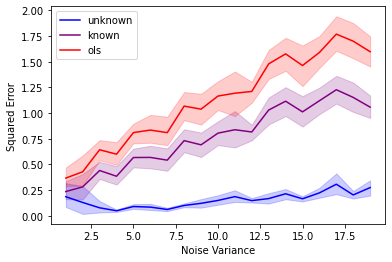

In [24]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [21]:
store.close()

In [20]:
print("hi")

hi
